In [1]:
import pandas as pd
import numpy as np

import math
import os

# # Make TensorFlow logs less verbose
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import flwr as fl
import tensorflow_probability as tfp

import keras
from sklearn.model_selection import train_test_split
from utils import model as mod
from utils import datapath
from flwr.common import NDArrays, Scalar
from scipy.stats import pearsonr
from typing import Dict, Optional, Tuple, List, Union
import typing
import random
import json
np.random.seed(2048)
tf.random.set_seed(2048)
random.seed(2048)
tf.keras.utils.set_random_seed(2048)



NUM_EPOCHS=10
BATCH_SIZE=16
path='resultsbn'
strat='FedDistill'

2023-09-28 08:54:34.606696: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-28 08:54:34.609169: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 08:54:34.662704: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 08:54:34.663833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 08:54:37.774582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
!pwd

/rds/user/sc2427/hpc-work/Final/FL


In [3]:
data=pd.read_csv(data_path)

In [4]:
df = pd.DataFrame(columns = data.columns)


In [5]:

dfs_to_concat = []

for i in range(250, 1000):
    mean_data = data.loc[data['Stamp'] == i].mean()
    dfs_to_concat.append(mean_data)

result_df = pd.concat(dfs_to_concat, axis=1).T.reset_index(drop=True)

In [6]:
data_new=result_df

In [7]:
data_new.shape

(750, 38)

In [8]:
y_labels=df.columns[-8:]

In [9]:
x_labels=df.columns[1:-8]

In [10]:
x=np.array(data_new[x_labels])

In [11]:
y=np.array(data_new[y_labels])

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)

In [13]:
x_train.shape

(562, 29)

In [14]:
# y_train=y_train.reshape((1,y_train.shape[0],y_train.shape[1]))
y_train.shape

(562, 8)

In [15]:

model_eval = mod()
model_eval.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError() ])

2023-09-28 08:54:51.229637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
def pcc(y_val, y_pred):
  temp={}
  for i in range(len(y_labels)):
    temp[y_labels[i]]=(pearsonr(y_val[:,i],y_pred[:,i])[0])
  return sum(list(temp.values()))/len(list(temp.values()))

In [17]:
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, model,cid, x_train, y_train, x_val, y_val, path) -> None:
        self.model = model
        self.cid=cid
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val
        self.path=path

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=2)
        # loss, rmse = model.evaluate(self.x_val, self.y_val)
        loss,rmse=self.model.evaluate(self.x_val, self.y_val)

        # result["pr"].append(pr)


        try:
          data=pd.read_csv(f"{self.path}/result_{self.cid}.csv")
          data.drop(["Unnamed: 0"], axis=1, inplace=True)

        except:
          data=pd.DataFrame(columns=["round","Loss", "RMSE"])

        data=pd.concat([data,pd.Series([config['server_round'], loss, rmse ] , index=data.columns ).to_frame().T])
        data.to_csv(f"{self.path}/result_{self.cid}.csv")

        return loss, len(self.x_val), {"accuracy": rmse}


In [18]:

#import pearsonr
def get_eval_fn(model, result,result_train):
    """Return an evaluation function for server-side evaluation."""

    # Load data and model here to avoid the overhead of doing it in `evaluate` itself


    # The `evaluate` function will be called after every round
    def evaluate(server_round: int, weights: fl.common.NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        model.set_weights(weights)  # Update model with the latest parameters
        loss, rmse = model.evaluate(x_test, y_test)
        loss_train,rmse_train=model.evaluate(x_train, y_train)
        result_train['Losses'].append(loss_train)
        result_train['rmse'].append(rmse_train)

        result["Losses"].append(loss)
        result["rmse"].append(rmse)
        # result["pr"].append(pr)
        for i in range(len(y_labels)):
          result["pearson"][y_labels[i]].append(pearsonr(y_test[:,i],model.predict(x_test)[:,i])[0])
          result_train['pearson'][y_labels[i]].append(pearsonr(y_train[:,i],model.predict(x_train)[:,i])[0])


        return loss, {"accuracy": rmse}

    return evaluate

In [19]:
model_eval.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 1016 (3.97 KB)
Trainable params: 952 (3.72

In [20]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

def evaluate_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

In [21]:
ray_init_args = {
            "num_gpus": 0,
            "num_cpus": 2
        }
client_res={"num_gpus": 0, "num_cpus": 2}

In [22]:
inital=mod()
#for clients from 2 to 10, run the strategy for 10 rounds each and create a list of results
results=[]
results_train=[]
# for i in range(5):
for i in range(2,11):
    try:
        os.mkdir(f"{path}/{i}")
    except:
        print()
    try:
        os.mkdir(f"{path}/{i}/{strat}")
    except:
        print()
    
    NUM_CLIENTS = i
    # losses=[]
    def client_fn(cid: str) -> fl.client.Client:
        # Create model
        model = mod()
        model.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError()])    
        partition_size = math.floor(len(x_train) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_train_cid = x_train[idx_from:idx_to]
        full_y_train_cid = y_train[idx_from:idx_to]
    
        if not os.path.exists(f"{path}/{i}/{strat}/{cid}"):
            print("training teacher model")
            teacher_model = mod()
            teacher_model.compile(tf.keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError() ])
            teacher_model.fit(full_x_train_cid, full_y_train_cid, epochs=10, verbose=2, batch_size=16)
            teacher_model.save(f"{path}/{i}/{strat}/{cid}")
        else:
            print("loading teacher model")
            teacher_model = tf.keras.models.load_model(f"{path}/{i}/{strat}/{cid}")
        #get the soft labels from the teacher model
        soft_labels=teacher_model.predict(full_x_train_cid)
        #set the y_train to the soft labels
        full_y_train_cid=soft_labels
    
    
        partition_size = math.floor(len(x_test) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_test_cid = x_test[idx_from:idx_to] 
        full_y_test_cid = y_test[idx_from:idx_to]
        
        # Create and return client
        return FlowerClient(model,cid, full_x_train_cid, full_y_train_cid, full_x_test_cid, full_y_test_cid, f"{path}/{i}/{strat}")


    
    
    result={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    result_train={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    try:
        del strategy
    except:
        print('starting')
    # Create FedAvg strategy
    strategy = fl.server.strategy.FedAvg(
      min_fit_clients=i,  # Never sample less than 10 clients for training
      evaluate_fn=get_eval_fn(model_eval, result,result_train),
      on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(inital.get_weights()),
    )
    
    # Start simulation
    fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=NUM_CLIENTS,
      config=fl.server.ServerConfig(num_rounds=10),
      strategy=strategy,
      ray_init_args=ray_init_args,
      client_resources=client_res,
    )
    results.append(result)
    results_train.append(result_train)
    # print(result)
    # try:
    #     data=pd.read_csv(f"{path}/combine_random{result['clients']}.csv")
    #     data.drop(["Unnamed: 0"], axis=1, inplace=True)
        
    # except:
    #     data=pd.DataFrame(columns=["Method", "Loss_Task1", "RMSE_Task1"])
    # data=pd.concat([data,pd.Series(["FedAvgEWC_Aug", result['Losses'][-1],result['rmse'][-1]] , index=data.columns ).to_frame().T])
    # data.to_csv(f"{path}/combine_random{result['clients']}.csv")



INFO flwr 2023-09-28 08:54:51,582 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)



starting


2023-09-28 08:54:56,580	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-28 08:54:56,778	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-28 08:54:58,170 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.44': 1.0,

18/18 [==============================] - 0s 997us/step


INFO flwr 2023-09-28 08:55:00,582 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-28 08:55:00,584 | server.py:101 | FL starting
DEBUG flwr 2023-09-28 08:55:00,585 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
(pid=266592) 2023-09-28 08:55:01.497690: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=266592) 2023-09-28 08:55:01.500044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=266592) 2023-09-28 08:55:01.549259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=266592) 2023-09-28 08:55:01.549662: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=266592) training teacher model
(launch_and_fit pid=266592) Epoch 1/10
(launch_and_fit pid=266592) 18/18 - 1s - loss: 8.6022 - root_mean_squared_error: 2.9329 - 1s/epoch - 71ms/step
(launch_and_fit pid=266592) Epoch 2/10
(launch_and_fit pid=266592) 18/18 - 0s - loss: 3.8598 - root_mean_squared_error: 1.9646 - 40ms/epoch - 2ms/step
(launch_and_fit pid=266592) Epoch 3/10
(launch_and_fit pid=266592) 18/18 - 0s - loss: 0.5085 - root_mean_squared_error: 0.7131 - 33ms/epoch - 2ms/step
(launch_and_fit pid=266592) Epoch 4/10
(launch_and_fit pid=266592) 18/18 - 0s - loss: 0.3460 - root_mean_squared_error: 0.5882 - 28ms/epoch - 2ms/step
(launch_and_fit pid=266592) Epoch 5/10
(launch_and_fit pid=266592) 18/18 - 0s - loss: 0.2423 - root_mean_squared_error: 0.4923 - 30ms/epoch - 2ms/step
(launch_and_fit pid=266592) Epoch 6/10
(launch_and_fit pid=266592) 18/18 - 0s - loss: 0.2401 - root_mean_squared_error: 0.4900 - 38ms/epoch - 2ms/step
(launch_and_fit pid=266592) Epoch 7/10
(laun

DEBUG flwr 2023-09-28 08:55:17,691 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-28 08:55:17,699 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


18/18 [==============================] - 0s 2ms/step - loss: 0.0882 - root_mean_squared_error: 0.2969
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0258 - root_mean_squared_error: 0.1605
(launch_and_fit pid=266592) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0333 - root_mean_squared_error: 0.1826
(launch_and_fit pid=266592) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0339 - root_mean_squared_error: 0.1840
(launch_and_fit pid=266592) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689
(launch_and_fit pid=266592) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-28 08:55:19,335 | server.py:119 | fit progress: (1, 0.2800142467021942, {'accuracy': 0.5291637778282166}, 18.750461492221802)
DEBUG flwr 2023-09-28 08:55:19,336 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=266592) loading teacher model
3/3 [==============================] - 0s 3ms/step - loss: 0.2919 - root_mean_squared_error: 0.5403
(launch_and_evaluate pid=266592) loading teacher model


DEBUG flwr 2023-09-28 08:55:21,259 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-28 08:55:21,260 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-28 08:55:21,261 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2681 - root_mean_squared_error: 0.5178
(launch_and_fit pid=266592) loading teacher model
9/9 [==============================] - 0s 1ms/step
(launch_and_fit pid=266592) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 0.0447 - root_mean_squared_error: 0.2115
(launch_and_fit pid=266592) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0376 - root_mean_squared_error: 0.1940
(launch_and_fit pid=266592) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0349 - root_mean_squared_error: 0.1868
(launch_and_fit pid=266592) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0268 - root_mean_squared_error: 0.1637
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0309 - root_mean_squared_error: 0.1756
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - 

DEBUG flwr 2023-09-28 08:55:25,645 | server.py:232 | fit_round 2 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.0161 - root_mean_squared_error: 0.1268
(launch_and_fit pid=266592) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245
(launch_and_fit pid=266592) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0185 - root_mean_squared_error: 0.1362
(launch_and_fit pid=266592) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162
(launch_and_fit pid=266592) Epoch 10/10
18/18 [==============================] - 0s 896us/step


INFO flwr 2023-09-28 08:55:27,132 | server.py:119 | fit progress: (2, 0.29397523403167725, {'accuracy': 0.5421948432922363}, 26.547584659885615)
DEBUG flwr 2023-09-28 08:55:27,133 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=266592) loading teacher model
3/3 [==============================] - 0s 2ms/step - loss: 0.2898 - root_mean_squared_error: 0.5384
(launch_and_evaluate pid=266592) loading teacher model


DEBUG flwr 2023-09-28 08:55:28,911 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-09-28 08:55:28,913 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2981 - root_mean_squared_error: 0.5460
(launch_and_fit pid=266592) loading teacher model
9/9 [==============================] - 0s 1ms/step
(launch_and_fit pid=266592) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.0323 - root_mean_squared_error: 0.1796
(launch_and_fit pid=266592) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0380 - root_mean_squared_error: 0.1951
(launch_and_fit pid=266592) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0312 - root_mean_squared_error: 0.1765
(launch_and_fit pid=266592) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0276 - root_mean_squared_error: 0.1661
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0240 - root_mean_squared_error: 0.1550
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - 

DEBUG flwr 2023-09-28 08:55:33,222 | server.py:232 | fit_round 3 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141
(launch_and_fit pid=266592) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258
(launch_and_fit pid=266592) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192
(launch_and_fit pid=266592) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113
(launch_and_fit pid=266592) Epoch 10/10
18/18 [==============================] - 0s 957us/step


INFO flwr 2023-09-28 08:55:34,595 | server.py:119 | fit progress: (3, 0.2598891258239746, {'accuracy': 0.509793221950531}, 34.009839243255556)
DEBUG flwr 2023-09-28 08:55:34,596 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=266592) loading teacher model
1/3 [=========>....................] - ETA: 0s - loss: 0.3408 - root_mean_squared_error: 0.5838


(launch_and_evaluate pid=266592) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2b03bf8fdca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=266592) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2b03bf8fdca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) crea

3/3 [==============================] - 0s 2ms/step - loss: 0.2655 - root_mean_squared_error: 0.5153
(launch_and_evaluate pid=266592) loading teacher model


(launch_and_evaluate pid=266592) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2b03bf78e9d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=266592) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2b03bf78e9d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) crea

3/3 [==============================] - 0s 2ms/step - loss: 0.2543 - root_mean_squared_error: 0.5042
(launch_and_fit pid=266592) loading teacher model
9/9 [==============================] - 0s 1ms/step
(launch_and_fit pid=266592) Epoch 1/10
18/18 [==============================] - 2s 3ms/step - loss: 0.0342 - root_mean_squared_error: 0.1849
(launch_and_fit pid=266592) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0449 - root_mean_squared_error: 0.2118
(launch_and_fit pid=266592) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0312 - root_mean_squared_error: 0.1767
(launch_and_fit pid=266592) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0249 - root_mean_squared_error: 0.1577
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0252 - root_mean_squared_error: 0.1589
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - 

DEBUG flwr 2023-09-28 08:55:40,850 | server.py:232 | fit_round 4 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0104 - root_mean_squared_error: 0.1022
(launch_and_fit pid=266592) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096
(launch_and_fit pid=266592) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0149 - root_mean_squared_error: 0.1220
(launch_and_fit pid=266592) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029
(launch_and_fit pid=266592) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-28 08:55:42,414 | server.py:119 | fit progress: (4, 0.2538992166519165, {'accuracy': 0.5038841366767883}, 41.82908873306587)
DEBUG flwr 2023-09-28 08:55:42,415 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=266592) loading teacher model
3/3 [==============================] - 0s 2ms/step - loss: 0.2498 - root_mean_squared_error: 0.4998
(launch_and_evaluate pid=266592) loading teacher model
9/9 [==============================] - 0s 1ms/step


DEBUG flwr 2023-09-28 08:55:44,342 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-09-28 08:55:44,343 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 5ms/step - loss: 0.2580 - root_mean_squared_error: 0.5080
(launch_and_fit pid=266592) loading teacher model
9/9 [==============================] - 0s 1ms/step
(launch_and_fit pid=266592) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688
(launch_and_fit pid=266592) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545
(launch_and_fit pid=266592) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407
(launch_and_fit pid=266592) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0160 - root_mean_squared_error: 0.1265
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 3ms/step - 

DEBUG flwr 2023-09-28 08:55:48,981 | server.py:232 | fit_round 5 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163
(launch_and_fit pid=266592) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049
(launch_and_fit pid=266592) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0190 - root_mean_squared_error: 0.1380
(launch_and_fit pid=266592) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291
(launch_and_fit pid=266592) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-28 08:55:50,479 | server.py:119 | fit progress: (5, 0.2433502972126007, {'accuracy': 0.4933054745197296}, 49.89442775491625)
DEBUG flwr 2023-09-28 08:55:50,480 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=266592) loading teacher model
3/3 [==============================] - 0s 2ms/step - loss: 0.2362 - root_mean_squared_error: 0.4860
(launch_and_evaluate pid=266592) loading teacher model


DEBUG flwr 2023-09-28 08:55:52,081 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-09-28 08:55:52,083 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2505 - root_mean_squared_error: 0.5005
(launch_and_fit pid=266592) loading teacher model
9/9 [==============================] - 0s 2ms/step
(launch_and_fit pid=266592) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.0190 - root_mean_squared_error: 0.1379
(launch_and_fit pid=266592) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297
(launch_and_fit pid=266592) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0182 - root_mean_squared_error: 0.1348
(launch_and_fit pid=266592) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0161 - root_mean_squared_error: 0.1270
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - 

DEBUG flwr 2023-09-28 08:55:56,097 | server.py:232 | fit_round 6 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.0233 - root_mean_squared_error: 0.1527
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0225 - root_mean_squared_error: 0.1501
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558
(launch_and_fit pid=266592) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791
(launch_and_fit pid=266592) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0255 - root_mean_squared_error: 0.1598
(launch_and_fit pid=266592) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0189 - root_mean_squared_error: 0.1376
(launch_and_fit pid=266592) Epoch 10/10
18/18 [==============================] - 0s 902us/step


INFO flwr 2023-09-28 08:55:57,531 | server.py:119 | fit progress: (6, 0.25879353284835815, {'accuracy': 0.5087175369262695}, 56.94662681501359)
DEBUG flwr 2023-09-28 08:55:57,533 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=266592) loading teacher model
3/3 [==============================] - 0s 2ms/step - loss: 0.2522 - root_mean_squared_error: 0.5022
(launch_and_evaluate pid=266592) loading teacher model


DEBUG flwr 2023-09-28 08:55:59,333 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-09-28 08:55:59,335 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2654 - root_mean_squared_error: 0.5151
(launch_and_fit pid=266592) loading teacher model
9/9 [==============================] - 0s 1ms/step
(launch_and_fit pid=266592) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.0251 - root_mean_squared_error: 0.1585
(launch_and_fit pid=266592) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0121 - root_mean_squared_error: 0.1101
(launch_and_fit pid=266592) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0080 - root_mean_squared_error: 0.0895
(launch_and_fit pid=266592) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0157 - root_mean_squared_error: 0.1253
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - 

DEBUG flwr 2023-09-28 08:56:03,510 | server.py:232 | fit_round 7 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.0266 - root_mean_squared_error: 0.1632
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0279 - root_mean_squared_error: 0.1671
(launch_and_fit pid=266592) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0252 - root_mean_squared_error: 0.1589
(launch_and_fit pid=266592) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384
(launch_and_fit pid=266592) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0145 - root_mean_squared_error: 0.1206
(launch_and_fit pid=266592) Epoch 10/10
18/18 [==============================] - 0s 795us/step


INFO flwr 2023-09-28 08:56:04,958 | server.py:119 | fit progress: (7, 0.25119587779045105, {'accuracy': 0.5011944770812988}, 64.37302841385826)
DEBUG flwr 2023-09-28 08:56:04,959 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=266592) loading teacher model
3/3 [==============================] - 0s 2ms/step - loss: 0.2595 - root_mean_squared_error: 0.5094
(launch_and_evaluate pid=266592) loading teacher model


DEBUG flwr 2023-09-28 08:56:06,621 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-09-28 08:56:06,623 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2429 - root_mean_squared_error: 0.4929
(launch_and_fit pid=266592) loading teacher model
9/9 [==============================] - 0s 1ms/step
(launch_and_fit pid=266592) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 0.0286 - root_mean_squared_error: 0.1691
(launch_and_fit pid=266592) Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387
(launch_and_fit pid=266592) Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0308 - root_mean_squared_error: 0.1755
(launch_and_fit pid=266592) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0268 - root_mean_squared_error: 0.1637
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - 

DEBUG flwr 2023-09-28 08:56:10,931 | server.py:232 | fit_round 8 received 2 results and 0 failures


18/18 [==============================] - 0s 1ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262
(launch_and_fit pid=266592) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0145 - root_mean_squared_error: 0.1203
(launch_and_fit pid=266592) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918
(launch_and_fit pid=266592) Epoch 10/10
18/18 [==============================] - 0s 928us/step


INFO flwr 2023-09-28 08:56:12,137 | server.py:119 | fit progress: (8, 0.24965235590934753, {'accuracy': 0.499652236700058}, 71.55221635522321)
DEBUG flwr 2023-09-28 08:56:12,138 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=266592) loading teacher model
3/3 [==============================] - 0s 2ms/step - loss: 0.2558 - root_mean_squared_error: 0.5057
(launch_and_evaluate pid=266592) loading teacher model


DEBUG flwr 2023-09-28 08:56:13,685 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-09-28 08:56:13,686 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2435 - root_mean_squared_error: 0.4935
(launch_and_fit pid=266592) loading teacher model
9/9 [==============================] - 0s 1ms/step
(launch_and_fit pid=266592) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400
(launch_and_fit pid=266592) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108
(launch_and_fit pid=266592) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113
(launch_and_fit pid=266592) Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0108 - root_mean_squared_error: 0.1040
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0110 - root_mean_squared_error: 0.1047
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - 

DEBUG flwr 2023-09-28 08:56:17,358 | server.py:232 | fit_round 9 received 2 results and 0 failures


18/18 [==============================] - 0s 1ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388
(launch_and_fit pid=266592) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553
(launch_and_fit pid=266592) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0271 - root_mean_squared_error: 0.1645
(launch_and_fit pid=266592) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.0346 - root_mean_squared_error: 0.1860
(launch_and_fit pid=266592) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-28 08:56:19,094 | server.py:119 | fit progress: (9, 0.26705747842788696, {'accuracy': 0.5167760848999023}, 78.50922476314008)
DEBUG flwr 2023-09-28 08:56:19,095 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=266592) loading teacher model
3/3 [==============================] - 0s 2ms/step - loss: 0.2626 - root_mean_squared_error: 0.5125
(launch_and_evaluate pid=266592) loading teacher model


DEBUG flwr 2023-09-28 08:56:21,080 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-09-28 08:56:21,082 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2715 - root_mean_squared_error: 0.5210
(launch_and_fit pid=266592) loading teacher model
9/9 [==============================] - 0s 1ms/step
(launch_and_fit pid=266592) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 0.0233 - root_mean_squared_error: 0.1525
(launch_and_fit pid=266592) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371
(launch_and_fit pid=266592) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293
(launch_and_fit pid=266592) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0196 - root_mean_squared_error: 0.1401
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - 

DEBUG flwr 2023-09-28 08:56:24,969 | server.py:232 | fit_round 10 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.0103 - root_mean_squared_error: 0.1014
(launch_and_fit pid=266592) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000
(launch_and_fit pid=266592) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0116 - root_mean_squared_error: 0.1076
(launch_and_fit pid=266592) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074
(launch_and_fit pid=266592) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025
(launch_and_fit pid=266592) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111
(launch_and_fit pid=266592) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880
(launch_and_fit pid=266592) Epoch 10/10
18/18 [=====

INFO flwr 2023-09-28 08:56:26,232 | server.py:119 | fit progress: (10, 0.24986018240451813, {'accuracy': 0.49986016750335693}, 85.64765903912485)
DEBUG flwr 2023-09-28 08:56:26,233 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=266592) loading teacher model
3/3 [==============================] - 0s 2ms/step - loss: 0.2566 - root_mean_squared_error: 0.5065
(launch_and_evaluate pid=266592) loading teacher model


DEBUG flwr 2023-09-28 08:56:27,924 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-09-28 08:56:27,926 | server.py:147 | FL finished in 87.34091193089262
INFO flwr 2023-09-28 08:56:27,929 | app.py:218 | app_fit: losses_distributed [(1, 0.2800142616033554), (2, 0.29397521913051605), (3, 0.2598890960216522), (4, 0.2538992166519165), (5, 0.2433502972126007), (6, 0.25879351794719696), (7, 0.25119588524103165), (8, 0.24965237081050873), (9, 0.26705747842788696), (10, 0.24986016750335693)]
INFO flwr 2023-09-28 08:56:27,930 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-28 08:56:27,931 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-28 08:56:27,932 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2800142467021942), (2, 0.29397523403167725), (3, 0.2598891258239746), (4, 0.2538992166519165), (5, 0.2433502972126007), (6, 0.25879353284835815), (7, 0.25119587779045105), (8, 0.24965235590934753), (9

9/9 [==============================] - 0s 1ms/step



2023-09-28 08:56:35,028	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-28 08:56:35,122	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-28 08:56:36,351 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.44': 1.0,

18/18 [==============================] - 0s 897us/step


INFO flwr 2023-09-28 08:56:37,863 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-28 08:56:37,863 | server.py:101 | FL starting
DEBUG flwr 2023-09-28 08:56:37,864 | server.py:218 | fit_round 1: strategy sampled 3 clients (out of 3)
(pid=12041) 2023-09-28 08:56:39.046315: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=12041) 2023-09-28 08:56:39.048602: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=12041) 2023-09-28 08:56:39.098176: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=12041) 2023-09-28 08:56:39.098659: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=12041) training teacher model
(launch_and_fit pid=12041) Epoch 1/10
(launch_and_fit pid=12041) 12/12 - 1s - loss: 9.5350 - root_mean_squared_error: 3.0879 - 1s/epoch - 89ms/step
(launch_and_fit pid=12041) Epoch 2/10
(launch_and_fit pid=12041) 12/12 - 0s - loss: 6.7197 - root_mean_squared_error: 2.5922 - 27ms/epoch - 2ms/step
(launch_and_fit pid=12041) Epoch 3/10
(launch_and_fit pid=12041) 12/12 - 0s - loss: 3.1782 - root_mean_squared_error: 1.7828 - 22ms/epoch - 2ms/step
(launch_and_fit pid=12041) Epoch 4/10
(launch_and_fit pid=12041) 12/12 - 0s - loss: 0.6640 - root_mean_squared_error: 0.8148 - 24ms/epoch - 2ms/step
(launch_and_fit pid=12041) Epoch 5/10
(launch_and_fit pid=12041) 12/12 - 0s - loss: 0.4001 - root_mean_squared_error: 0.6325 - 22ms/epoch - 2ms/step
(launch_and_fit pid=12041) Epoch 6/10
(launch_and_fit pid=12041) 12/12 - 0s - loss: 0.2743 - root_mean_squared_error: 0.5237 - 21ms/epoch - 2ms/step
(launch_and_fit pid=12041) Epoch 7/10
(launch_and_fit pid

DEBUG flwr 2023-09-28 08:56:58,461 | server.py:232 | fit_round 1 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 9.0687 - root_mean_squared_error: 3.0114
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 6.3365 - root_mean_squared_error: 2.5173
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 2.5929 - root_mean_squared_error: 1.6102
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2322 - root_mean_squared_error: 0.4819
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2027 - root_mean_squared_error: 0.4502
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0603 - root_mean_squared_error: 0.2455
(launch_and_fit pid=12041) Epoch 7/10
 1/12 [=>............................] - ETA: 0s - loss: 0.0687 - root_mean_squared_error: 0.2621


WARNING flwr 2023-09-28 08:56:58,487 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


12/12 [==============================] - 0s 2ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278
(launch_and_fit pid=12041) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0432 - root_mean_squared_error: 0.2078
(launch_and_fit pid=12041) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0504 - root_mean_squared_error: 0.2245
(launch_and_fit pid=12041) Epoch 10/10
18/18 [==============================] - 0s 874us/step


INFO flwr 2023-09-28 08:56:59,766 | server.py:119 | fit progress: (1, 0.30912721157073975, {'accuracy': 0.5559921264648438}, 21.90164877893403)
DEBUG flwr 2023-09-28 08:56:59,767 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2677 - root_mean_squared_error: 0.5174
(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2842 - root_mean_squared_error: 0.5331
(launch_and_evaluate pid=12041) loading teacher model


DEBUG flwr 2023-09-28 08:57:02,275 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-28 08:57:02,276 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-28 08:57:02,277 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 2ms/step - loss: 0.3726 - root_mean_squared_error: 0.6104
(launch_and_fit pid=12041) loading teacher model
6/6 [==============================] - 0s 2ms/step
(launch_and_fit pid=12041) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.0678 - root_mean_squared_error: 0.2604
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0585 - root_mean_squared_error: 0.2420
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0580 - root_mean_squared_error: 0.2408
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0350 - root_mean_squared_error: 0.1872
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0

DEBUG flwr 2023-09-28 08:57:08,665 | server.py:232 | fit_round 2 received 3 results and 0 failures


12/12 [==============================] - 0s 3ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0281 - root_mean_squared_error: 0.1678
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0255 - root_mean_squared_error: 0.1596
(launch_and_fit pid=12041) Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0263 - root_mean_squared_error: 0.1623
(launch_and_fit pid=12041) Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0308 - root_mean_squared_error: 0.1754
(launch_and_fit pid=12041) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0247 - root_mean_squared_error: 0.1573
(launch_and_fit pid=12041) Epoch 10/10
18/18 [==============================] - 0s 924us/step


INFO flwr 2023-09-28 08:57:10,039 | server.py:119 | fit progress: (2, 0.25060442090034485, {'accuracy': 0.5006040334701538}, 32.174894916825)
DEBUG flwr 2023-09-28 08:57:10,040 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3027 - root_mean_squared_error: 0.5502
(launch_and_evaluate pid=12041) loading teacher model
6/6 [==============================] - 0s 1ms/step


(launch_and_evaluate pid=12041) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b846bfcc9d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=12041) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b846bfcc9d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating

2/2 [==============================] - 0s 4ms/step - loss: 0.2235 - root_mean_squared_error: 0.4727
(launch_and_evaluate pid=12041) loading teacher model


DEBUG flwr 2023-09-28 08:57:12,553 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-09-28 08:57:12,555 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2234 - root_mean_squared_error: 0.4726


(launch_and_evaluate pid=12041) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b860aae8310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=12041) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b860aae8310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

(launch_and_fit pid=12041) loading teacher model
6/6 [==============================] - 0s 1ms/step
(launch_and_fit pid=12041) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.0677 - root_mean_squared_error: 0.2601
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0464 - root_mean_squared_error: 0.2154
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0233 - root_mean_squared_error: 0.1527
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0325 - root_mean_squared_error: 0.1803
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0423 - root_mean_squared_error: 0.2057
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0502 - root_mean_squared_error: 0.2242
(launch_and_fit pid=12041) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-28 08:57:18,617 | server.py:232 | fit_round 3 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.0196 - root_mean_squared_error: 0.1399
(launch_and_fit pid=12041) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0336 - root_mean_squared_error: 0.1833
(launch_and_fit pid=12041) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0350 - root_mean_squared_error: 0.1872
(launch_and_fit pid=12041) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0208 - root_mean_squared_error: 0.1443
(launch_and_fit pid=12041) Epoch 10/10
18/18 [==============================] - 0s 891us/step


INFO flwr 2023-09-28 08:57:19,903 | server.py:119 | fit progress: (3, 0.261773020029068, {'accuracy': 0.5116375684738159}, 42.03841856773943)
DEBUG flwr 2023-09-28 08:57:19,903 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 4ms/step - loss: 0.2325 - root_mean_squared_error: 0.4822
(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2366 - root_mean_squared_error: 0.4864
(launch_and_evaluate pid=12041) loading teacher model


DEBUG flwr 2023-09-28 08:57:22,808 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-09-28 08:57:22,810 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.3145 - root_mean_squared_error: 0.5608
(launch_and_fit pid=12041) loading teacher model
6/6 [==============================] - 0s 2ms/step
(launch_and_fit pid=12041) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.0541 - root_mean_squared_error: 0.2326
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0259 - root_mean_squared_error: 0.1609
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0422 - root_mean_squared_error: 0.2054
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0

DEBUG flwr 2023-09-28 08:57:28,925 | server.py:232 | fit_round 4 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.0492 - root_mean_squared_error: 0.2218
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0570 - root_mean_squared_error: 0.2387
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0405 - root_mean_squared_error: 0.2012
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0303 - root_mean_squared_error: 0.1741
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0312 - root_mean_squared_error: 0.1766
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0272 - root_mean_squared_error: 0.1649
(launch_and_fit pid=12041) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0517 - root_mean_squared_error: 0.2274
(launch_and_fit pid=12041) Epoch 8/10
12/12 [=============

INFO flwr 2023-09-28 08:57:30,331 | server.py:119 | fit progress: (4, 0.24692539870738983, {'accuracy': 0.49691590666770935}, 52.466458092909306)
DEBUG flwr 2023-09-28 08:57:30,332 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2977 - root_mean_squared_error: 0.5456
(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 4ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_evaluate pid=12041) loading teacher model


DEBUG flwr 2023-09-28 08:57:32,930 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-09-28 08:57:32,931 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673
(launch_and_fit pid=12041) loading teacher model
6/6 [==============================] - 0s 3ms/step
(launch_and_fit pid=12041) Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.0472 - root_mean_squared_error: 0.2172
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0272 - root_mean_squared_error: 0.1650
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0269 - root_mean_squared_error: 0.1639
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0215 - root_mean_squared_error: 0.1466
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0221 - root_mean_squared_error: 0.1486
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0

DEBUG flwr 2023-09-28 08:57:39,169 | server.py:232 | fit_round 5 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.0718 - root_mean_squared_error: 0.2679
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0401 - root_mean_squared_error: 0.2003
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0312 - root_mean_squared_error: 0.1766
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0338 - root_mean_squared_error: 0.1839
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0327 - root_mean_squared_error: 0.1809
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0276 - root_mean_squared_error: 0.1662
(launch_and_fit pid=12041) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502
(launch_and_fit pid=12041) Epoch 8/10
12/12 [=============

INFO flwr 2023-09-28 08:57:40,649 | server.py:119 | fit progress: (5, 0.2558562755584717, {'accuracy': 0.5058223605155945}, 62.78475592378527)
DEBUG flwr 2023-09-28 08:57:40,650 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2293 - root_mean_squared_error: 0.4789
(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2276 - root_mean_squared_error: 0.4771
(launch_and_evaluate pid=12041) loading teacher model


DEBUG flwr 2023-09-28 08:57:42,908 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-09-28 08:57:42,910 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.3096 - root_mean_squared_error: 0.5564
(launch_and_fit pid=12041) loading teacher model
6/6 [==============================] - 0s 1ms/step
(launch_and_fit pid=12041) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.0330 - root_mean_squared_error: 0.1815
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0200 - root_mean_squared_error: 0.1416
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0201 - root_mean_squared_error: 0.1416
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0110 - root_mean_squared_error: 0.1051
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0

DEBUG flwr 2023-09-28 08:57:48,911 | server.py:232 | fit_round 6 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.0764 - root_mean_squared_error: 0.2764
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0385 - root_mean_squared_error: 0.1962
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0259 - root_mean_squared_error: 0.1608
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0340 - root_mean_squared_error: 0.1844
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0477 - root_mean_squared_error: 0.2184
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0265 - root_mean_squared_error: 0.1628
(launch_and_fit pid=12041) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0313 - root_mean_squared_error: 0.1770
(launch_and_fit pid=12041) Epoch 8/10
12/12 [=============

INFO flwr 2023-09-28 08:57:50,253 | server.py:119 | fit progress: (6, 0.2483065128326416, {'accuracy': 0.49830362200737}, 72.38909692363814)
DEBUG flwr 2023-09-28 08:57:50,254 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 6ms/step - loss: 0.2230 - root_mean_squared_error: 0.4723
(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2998 - root_mean_squared_error: 0.5475
(launch_and_evaluate pid=12041) loading teacher model


DEBUG flwr 2023-09-28 08:57:53,194 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-09-28 08:57:53,196 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2214 - root_mean_squared_error: 0.4706
(launch_and_fit pid=12041) loading teacher model
6/6 [==============================] - 0s 1ms/step
(launch_and_fit pid=12041) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.0449 - root_mean_squared_error: 0.2118
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0374 - root_mean_squared_error: 0.1933
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0338 - root_mean_squared_error: 0.1840
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0294 - root_mean_squared_error: 0.1715
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0442 - root_mean_squared_error: 0.2102
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0

DEBUG flwr 2023-09-28 08:57:59,086 | server.py:232 | fit_round 7 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.0668 - root_mean_squared_error: 0.2585
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0427 - root_mean_squared_error: 0.2067
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0258 - root_mean_squared_error: 0.1605
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0308 - root_mean_squared_error: 0.1756
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0342 - root_mean_squared_error: 0.1849
(launch_and_fit pid=12041) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0424 - root_mean_squared_error: 0.2058
(launch_and_fit pid=12041) Epoch 8/10
12/12 [=============

INFO flwr 2023-09-28 08:58:00,450 | server.py:119 | fit progress: (7, 0.24327030777931213, {'accuracy': 0.4932244122028351}, 82.58628734806553)
DEBUG flwr 2023-09-28 08:58:00,451 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2946 - root_mean_squared_error: 0.5428
(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_evaluate pid=12041) loading teacher model


DEBUG flwr 2023-09-28 08:58:03,245 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-09-28 08:58:03,246 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2172 - root_mean_squared_error: 0.4660
(launch_and_fit pid=12041) loading teacher model
6/6 [==============================] - 0s 1ms/step
(launch_and_fit pid=12041) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.0451 - root_mean_squared_error: 0.2125
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0262 - root_mean_squared_error: 0.1619
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0655 - root_mean_squared_error: 0.2560
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0401 - root_mean_squared_error: 0.2002
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0270 - root_mean_squared_error: 0.1642
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0

DEBUG flwr 2023-09-28 08:58:09,435 | server.py:232 | fit_round 8 received 3 results and 0 failures


12/12 [==============================] - 0s 4ms/step - loss: 0.0162 - root_mean_squared_error: 0.1271
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1126
(launch_and_fit pid=12041) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259
(launch_and_fit pid=12041) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141
(launch_and_fit pid=12041) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0161 - root_mean_squared_error: 0.1270
(launch_and_fit pid=12041) Epoch 10/10
18/18 [==============================] - 0s 876us/step


INFO flwr 2023-09-28 08:58:11,057 | server.py:119 | fit progress: (8, 0.23645681142807007, {'accuracy': 0.4862682521343231}, 93.19315590104088)
DEBUG flwr 2023-09-28 08:58:11,058 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2114 - root_mean_squared_error: 0.4598
(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2859 - root_mean_squared_error: 0.5347
(launch_and_evaluate pid=12041) loading teacher model


DEBUG flwr 2023-09-28 08:58:13,441 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-09-28 08:58:13,442 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 2ms/step - loss: 0.2112 - root_mean_squared_error: 0.4596
(launch_and_fit pid=12041) loading teacher model
6/6 [==============================] - 0s 1ms/step
(launch_and_fit pid=12041) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.0520 - root_mean_squared_error: 0.2281
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0342 - root_mean_squared_error: 0.1850
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0242 - root_mean_squared_error: 0.1556
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0276 - root_mean_squared_error: 0.1661
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0457 - root_mean_squared_error: 0.2139
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0

DEBUG flwr 2023-09-28 08:58:19,067 | server.py:232 | fit_round 9 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.0435 - root_mean_squared_error: 0.2085
(launch_and_fit pid=12041) Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0282 - root_mean_squared_error: 0.1679
(launch_and_fit pid=12041) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508
(launch_and_fit pid=12041) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0308 - root_mean_squared_error: 0.1754
(launch_and_fit pid=12041) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-28 08:58:20,484 | server.py:119 | fit progress: (9, 0.24234932661056519, {'accuracy': 0.49228984117507935}, 102.61934030475095)
DEBUG flwr 2023-09-28 08:58:20,485 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_evaluate pid=12041) loading teacher model


DEBUG flwr 2023-09-28 08:58:23,417 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-09-28 08:58:23,419 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 2ms/step - loss: 0.2914 - root_mean_squared_error: 0.5398
(launch_and_fit pid=12041) loading teacher model
6/6 [==============================] - 0s 1ms/step
(launch_and_fit pid=12041) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.0522 - root_mean_squared_error: 0.2285
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0491 - root_mean_squared_error: 0.2215
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0249 - root_mean_squared_error: 0.1579
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0284 - root_mean_squared_error: 0.1684
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0316 - root_mean_squared_error: 0.1777
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0

DEBUG flwr 2023-09-28 08:58:29,360 | server.py:232 | fit_round 10 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926
(launch_and_fit pid=12041) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326
(launch_and_fit pid=12041) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136
(launch_and_fit pid=12041) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0180 - root_mean_squared_error: 0.1340
(launch_and_fit pid=12041) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0160 - root_mean_squared_error: 0.1264
(launch_and_fit pid=12041) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0214 - root_mean_squared_error: 0.1464
(launch_and_fit pid=12041) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0166 - root_mean_squared_error: 0.1290
(launch_and_fit pid=12041) Epoch 8/10
12/12 [=============

INFO flwr 2023-09-28 08:58:30,799 | server.py:119 | fit progress: (10, 0.23923015594482422, {'accuracy': 0.48911160230636597}, 112.93493418069556)
DEBUG flwr 2023-09-28 08:58:30,800 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2145 - root_mean_squared_error: 0.4631
(launch_and_evaluate pid=12041) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2148 - root_mean_squared_error: 0.4635
(launch_and_evaluate pid=12041) loading teacher model


DEBUG flwr 2023-09-28 08:58:33,006 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-09-28 08:58:33,007 | server.py:147 | FL finished in 115.14304095879197
INFO flwr 2023-09-28 08:58:33,008 | app.py:218 | app_fit: losses_distributed [(1, 0.30813344319661456), (2, 0.24984943866729736), (3, 0.26119233171145123), (4, 0.24627973635991415), (5, 0.2555085668961207), (6, 0.2480924129486084), (7, 0.2428338627020518), (8, 0.23617611328760782), (9, 0.2421130339304606), (10, 0.23896914720535278)]
INFO flwr 2023-09-28 08:58:33,009 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-28 08:58:33,009 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-28 08:58:33,010 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.30912721157073975), (2, 0.25060442090034485), (3, 0.261773020029068), (4, 0.24692539870738983), (5, 0.2558562755584717), (6, 0.2483065128326416), (7, 0.24327030777931213), (8, 0.23645681142807007), (

6/6 [==============================] - 0s 1ms/step



WARNING flwr 2023-09-28 08:58:33,056 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-28 08:58:33,058 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


2/2 [==============================] - 0s 2ms/step - loss: 0.2876 - root_mean_squared_error: 0.5363


2023-09-28 08:58:38,331	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-28 08:58:38,447	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-28 08:58:39,654 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 891us/step


INFO flwr 2023-09-28 08:58:41,153 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-28 08:58:41,154 | server.py:101 | FL starting
DEBUG flwr 2023-09-28 08:58:41,155 | server.py:218 | fit_round 1: strategy sampled 4 clients (out of 4)
(pid=51969) 2023-09-28 08:58:42.065353: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=51969) 2023-09-28 08:58:42.067465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=51969) 2023-09-28 08:58:42.117253: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=51969) 2023-09-28 08:58:42.117714: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=51969) training teacher model
(launch_and_fit pid=51969) Epoch 1/10
(launch_and_fit pid=51969) 9/9 - 1s - loss: 9.7893 - root_mean_squared_error: 3.1288 - 1s/epoch - 151ms/step
(launch_and_fit pid=51969) Epoch 2/10
(launch_and_fit pid=51969) 9/9 - 0s - loss: 7.9655 - root_mean_squared_error: 2.8223 - 19ms/epoch - 2ms/step
(launch_and_fit pid=51969) Epoch 3/10
(launch_and_fit pid=51969) 9/9 - 0s - loss: 5.6125 - root_mean_squared_error: 2.3691 - 16ms/epoch - 2ms/step
(launch_and_fit pid=51969) Epoch 4/10
(launch_and_fit pid=51969) 9/9 - 0s - loss: 2.6486 - root_mean_squared_error: 1.6275 - 16ms/epoch - 2ms/step
(launch_and_fit pid=51969) Epoch 5/10
(launch_and_fit pid=51969) 9/9 - 0s - loss: 0.6638 - root_mean_squared_error: 0.8147 - 15ms/epoch - 2ms/step
(launch_and_fit pid=51969) Epoch 6/10
(launch_and_fit pid=51969) 9/9 - 0s - loss: 0.4179 - root_mean_squared_error: 0.6464 - 16ms/epoch - 2ms/step
(launch_and_fit pid=51969) Epoch 7/10
(launch_and_fit pid=51969) 9/9

DEBUG flwr 2023-09-28 08:59:03,234 | server.py:232 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-28 08:59:03,262 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


9/9 [==============================] - 1s 3ms/step - loss: 8.3915 - root_mean_squared_error: 2.8968
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 6.5930 - root_mean_squared_error: 2.5677
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 4.3189 - root_mean_squared_error: 2.0782
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 1.6829 - root_mean_squared_error: 1.2973
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2378 - root_mean_squared_error: 0.4877
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2099 - root_mean_squared_error: 0.4581
(launch_and_fit pid=51969) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1385 - root_mean_squared_error: 0.3722
(launch_and_fit pid=51969) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-28 08:59:04,825 | server.py:119 | fit progress: (1, 0.2740802764892578, {'accuracy': 0.5235267877578735}, 23.67027651006356)
DEBUG flwr 2023-09-28 08:59:04,826 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2516 - root_mean_squared_error: 0.5016
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2886 - root_mean_squared_error: 0.5372
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.2370 - root_mean_squared_error: 0.4869
(launch_and_evaluate pid=51969) loading teacher model


DEBUG flwr 2023-09-28 08:59:08,345 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-28 08:59:08,346 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-28 08:59:08,348 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.3190 - root_mean_squared_error: 0.5648
(launch_and_fit pid=51969) loading teacher model
5/5 [==============================] - 0s 1ms/step
(launch_and_fit pid=51969) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.0676 - root_mean_squared_error: 0.2601
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0336 - root_mean_squared_error: 0.1834
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0391 - root_mean_squared_error: 0.1976
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0290 - root_mean_squared_error: 0.1702
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0271 - root_mean_squared_error: 0.1647
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0272 - root

DEBUG flwr 2023-09-28 08:59:15,598 | server.py:232 | fit_round 2 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.0722 - root_mean_squared_error: 0.2688
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0450 - root_mean_squared_error: 0.2121
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0305 - root_mean_squared_error: 0.1745
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0376 - root_mean_squared_error: 0.1940
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0384 - root_mean_squared_error: 0.1961
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318
(launch_and_fit pid=51969) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0264 - root_mean_squared_error: 0.1625
(launch_and_fit pid=51969) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-28 08:59:16,840 | server.py:119 | fit progress: (2, 0.24614694714546204, {'accuracy': 0.4961319863796234}, 35.68507468793541)
DEBUG flwr 2023-09-28 08:59:16,841 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=51969) loading teacher model
5/5 [==============================] - 0s 1ms/step


(launch_and_evaluate pid=51969) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b9f7fed9ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=51969) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b9f7fed9ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating

2/2 [==============================] - 0s 4ms/step - loss: 0.2671 - root_mean_squared_error: 0.5168
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 9ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755


(launch_and_evaluate pid=51969) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b9e93fb5a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=51969) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b9e93fb5a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2732 - root_mean_squared_error: 0.5227
(launch_and_evaluate pid=51969) loading teacher model


DEBUG flwr 2023-09-28 08:59:19,739 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-09-28 08:59:19,741 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2182 - root_mean_squared_error: 0.4671
(launch_and_fit pid=51969) loading teacher model
5/5 [==============================] - 0s 2ms/step
(launch_and_fit pid=51969) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.0601 - root_mean_squared_error: 0.2451
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0491 - root_mean_squared_error: 0.2217
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0592 - root_mean_squared_error: 0.2432
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0495 - root_mean_squared_error: 0.2226
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0298 - root

DEBUG flwr 2023-09-28 08:59:27,168 | server.py:232 | fit_round 3 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0365 - root_mean_squared_error: 0.1911
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0263 - root_mean_squared_error: 0.1621
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0227 - root_mean_squared_error: 0.1506
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0276 - root_mean_squared_error: 0.1660
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224
(launch_and_fit pid=51969) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425
(launch_and_fit pid=51969) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-28 08:59:28,743 | server.py:119 | fit progress: (3, 0.2478925883769989, {'accuracy': 0.49788808822631836}, 47.58822973491624)
DEBUG flwr 2023-09-28 08:59:28,746 | server.py:168 | evaluate_round 3: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2748 - root_mean_squared_error: 0.5242
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2174 - root_mean_squared_error: 0.4662
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2725 - root_mean_squared_error: 0.5220
(launch_and_evaluate pid=51969) loading teacher model


DEBUG flwr 2023-09-28 08:59:31,840 | server.py:182 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-09-28 08:59:31,842 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2269 - root_mean_squared_error: 0.4763
(launch_and_fit pid=51969) loading teacher model
5/5 [==============================] - 0s 863us/step
(launch_and_fit pid=51969) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.0445 - root_mean_squared_error: 0.2110
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0258 - root_mean_squared_error: 0.1606
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0301 - root_mean_squared_error: 0.1735
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0204 - ro

DEBUG flwr 2023-09-28 08:59:38,893 | server.py:232 | fit_round 4 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.0596 - root_mean_squared_error: 0.2441
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0288 - root_mean_squared_error: 0.1697
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0350 - root_mean_squared_error: 0.1872
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0502 - root_mean_squared_error: 0.2241
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0315 - root_mean_squared_error: 0.1775
(launch_and_fit pid=51969) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0481 - root_mean_squared_error: 0.2193
(launch_and_fit pid=51969) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-28 08:59:40,199 | server.py:119 | fit progress: (4, 0.24606956541538239, {'accuracy': 0.4960540235042572}, 59.044375797268)
DEBUG flwr 2023-09-28 08:59:40,200 | server.py:168 | evaluate_round 4: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 4ms/step - loss: 0.2187 - root_mean_squared_error: 0.4677
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2579 - root_mean_squared_error: 0.5078
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_evaluate pid=51969) loading teacher model


DEBUG flwr 2023-09-28 08:59:43,393 | server.py:182 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-09-28 08:59:43,395 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2793 - root_mean_squared_error: 0.5285
(launch_and_fit pid=51969) loading teacher model
5/5 [==============================] - 0s 1ms/step
(launch_and_fit pid=51969) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0345 - root_mean_squared_error: 0.1859
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0238 - root_mean_squared_error: 0.1543
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0268 - root_mean_squared_error: 0.1638
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0246 - root

DEBUG flwr 2023-09-28 08:59:50,649 | server.py:232 | fit_round 5 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.0364 - root_mean_squared_error: 0.1907
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0340 - root_mean_squared_error: 0.1844
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0329 - root_mean_squared_error: 0.1814
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0316 - root_mean_squared_error: 0.1779
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0215 - root_mean_squared_error: 0.1466
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378
(launch_and_fit pid=51969) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0258 - root_mean_squared_error: 0.1606
(launch_and_fit pid=51969) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-28 08:59:52,084 | server.py:119 | fit progress: (5, 0.25071981549263, {'accuracy': 0.5007193088531494}, 70.92860828293487)
DEBUG flwr 2023-09-28 08:59:52,085 | server.py:168 | evaluate_round 5: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2476 - root_mean_squared_error: 0.4975
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2303 - root_mean_squared_error: 0.4799
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2935 - root_mean_squared_error: 0.5417
(launch_and_evaluate pid=51969) loading teacher model


DEBUG flwr 2023-09-28 08:59:55,165 | server.py:182 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-09-28 08:59:55,167 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2315 - root_mean_squared_error: 0.4812
(launch_and_fit pid=51969) loading teacher model
5/5 [==============================] - 0s 1ms/step
(launch_and_fit pid=51969) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.0410 - root_mean_squared_error: 0.2024
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0381 - root_mean_squared_error: 0.1951
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0279 - root_mean_squared_error: 0.1669
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0190 - root

DEBUG flwr 2023-09-28 09:00:02,327 | server.py:232 | fit_round 6 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.0351 - root_mean_squared_error: 0.1875
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0245 - root_mean_squared_error: 0.1566
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0191 - root_mean_squared_error: 0.1384
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0207 - root_mean_squared_error: 0.1439
(launch_and_fit pid=51969) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259
(launch_and_fit pid=51969) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-28 09:00:03,535 | server.py:119 | fit progress: (6, 0.25438302755355835, {'accuracy': 0.504364013671875}, 82.38032432924956)
DEBUG flwr 2023-09-28 09:00:03,536 | server.py:168 | evaluate_round 6: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.2847 - root_mean_squared_error: 0.5335
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2322 - root_mean_squared_error: 0.4819
(launch_and_evaluate pid=51969) loading teacher model


DEBUG flwr 2023-09-28 09:00:06,941 | server.py:182 | evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-09-28 09:00:06,943 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2779 - root_mean_squared_error: 0.5272
(launch_and_fit pid=51969) loading teacher model
5/5 [==============================] - 0s 1ms/step
(launch_and_fit pid=51969) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.0508 - root_mean_squared_error: 0.2255
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0458 - root_mean_squared_error: 0.2139
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0184 - root_mean_squared_error: 0.1357
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0269 - root_mean_squared_error: 0.1640
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0163 - root

DEBUG flwr 2023-09-28 09:00:13,906 | server.py:232 | fit_round 7 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.0341 - root_mean_squared_error: 0.1847
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0307 - root_mean_squared_error: 0.1751
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0256 - root_mean_squared_error: 0.1600
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0200 - root_mean_squared_error: 0.1412
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0175 - root_mean_squared_error: 0.1325
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316
(launch_and_fit pid=51969) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0254 - root_mean_squared_error: 0.1593
(launch_and_fit pid=51969) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-28 09:00:15,522 | server.py:119 | fit progress: (7, 0.24548839032649994, {'accuracy': 0.4954678416252136}, 94.36664411099628)
DEBUG flwr 2023-09-28 09:00:15,523 | server.py:168 | evaluate_round 7: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2764 - root_mean_squared_error: 0.5258
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_evaluate pid=51969) loading teacher model
5/5 [==============================] - 0s 1ms/step


DEBUG flwr 2023-09-28 09:00:19,090 | server.py:182 | evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-09-28 09:00:19,092 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 2ms/step - loss: 0.2621 - root_mean_squared_error: 0.5119
(launch_and_fit pid=51969) loading teacher model
5/5 [==============================] - 0s 1ms/step
(launch_and_fit pid=51969) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.0338 - root_mean_squared_error: 0.1840
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0410 - root_mean_squared_error: 0.2024
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0205 - root_mean_squared_error: 0.1433
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0271 - root_mean_squared_error: 0.1648
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0111 - root

DEBUG flwr 2023-09-28 09:00:25,921 | server.py:232 | fit_round 8 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.0373 - root_mean_squared_error: 0.1932
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0360 - root_mean_squared_error: 0.1898
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0347 - root_mean_squared_error: 0.1862
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0162 - root_mean_squared_error: 0.1272
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0253 - root_mean_squared_error: 0.1591
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0265 - root_mean_squared_error: 0.1628
(launch_and_fit pid=51969) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0214 - root_mean_squared_error: 0.1464
(launch_and_fit pid=51969) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-28 09:00:27,302 | server.py:119 | fit progress: (8, 0.2414170801639557, {'accuracy': 0.49134212732315063}, 106.14689076831564)
DEBUG flwr 2023-09-28 09:00:27,303 | server.py:168 | evaluate_round 8: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2567 - root_mean_squared_error: 0.5067
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2190 - root_mean_squared_error: 0.4679
(launch_and_evaluate pid=51969) loading teacher model


DEBUG flwr 2023-09-28 09:00:30,021 | server.py:182 | evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-09-28 09:00:30,023 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2730 - root_mean_squared_error: 0.5225
(launch_and_fit pid=51969) loading teacher model
5/5 [==============================] - 0s 1ms/step
(launch_and_fit pid=51969) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.0259 - root_mean_squared_error: 0.1610
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0160 - root_mean_squared_error: 0.1264
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0308 - root_mean_squared_error: 0.1756
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0246 - root_mean_squared_error: 0.1567
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0177 - root

DEBUG flwr 2023-09-28 09:00:37,522 | server.py:232 | fit_round 9 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.0555 - root_mean_squared_error: 0.2356
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0248 - root_mean_squared_error: 0.1574
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0529 - root_mean_squared_error: 0.2300
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0330 - root_mean_squared_error: 0.1816
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0304 - root_mean_squared_error: 0.1745
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0421 - root_mean_squared_error: 0.2051
(launch_and_fit pid=51969) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0458 - root_mean_squared_error: 0.2139
(launch_and_fit pid=51969) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-28 09:00:38,970 | server.py:119 | fit progress: (9, 0.2392749786376953, {'accuracy': 0.48915740847587585}, 117.8145092711784)
DEBUG flwr 2023-09-28 09:00:38,971 | server.py:168 | evaluate_round 9: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2761 - root_mean_squared_error: 0.5255
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2197 - root_mean_squared_error: 0.4687
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.2185 - root_mean_squared_error: 0.4675
(launch_and_evaluate pid=51969) loading teacher model


DEBUG flwr 2023-09-28 09:00:42,070 | server.py:182 | evaluate_round 9 received 4 results and 0 failures
DEBUG flwr 2023-09-28 09:00:42,071 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2428 - root_mean_squared_error: 0.4927
(launch_and_fit pid=51969) loading teacher model
5/5 [==============================] - 0s 1ms/step
(launch_and_fit pid=51969) Epoch 1/10
9/9 [==============================] - 1s 4ms/step - loss: 0.0474 - root_mean_squared_error: 0.2178
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.0398 - root_mean_squared_error: 0.1996
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.0361 - root_mean_squared_error: 0.1901
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.0403 - root

DEBUG flwr 2023-09-28 09:00:49,415 | server.py:232 | fit_round 10 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.0292 - root_mean_squared_error: 0.1710
(launch_and_fit pid=51969) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0320 - root_mean_squared_error: 0.1790
(launch_and_fit pid=51969) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644
(launch_and_fit pid=51969) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130
(launch_and_fit pid=51969) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0345 - root_mean_squared_error: 0.1859
(launch_and_fit pid=51969) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0266 - root_mean_squared_error: 0.1630
(launch_and_fit pid=51969) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0212 - root_mean_squared_error: 0.1456
(launch_and_fit pid=51969) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-28 09:00:50,877 | server.py:119 | fit progress: (10, 0.24852165579795837, {'accuracy': 0.4985194504261017}, 129.72182431491092)
DEBUG flwr 2023-09-28 09:00:50,878 | server.py:168 | evaluate_round 10: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2586 - root_mean_squared_error: 0.5085
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2257 - root_mean_squared_error: 0.4751
(launch_and_evaluate pid=51969) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_evaluate pid=51969) loading teacher model
5/5 [==============================] - 0s 1ms/step


DEBUG flwr 2023-09-28 09:00:54,387 | server.py:182 | evaluate_round 10 received 4 results and 0 failures
INFO flwr 2023-09-28 09:00:54,388 | server.py:147 | FL finished in 133.23330840701237
INFO flwr 2023-09-28 09:00:54,390 | app.py:218 | app_fit: losses_distributed [(1, 0.2740802839398384), (2, 0.24614691361784935), (3, 0.2478925697505474), (4, 0.24606957659125328), (5, 0.2507197931408882), (6, 0.25438303127884865), (7, 0.24548841267824173), (8, 0.2414170764386654), (9, 0.2392749823629856), (10, 0.24852167069911957)]
INFO flwr 2023-09-28 09:00:54,391 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-28 09:00:54,392 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-28 09:00:54,393 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2740802764892578), (2, 0.24614694714546204), (3, 0.2478925883769989), (4, 0.24606956541538239), (5, 0.25071981549263), (6, 0.25438302755355835), (7, 0.24548839032649994), (8, 0.2414170801639557), (9, 


2/2 [==============================] - 0s 3ms/step - loss: 0.2852 - root_mean_squared_error: 0.5341


2023-09-28 09:01:00,710	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-28 09:01:00,804	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-28 09:01:02,163 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 884us/step


INFO flwr 2023-09-28 09:01:03,451 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-28 09:01:03,452 | server.py:101 | FL starting
DEBUG flwr 2023-09-28 09:01:03,453 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
(pid=98124) 2023-09-28 09:01:04.327792: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=98124) 2023-09-28 09:01:04.330070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=98124) 2023-09-28 09:01:04.379536: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=98124) 2023-09-28 09:01:04.379978: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=98124) training teacher model
(launch_and_fit pid=98124) Epoch 1/10
(launch_and_fit pid=98124) 7/7 - 1s - loss: 9.7547 - root_mean_squared_error: 3.1232 - 958ms/epoch - 137ms/step
(launch_and_fit pid=98124) Epoch 2/10
(launch_and_fit pid=98124) 7/7 - 0s - loss: 8.2809 - root_mean_squared_error: 2.8777 - 15ms/epoch - 2ms/step
(launch_and_fit pid=98124) Epoch 3/10
(launch_and_fit pid=98124) 7/7 - 0s - loss: 6.6487 - root_mean_squared_error: 2.5785 - 14ms/epoch - 2ms/step
(launch_and_fit pid=98124) Epoch 4/10
(launch_and_fit pid=98124) 7/7 - 0s - loss: 4.4604 - root_mean_squared_error: 2.1120 - 17ms/epoch - 2ms/step
(launch_and_fit pid=98124) Epoch 5/10
(launch_and_fit pid=98124) 7/7 - 0s - loss: 2.1520 - root_mean_squared_error: 1.4670 - 18ms/epoch - 3ms/step
(launch_and_fit pid=98124) Epoch 6/10
(launch_and_fit pid=98124) 7/7 - 0s - loss: 0.6354 - root_mean_squared_error: 0.7971 - 16ms/epoch - 2ms/step
(launch_and_fit pid=98124) Epoch 7/10
(launch_and_fit pid=98124) 

DEBUG flwr 2023-09-28 09:01:25,068 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-28 09:01:25,090 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


7/7 [==============================] - 0s 3ms/step - loss: 0.4203 - root_mean_squared_error: 0.6483
(launch_and_fit pid=98124) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1421 - root_mean_squared_error: 0.3769
(launch_and_fit pid=98124) Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2577 - root_mean_squared_error: 0.5077
(launch_and_fit pid=98124) Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0997 - root_mean_squared_error: 0.3157
(launch_and_fit pid=98124) Epoch 10/10
18/18 [==============================] - 0s 855us/step


INFO flwr 2023-09-28 09:01:26,389 | server.py:119 | fit progress: (1, 0.372435063123703, {'accuracy': 0.6102745532989502}, 22.9359848680906)
DEBUG flwr 2023-09-28 09:01:26,389 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3601 - root_mean_squared_error: 0.6001
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3463 - root_mean_squared_error: 0.5885
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.4300 - root_mean_squared_error: 0.6557
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.4231 - root_mean_squared_error: 0.6505
(launch_and_evaluate pid=98124) loading teacher model


DEBUG flwr 2023-09-28 09:01:44,133 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-28 09:01:44,134 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-28 09:01:44,135 | server.py:218 | fit_round 2: strategy sampled 5 clients (out of 5)


4/4 [==============================] - 0s 1ms/step


(launch_and_evaluate pid=98124) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b78e6597d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=98124) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b78e6597d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating

2/2 [==============================] - 0s 3ms/step - loss: 0.3073 - root_mean_squared_error: 0.5544
(launch_and_fit pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step
(launch_and_fit pid=98124) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0786 - root_mean_squared_error: 0.2803
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0507 - root_mean_squared_error: 0.2251
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0503 - root_mean_squared_error: 0.2243
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0319 - root_mean_squared_error: 0.1785
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0168 - root

DEBUG flwr 2023-09-28 09:01:52,974 | server.py:232 | fit_round 2 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.0598 - root_mean_squared_error: 0.2445
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0545 - root_mean_squared_error: 0.2335
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0338 - root_mean_squared_error: 0.1838
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0255 - root_mean_squared_error: 0.1596
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0273 - root_mean_squared_error: 0.1653
(launch_and_fit pid=98124) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0251 - root_mean_squared_error: 0.1584
(launch_and_fit pid=98124) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-28 09:01:54,435 | server.py:119 | fit progress: (2, 0.2876390516757965, {'accuracy': 0.53631991147995}, 50.982711856719106)
DEBUG flwr 2023-09-28 09:01:54,436 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step


(launch_and_evaluate pid=98124) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b78e62725e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=98124) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b78e62725e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

2/2 [==============================] - 0s 3ms/step - loss: 0.3368 - root_mean_squared_error: 0.5803
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2452 - root_mean_squared_error: 0.4952
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2623 - root_mean_squared_error: 0.5122
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 5ms/step - loss: 0.2650 - root_mean_squared_error: 0.5148
(launch_and_evaluate pid=98124) loading teacher model


DEBUG flwr 2023-09-28 09:01:58,572 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-28 09:01:58,574 | server.py:218 | fit_round 3: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.3328 - root_mean_squared_error: 0.5769
(launch_and_fit pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step
(launch_and_fit pid=98124) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0530 - root_mean_squared_error: 0.2302
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0345 - root_mean_squared_error: 0.1856
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0284 - root_mean_squared_error: 0.1684
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0257 - root_mean_squared_error: 0.1604
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0272 - root_mean_squared_error: 0.1649
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0162 - root

DEBUG flwr 2023-09-28 09:02:37,468 | server.py:232 | fit_round 3 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.0748 - root_mean_squared_error: 0.2736
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0398 - root_mean_squared_error: 0.1995
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0368 - root_mean_squared_error: 0.1919
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0338 - root_mean_squared_error: 0.1839
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0349 - root_mean_squared_error: 0.1869
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0308 - root_mean_squared_error: 0.1755
(launch_and_fit pid=98124) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607
(launch_and_fit pid=98124) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-28 09:02:38,994 | server.py:119 | fit progress: (3, 0.2774486839771271, {'accuracy': 0.5267339944839478}, 95.54095217492431)
DEBUG flwr 2023-09-28 09:02:38,995 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3170 - root_mean_squared_error: 0.5630
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2622 - root_mean_squared_error: 0.5121
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3269 - root_mean_squared_error: 0.5717
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.2433 - root_mean_squared_error: 0.4933
(launch_and_evaluate pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step


DEBUG flwr 2023-09-28 09:02:42,983 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-28 09:02:42,985 | server.py:218 | fit_round 4: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2414 - root_mean_squared_error: 0.4913
(launch_and_fit pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step
(launch_and_fit pid=98124) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0520 - root_mean_squared_error: 0.2279
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0303 - root_mean_squared_error: 0.1741
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0332 - root_mean_squared_error: 0.1823
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0221 - root_mean_squared_error: 0.1486
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0282 - root

DEBUG flwr 2023-09-28 09:02:52,292 | server.py:232 | fit_round 4 received 5 results and 0 failures


7/7 [==============================] - 1s 5ms/step - loss: 0.0682 - root_mean_squared_error: 0.2611
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0315 - root_mean_squared_error: 0.1775
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0377 - root_mean_squared_error: 0.1941
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0252 - root_mean_squared_error: 0.1588
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0238 - root_mean_squared_error: 0.1544
(launch_and_fit pid=98124) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0346 - root_mean_squared_error: 0.1860
(launch_and_fit pid=98124) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-28 09:02:54,165 | server.py:119 | fit progress: (4, 0.2809962034225464, {'accuracy': 0.5300907492637634}, 110.71236595697701)
DEBUG flwr 2023-09-28 09:02:54,166 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3274 - root_mean_squared_error: 0.5722
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2453 - root_mean_squared_error: 0.4953
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 6ms/step - loss: 0.2547 - root_mean_squared_error: 0.5047
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2511 - root_mean_squared_error: 0.5011
(launch_and_evaluate pid=98124) loading teacher model


DEBUG flwr 2023-09-28 09:02:58,636 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-09-28 09:02:58,637 | server.py:218 | fit_round 5: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.3316 - root_mean_squared_error: 0.5758
(launch_and_fit pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step
(launch_and_fit pid=98124) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0581 - root_mean_squared_error: 0.2410
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0416 - root_mean_squared_error: 0.2040
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0299 - root_mean_squared_error: 0.1731
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0260 - root_mean_squared_error: 0.1614
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0198 - root

DEBUG flwr 2023-09-28 09:03:07,453 | server.py:232 | fit_round 5 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.0776 - root_mean_squared_error: 0.2785
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0279 - root_mean_squared_error: 0.1672
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0267 - root_mean_squared_error: 0.1635
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0308 - root_mean_squared_error: 0.1756
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0304 - root_mean_squared_error: 0.1743
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0333 - root_mean_squared_error: 0.1826
(launch_and_fit pid=98124) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0297 - root_mean_squared_error: 0.1724
(launch_and_fit pid=98124) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-28 09:03:09,017 | server.py:119 | fit progress: (5, 0.2770143449306488, {'accuracy': 0.526321530342102}, 125.56435140175745)
DEBUG flwr 2023-09-28 09:03:09,018 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2553 - root_mean_squared_error: 0.5053
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3221 - root_mean_squared_error: 0.5675
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3185 - root_mean_squared_error: 0.5643
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2451 - root_mean_squared_error: 0.4950
(launch_and_evaluate pid=98124) loading teacher model
4/4 [==============================] - 0s 2ms/step


DEBUG flwr 2023-09-28 09:03:13,580 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-09-28 09:03:13,581 | server.py:218 | fit_round 6: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987
(launch_and_fit pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step
(launch_and_fit pid=98124) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0468 - root_mean_squared_error: 0.2164
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0292 - root_mean_squared_error: 0.1708
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0148 - root_mean_squared_error: 0.1216
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0190 - root_mean_squared_error: 0.1379
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0184 - root

DEBUG flwr 2023-09-28 09:03:22,533 | server.py:232 | fit_round 6 received 5 results and 0 failures


7/7 [==============================] - 1s 3ms/step - loss: 0.0484 - root_mean_squared_error: 0.2201
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0318 - root_mean_squared_error: 0.1784
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0378 - root_mean_squared_error: 0.1943
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0298 - root_mean_squared_error: 0.1727
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309
(launch_and_fit pid=98124) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383
(launch_and_fit pid=98124) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-28 09:03:23,961 | server.py:119 | fit progress: (6, 0.2859133780002594, {'accuracy': 0.5347086787223816}, 140.50872771581635)
DEBUG flwr 2023-09-28 09:03:23,963 | server.py:168 | evaluate_round 6: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3267 - root_mean_squared_error: 0.5716
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2606 - root_mean_squared_error: 0.5105
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3320 - root_mean_squared_error: 0.5762
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2639 - root_mean_squared_error: 0.5137
(launch_and_evaluate pid=98124) loading teacher model


DEBUG flwr 2023-09-28 09:03:28,359 | server.py:182 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-09-28 09:03:28,363 | server.py:218 | fit_round 7: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2510 - root_mean_squared_error: 0.5010
(launch_and_fit pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step
(launch_and_fit pid=98124) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0544 - root_mean_squared_error: 0.2332
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0280 - root_mean_squared_error: 0.1672
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0178 - root_mean_squared_error: 0.1332
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0314 - root_mean_squared_error: 0.1772
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0285 - root

DEBUG flwr 2023-09-28 09:03:37,789 | server.py:232 | fit_round 7 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.0359 - root_mean_squared_error: 0.1895
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0274 - root_mean_squared_error: 0.1654
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0208 - root_mean_squared_error: 0.1443
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0144 - root_mean_squared_error: 0.1199
(launch_and_fit pid=98124) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0090 - root_mean_squared_error: 0.0947
(launch_and_fit pid=98124) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-28 09:03:39,316 | server.py:119 | fit progress: (7, 0.2813563346862793, {'accuracy': 0.5304303169250488}, 155.86366697074845)
DEBUG flwr 2023-09-28 09:03:39,317 | server.py:168 | evaluate_round 7: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 5ms/step - loss: 0.2461 - root_mean_squared_error: 0.4961
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3253 - root_mean_squared_error: 0.5704
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2588 - root_mean_squared_error: 0.5087
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2570 - root_mean_squared_error: 0.5070
(launch_and_evaluate pid=98124) loading teacher model


DEBUG flwr 2023-09-28 09:03:43,417 | server.py:182 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-09-28 09:03:43,419 | server.py:218 | fit_round 8: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 4ms/step - loss: 0.3241 - root_mean_squared_error: 0.5693
(launch_and_fit pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step
(launch_and_fit pid=98124) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0423 - root_mean_squared_error: 0.2057
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0358 - root_mean_squared_error: 0.1891
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0222 - root_mean_squared_error: 0.1491
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0216 - root_mean_squared_error: 0.1470
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0203 - root

DEBUG flwr 2023-09-28 09:03:52,744 | server.py:232 | fit_round 8 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0350 - root_mean_squared_error: 0.1870
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0222 - root_mean_squared_error: 0.1489
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217
(launch_and_fit pid=98124) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0302 - root_mean_squared_error: 0.1737
(launch_and_fit pid=98124) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-28 09:03:54,494 | server.py:119 | fit progress: (8, 0.27668052911758423, {'accuracy': 0.5260043144226074}, 171.04134936491027)
DEBUG flwr 2023-09-28 09:03:54,495 | server.py:168 | evaluate_round 8: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3249 - root_mean_squared_error: 0.5700
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3177 - root_mean_squared_error: 0.5636
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2406 - root_mean_squared_error: 0.4905
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2544 - root_mean_squared_error: 0.5044
(launch_and_evaluate pid=98124) loading teacher model


DEBUG flwr 2023-09-28 09:03:58,862 | server.py:182 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-09-28 09:03:58,864 | server.py:218 | fit_round 9: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2503 - root_mean_squared_error: 0.5003
(launch_and_fit pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step
(launch_and_fit pid=98124) Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0313 - root_mean_squared_error: 0.1769
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0274 - root_mean_squared_error: 0.1655
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0102 - root

DEBUG flwr 2023-09-28 09:04:07,748 | server.py:232 | fit_round 9 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.0500 - root_mean_squared_error: 0.2236
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0256 - root_mean_squared_error: 0.1601
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105
(launch_and_fit pid=98124) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0098 - root_mean_squared_error: 0.0992
(launch_and_fit pid=98124) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-28 09:04:09,107 | server.py:119 | fit progress: (9, 0.26512834429740906, {'accuracy': 0.5149061679840088}, 185.65470396867022)
DEBUG flwr 2023-09-28 09:04:09,108 | server.py:168 | evaluate_round 9: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2492 - root_mean_squared_error: 0.4992
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 2ms/step - loss: 0.2348 - root_mean_squared_error: 0.4845
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3058 - root_mean_squared_error: 0.5530
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2327 - root_mean_squared_error: 0.4824
(launch_and_evaluate pid=98124) loading teacher model


DEBUG flwr 2023-09-28 09:04:13,674 | server.py:182 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-09-28 09:04:13,675 | server.py:218 | fit_round 10: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 4ms/step - loss: 0.3063 - root_mean_squared_error: 0.5535
(launch_and_fit pid=98124) loading teacher model
4/4 [==============================] - 0s 1ms/step
(launch_and_fit pid=98124) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0345 - root_mean_squared_error: 0.1857
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0303 - root_mean_squared_error: 0.1741
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0157 - root_mean_squared_error: 0.1251
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0110 - root

DEBUG flwr 2023-09-28 09:04:22,776 | server.py:232 | fit_round 10 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.0572 - root_mean_squared_error: 0.2392
(launch_and_fit pid=98124) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0375 - root_mean_squared_error: 0.1936
(launch_and_fit pid=98124) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0443 - root_mean_squared_error: 0.2105
(launch_and_fit pid=98124) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863
(launch_and_fit pid=98124) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0183 - root_mean_squared_error: 0.1353
(launch_and_fit pid=98124) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0147 - root_mean_squared_error: 0.1214
(launch_and_fit pid=98124) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167
(launch_and_fit pid=98124) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-28 09:04:24,147 | server.py:119 | fit progress: (10, 0.26959913969039917, {'accuracy': 0.5192293524742126}, 200.6943350979127)
DEBUG flwr 2023-09-28 09:04:24,148 | server.py:168 | evaluate_round 10: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2354 - root_mean_squared_error: 0.4852
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.2408 - root_mean_squared_error: 0.4907
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3104 - root_mean_squared_error: 0.5571
(launch_and_evaluate pid=98124) loading teacher model
2/2 [==============================] - 0s 3ms/step - loss: 0.3113 - root_mean_squared_error: 0.5579
(launch_and_evaluate pid=98124) loading teacher model


DEBUG flwr 2023-09-28 09:04:28,500 | server.py:182 | evaluate_round 10 received 5 results and 0 failures
INFO flwr 2023-09-28 09:04:28,501 | server.py:147 | FL finished in 205.04873087164015
INFO flwr 2023-09-28 09:04:28,510 | app.py:218 | app_fit: losses_distributed [(1, 0.3733593761920929), (2, 0.28844121694564817), (3, 0.27815971374511717), (4, 0.2820305049419403), (5, 0.27793210446834565), (6, 0.28683030009269717), (7, 0.2822617471218109), (8, 0.27758329510688784), (9, 0.26576201915740966), (10, 0.27022316455841067)]
INFO flwr 2023-09-28 09:04:28,511 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-28 09:04:28,512 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-28 09:04:28,513 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.372435063123703), (2, 0.2876390516757965), (3, 0.2774486839771271), (4, 0.2809962034225464), (5, 0.2770143449306488), (6, 0.2859133780002594), (7, 0.2813563346862793), (8, 0.27668052911758423), (9, 

4/4 [==============================] - 0s 1ms/step



WARNING flwr 2023-09-28 09:04:28,561 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-28 09:04:28,563 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


2/2 [==============================] - 0s 3ms/step - loss: 0.2533 - root_mean_squared_error: 0.5033


2023-09-28 09:04:33,359	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-28 09:04:33,478	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-28 09:04:34,690 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.44': 1.0,

18/18 [==============================] - 0s 928us/step


INFO flwr 2023-09-28 09:04:36,114 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-28 09:04:36,114 | server.py:101 | FL starting
DEBUG flwr 2023-09-28 09:04:36,115 | server.py:218 | fit_round 1: strategy sampled 6 clients (out of 6)
(pid=161315) 2023-09-28 09:04:37.124212: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=161315) 2023-09-28 09:04:37.126729: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=161315) 2023-09-28 09:04:37.184482: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=161315) 2023-09-28 09:04:37.184961: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=161315) training teacher model
(launch_and_fit pid=161315) Epoch 1/10
(launch_and_fit pid=161315) 6/6 - 1s - loss: 9.7207 - root_mean_squared_error: 3.1178 - 1s/epoch - 184ms/step
(launch_and_fit pid=161315) Epoch 2/10
(launch_and_fit pid=161315) 6/6 - 0s - loss: 8.3364 - root_mean_squared_error: 2.8873 - 17ms/epoch - 3ms/step
(launch_and_fit pid=161315) Epoch 3/10
(launch_and_fit pid=161315) 6/6 - 0s - loss: 6.8437 - root_mean_squared_error: 2.6160 - 15ms/epoch - 3ms/step
(launch_and_fit pid=161315) Epoch 4/10
(launch_and_fit pid=161315) 6/6 - 0s - loss: 5.0724 - root_mean_squared_error: 2.2522 - 14ms/epoch - 2ms/step
(launch_and_fit pid=161315) Epoch 5/10
(launch_and_fit pid=161315) 6/6 - 0s - loss: 3.1191 - root_mean_squared_error: 1.7661 - 13ms/epoch - 2ms/step
(launch_and_fit pid=161315) Epoch 6/10
(launch_and_fit pid=161315) 6/6 - 0s - loss: 1.4669 - root_mean_squared_error: 1.2112 - 12ms/epoch - 2ms/step
(launch_and_fit pid=161315) Epoch 7/10
(launch_and_fit 

(launch_and_fit pid=161315) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b3537f46ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_fit pid=161315) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b3537f46ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) cr

3/3 [==============================] - 0s 2ms/step
(launch_and_fit pid=161315) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 12.6447 - root_mean_squared_error: 3.5559
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 11.1396 - root_mean_squared_error: 3.3376
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 9.6611 - root_mean_squared_error: 3.1082
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 7.6097 - root_mean_squared_error: 2.7586
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 5.1009 - root_mean_squared_error: 2.2585
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 2.5992 - root_mean_squared_error: 1.6122
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7752 - root_m

(launch_and_fit pid=161315) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b36aee3c790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_fit pid=161315) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b36aee3c790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) cr

3/3 [==============================] - 0s 2ms/step
(launch_and_fit pid=161315) Epoch 1/10


DEBUG flwr 2023-09-28 09:05:03,195 | server.py:232 | fit_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-28 09:05:03,217 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


6/6 [==============================] - 1s 2ms/step - loss: 10.7676 - root_mean_squared_error: 3.2814
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 9.3590 - root_mean_squared_error: 3.0592
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 7.9987 - root_mean_squared_error: 2.8282
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 6.1744 - root_mean_squared_error: 2.4848
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 3.9395 - root_mean_squared_error: 1.9848
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 1.8084 - root_mean_squared_error: 1.3448
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.4265 - root_mean_squared_error: 0.6531
(launch_and_fit pid=161315) Epoch 8/10
6/6 [=====================

INFO flwr 2023-09-28 09:05:04,825 | server.py:119 | fit progress: (1, 0.3400351405143738, {'accuracy': 0.5831252932548523}, 28.710136373061687)
DEBUG flwr 2023-09-28 09:05:04,826 | server.py:168 | evaluate_round 1: strategy sampled 6 clients (out of 6)


(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 142ms/step - loss: 0.2936 - root_mean_squared_error: 0.5418
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.4123 - root_mean_squared_error: 0.6421
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.3543 - root_mean_squared_error: 0.5952
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.2981 - root_mean_squared_error: 0.5460
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.3252 - root_mean_squared_error: 0.5703


(launch_and_evaluate pid=161315) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b3537f465e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=161315) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b3537f465e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

(launch_and_evaluate pid=161315) loading teacher model


DEBUG flwr 2023-09-28 09:05:09,984 | server.py:182 | evaluate_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-28 09:05:09,986 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-28 09:05:09,987 | server.py:218 | fit_round 2: strategy sampled 6 clients (out of 6)


3/3 [==============================] - 0s 1ms/step


(launch_and_evaluate pid=161315) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b362fe269d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=161315) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b362fe269d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

1/1 [==============================] - 0s 104ms/step - loss: 0.3606 - root_mean_squared_error: 0.6005
(launch_and_fit pid=161315) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=161315) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.0851 - root_mean_squared_error: 0.2917
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0912 - root_mean_squared_error: 0.3021
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0490 - root_mean_squared_error: 0.2214
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0308 - root_mean_squared_error: 0.1754
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:05:20,974 | server.py:232 | fit_round 2 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.1266 - root_mean_squared_error: 0.3558
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0855 - root_mean_squared_error: 0.2924
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0695 - root_mean_squared_error: 0.2636
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0596 - root_mean_squared_error: 0.2440
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0495 - root_mean_squared_error: 0.2225
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0493 - root_mean_squared_error: 0.2219
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0424 - root_mean_squared_error: 0.2059
(launch_and_fit pid=161315) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-28 09:05:22,333 | server.py:119 | fit progress: (2, 0.25290820002555847, {'accuracy': 0.5028997659683228}, 46.21776537131518)
DEBUG flwr 2023-09-28 09:05:22,334 | server.py:168 | evaluate_round 2: strategy sampled 6 clients (out of 6)


(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 113ms/step - loss: 0.2820 - root_mean_squared_error: 0.5311
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 152ms/step - loss: 0.2400 - root_mean_squared_error: 0.4899
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.3192 - root_mean_squared_error: 0.5649
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.2295 - root_mean_squared_error: 0.4790
(launch_and_evaluate pid=161315) loading teacher model


DEBUG flwr 2023-09-28 09:05:27,610 | server.py:182 | evaluate_round 2 received 6 results and 0 failures
DEBUG flwr 2023-09-28 09:05:27,611 | server.py:218 | fit_round 3: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 106ms/step - loss: 0.2253 - root_mean_squared_error: 0.4746
(launch_and_fit pid=161315) loading teacher model
3/3 [==============================] - 0s 2ms/step
(launch_and_fit pid=161315) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.0653 - root_mean_squared_error: 0.2555
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0726 - root_mean_squared_error: 0.2694
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0485 - root_mean_squared_error: 0.2202
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0301 - root_mean_squared_error: 0.1735
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0382 - root_mean_squared_error: 0.1954
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:05:38,676 | server.py:232 | fit_round 3 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.1051 - root_mean_squared_error: 0.3242
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0452 - root_mean_squared_error: 0.2126
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0482 - root_mean_squared_error: 0.2194
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0513 - root_mean_squared_error: 0.2265
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0450 - root_mean_squared_error: 0.2122
(launch_and_fit pid=161315) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-28 09:05:40,302 | server.py:119 | fit progress: (3, 0.2675248384475708, {'accuracy': 0.5172280669212341}, 64.18710858793929)
DEBUG flwr 2023-09-28 09:05:40,304 | server.py:168 | evaluate_round 3: strategy sampled 6 clients (out of 6)


(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 195ms/step - loss: 0.3372 - root_mean_squared_error: 0.5807
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.2385 - root_mean_squared_error: 0.4883
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.2381 - root_mean_squared_error: 0.4880
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 146ms/step - loss: 0.2452 - root_mean_squared_error: 0.4952
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 148ms/step - loss: 0.2912 - root_mean_squared_error: 0.5396
(launch_and_evaluate pid=161315) loading teacher model
3/3 [==============================] - 0s 1ms/step


DEBUG flwr 2023-09-28 09:05:46,102 | server.py:182 | evaluate_round 3 received 6 results and 0 failures
DEBUG flwr 2023-09-28 09:05:46,104 | server.py:218 | fit_round 4: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 1s 522ms/step - loss: 0.2580 - root_mean_squared_error: 0.5079
(launch_and_fit pid=161315) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=161315) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.1088 - root_mean_squared_error: 0.3299
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1062 - root_mean_squared_error: 0.3259
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0339 - root_mean_squared_error: 0.1840
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0302 - root_mean_squared_error: 0.1739
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0271 - root_mean_squared_error: 0.1648
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.04

DEBUG flwr 2023-09-28 09:05:57,179 | server.py:232 | fit_round 4 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.0673 - root_mean_squared_error: 0.2595
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0636 - root_mean_squared_error: 0.2522
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0619 - root_mean_squared_error: 0.2489
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0247 - root_mean_squared_error: 0.1570
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0455 - root_mean_squared_error: 0.2132
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0195 - root_mean_squared_error: 0.1397
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0360 - root_mean_squared_error: 0.1896
(launch_and_fit pid=161315) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-28 09:05:58,644 | server.py:119 | fit progress: (4, 0.25662463903427124, {'accuracy': 0.5065813064575195}, 82.52928924513981)
DEBUG flwr 2023-09-28 09:05:58,645 | server.py:168 | evaluate_round 4: strategy sampled 6 clients (out of 6)


(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2845 - root_mean_squared_error: 0.5334
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 152ms/step - loss: 0.3304 - root_mean_squared_error: 0.5748
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.2296 - root_mean_squared_error: 0.4791
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 140ms/step - loss: 0.2281 - root_mean_squared_error: 0.4776
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.2427 - root_mean_squared_error: 0.4926
(launch_and_evaluate pid=161315) loading teacher model


DEBUG flwr 2023-09-28 09:06:03,735 | server.py:182 | evaluate_round 4 received 6 results and 0 failures
DEBUG flwr 2023-09-28 09:06:03,736 | server.py:218 | fit_round 5: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 107ms/step - loss: 0.2278 - root_mean_squared_error: 0.4773
(launch_and_fit pid=161315) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=161315) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.1563 - root_mean_squared_error: 0.3953
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0917 - root_mean_squared_error: 0.3029
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0478 - root_mean_squared_error: 0.2186
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0422 - root_mean_squared_error: 0.2054
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0377 - root_mean_squared_error: 0.1941
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:06:14,676 | server.py:232 | fit_round 5 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.0787 - root_mean_squared_error: 0.2805
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0496 - root_mean_squared_error: 0.2227
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0446 - root_mean_squared_error: 0.2113
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0198 - root_mean_squared_error: 0.1406
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0433 - root_mean_squared_error: 0.2080
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385
(launch_and_fit pid=161315) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-28 09:06:16,099 | server.py:119 | fit progress: (5, 0.2479207068681717, {'accuracy': 0.4979163706302643}, 99.98443519696593)
DEBUG flwr 2023-09-28 09:06:16,100 | server.py:168 | evaluate_round 5: strategy sampled 6 clients (out of 6)


(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.2976 - root_mean_squared_error: 0.5455
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2169 - root_mean_squared_error: 0.4657
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 154ms/step - loss: 0.2286 - root_mean_squared_error: 0.4782
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 111ms/step - loss: 0.2068 - root_mean_squared_error: 0.4548
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 153ms/step - loss: 0.2324 - root_mean_squared_error: 0.4820
(launch_and_evaluate pid=161315) loading teacher model


DEBUG flwr 2023-09-28 09:06:21,416 | server.py:182 | evaluate_round 5 received 6 results and 0 failures
DEBUG flwr 2023-09-28 09:06:21,417 | server.py:218 | fit_round 6: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 110ms/step - loss: 0.3092 - root_mean_squared_error: 0.5560
(launch_and_fit pid=161315) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=161315) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.0751 - root_mean_squared_error: 0.2741
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0415 - root_mean_squared_error: 0.2036
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0230 - root_mean_squared_error: 0.1517
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0292 - root_mean_squared_error: 0.1710
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0276 - root_mean_squared_error: 0.1661
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:06:32,709 | server.py:232 | fit_round 6 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.0687 - root_mean_squared_error: 0.2621
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0503 - root_mean_squared_error: 0.2242
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0395 - root_mean_squared_error: 0.1989
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0288 - root_mean_squared_error: 0.1696
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0195 - root_mean_squared_error: 0.1396
(launch_and_fit pid=161315) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-28 09:06:34,261 | server.py:119 | fit progress: (6, 0.25083956122398376, {'accuracy': 0.5008388161659241}, 118.1462826882489)
DEBUG flwr 2023-09-28 09:06:34,262 | server.py:168 | evaluate_round 6: strategy sampled 6 clients (out of 6)


(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 115ms/step - loss: 0.2856 - root_mean_squared_error: 0.5344
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 150ms/step - loss: 0.2271 - root_mean_squared_error: 0.4765
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 151ms/step - loss: 0.2217 - root_mean_squared_error: 0.4708
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 155ms/step - loss: 0.3149 - root_mean_squared_error: 0.5611
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 117ms/step - loss: 0.2168 - root_mean_squared_error: 0.4657
(launch_and_evaluate pid=161315) loading teacher model


DEBUG flwr 2023-09-28 09:06:39,691 | server.py:182 | evaluate_round 6 received 6 results and 0 failures
DEBUG flwr 2023-09-28 09:06:39,693 | server.py:218 | fit_round 7: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 107ms/step - loss: 0.2428 - root_mean_squared_error: 0.4928
(launch_and_fit pid=161315) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=161315) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.1377 - root_mean_squared_error: 0.3710
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0647 - root_mean_squared_error: 0.2545
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0346 - root_mean_squared_error: 0.1861
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0318 - root_mean_squared_error: 0.1784
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.04

DEBUG flwr 2023-09-28 09:06:50,385 | server.py:232 | fit_round 7 received 6 results and 0 failures


6/6 [==============================] - 1s 4ms/step - loss: 0.0858 - root_mean_squared_error: 0.2929
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0306 - root_mean_squared_error: 0.1749
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0287 - root_mean_squared_error: 0.1693
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0350 - root_mean_squared_error: 0.1871
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0291 - root_mean_squared_error: 0.1707
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0268 - root_mean_squared_error: 0.1636
(launch_and_fit pid=161315) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-28 09:06:51,789 | server.py:119 | fit progress: (7, 0.24418024718761444, {'accuracy': 0.4941459894180298}, 135.67452335823327)
DEBUG flwr 2023-09-28 09:06:51,791 | server.py:168 | evaluate_round 7: strategy sampled 6 clients (out of 6)


(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.2778 - root_mean_squared_error: 0.5271
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2123 - root_mean_squared_error: 0.4608
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.2151 - root_mean_squared_error: 0.4638
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 115ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855
(launch_and_evaluate pid=161315) loading teacher model
3/3 [==============================] - 0s 1ms/step


DEBUG flwr 2023-09-28 09:06:57,086 | server.py:182 | evaluate_round 7 received 6 results and 0 failures
DEBUG flwr 2023-09-28 09:06:57,087 | server.py:218 | fit_round 8: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 114ms/step - loss: 0.3109 - root_mean_squared_error: 0.5576
(launch_and_fit pid=161315) loading teacher model
3/3 [==============================] - 0s 2ms/step
(launch_and_fit pid=161315) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.0605 - root_mean_squared_error: 0.2461
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0345 - root_mean_squared_error: 0.1857
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0382 - root_mean_squared_error: 0.1954
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0305 - root_mean_squared_error: 0.1745
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:07:07,903 | server.py:232 | fit_round 8 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.0643 - root_mean_squared_error: 0.2536
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0449 - root_mean_squared_error: 0.2119
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0246 - root_mean_squared_error: 0.1568
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0281 - root_mean_squared_error: 0.1677
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0319 - root_mean_squared_error: 0.1785
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0285 - root_mean_squared_error: 0.1687
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0150 - root_mean_squared_error: 0.1223
(launch_and_fit pid=161315) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-28 09:07:09,153 | server.py:119 | fit progress: (8, 0.2519250512123108, {'accuracy': 0.5019213557243347}, 153.03850300889462)
DEBUG flwr 2023-09-28 09:07:09,154 | server.py:168 | evaluate_round 8: strategy sampled 6 clients (out of 6)


(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 111ms/step - loss: 0.2221 - root_mean_squared_error: 0.4712
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 115ms/step - loss: 0.2448 - root_mean_squared_error: 0.4948
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 124ms/step - loss: 0.2268 - root_mean_squared_error: 0.4763
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 115ms/step - loss: 0.2781 - root_mean_squared_error: 0.5273
(launch_and_evaluate pid=161315) loading teacher model


DEBUG flwr 2023-09-28 09:07:15,827 | server.py:182 | evaluate_round 8 received 6 results and 0 failures
DEBUG flwr 2023-09-28 09:07:15,828 | server.py:218 | fit_round 9: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 126ms/step - loss: 0.3212 - root_mean_squared_error: 0.5668
(launch_and_fit pid=161315) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=161315) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0509 - root_mean_squared_error: 0.2257
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0206 - root_mean_squared_error: 0.1437
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0203 - root_mean_squared_error: 0.1426
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.01

DEBUG flwr 2023-09-28 09:07:27,219 | server.py:232 | fit_round 9 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.0629 - root_mean_squared_error: 0.2509
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0560 - root_mean_squared_error: 0.2365
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0398 - root_mean_squared_error: 0.1995
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0315 - root_mean_squared_error: 0.1774
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0505 - root_mean_squared_error: 0.2247
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0306 - root_mean_squared_error: 0.1750
(launch_and_fit pid=161315) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-28 09:07:28,703 | server.py:119 | fit progress: (9, 0.24910208582878113, {'accuracy': 0.49910128116607666}, 172.58815232524648)
DEBUG flwr 2023-09-28 09:07:28,704 | server.py:168 | evaluate_round 9: strategy sampled 6 clients (out of 6)


(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 113ms/step - loss: 0.2191 - root_mean_squared_error: 0.4681
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 150ms/step - loss: 0.2154 - root_mean_squared_error: 0.4642
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.3156 - root_mean_squared_error: 0.5618
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 157ms/step - loss: 0.2807 - root_mean_squared_error: 0.5298
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.2253 - root_mean_squared_error: 0.4747
(launch_and_evaluate pid=161315) loading teacher model


DEBUG flwr 2023-09-28 09:07:33,956 | server.py:182 | evaluate_round 9 received 6 results and 0 failures
DEBUG flwr 2023-09-28 09:07:33,958 | server.py:218 | fit_round 10: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 106ms/step - loss: 0.2422 - root_mean_squared_error: 0.4922
(launch_and_fit pid=161315) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=161315) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.1190 - root_mean_squared_error: 0.3449
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0855 - root_mean_squared_error: 0.2923
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0481 - root_mean_squared_error: 0.2193
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0353 - root_mean_squared_error: 0.1878
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0425 - root_mean_squared_error: 0.2061
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:07:45,109 | server.py:232 | fit_round 10 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.0924 - root_mean_squared_error: 0.3039
(launch_and_fit pid=161315) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0529 - root_mean_squared_error: 0.2300
(launch_and_fit pid=161315) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0559 - root_mean_squared_error: 0.2364
(launch_and_fit pid=161315) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557
(launch_and_fit pid=161315) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949
(launch_and_fit pid=161315) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.0271 - root_mean_squared_error: 0.1645
(launch_and_fit pid=161315) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0313 - root_mean_squared_error: 0.1769
(launch_and_fit pid=161315) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-28 09:07:46,359 | server.py:119 | fit progress: (10, 0.24916759133338928, {'accuracy': 0.499166876077652}, 190.24446332314983)
DEBUG flwr 2023-09-28 09:07:46,360 | server.py:168 | evaluate_round 10: strategy sampled 6 clients (out of 6)


(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 116ms/step - loss: 0.2762 - root_mean_squared_error: 0.5256
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.3167 - root_mean_squared_error: 0.5628
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_evaluate pid=161315) loading teacher model
1/1 [==============================] - 0s 113ms/step - loss: 0.2202 - root_mean_squared_error: 0.4692
(launch_and_evaluate pid=161315) loading teacher model


DEBUG flwr 2023-09-28 09:08:11,476 | server.py:182 | evaluate_round 10 received 6 results and 0 failures
INFO flwr 2023-09-28 09:08:11,478 | server.py:147 | FL finished in 215.36294517898932
INFO flwr 2023-09-28 09:08:11,479 | app.py:218 | app_fit: losses_distributed [(1, 0.34067171315352124), (2, 0.2533278490106265), (3, 0.2680176571011543), (4, 0.25717046360174817), (5, 0.24857343484958014), (6, 0.25148168206214905), (7, 0.2448020726442337), (8, 0.2525240977605184), (9, 0.24972773591677347), (10, 0.24979387720425925)]
INFO flwr 2023-09-28 09:08:11,480 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-28 09:08:11,481 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-28 09:08:11,482 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.3400351405143738), (2, 0.25290820002555847), (3, 0.2675248384475708), (4, 0.25662463903427124), (5, 0.2479207068681717), (6, 0.25083956122398376), (7, 0.24418024718761444), (8, 0.2519250512123108), (

3/3 [==============================] - 0s 2ms/step



WARNING flwr 2023-09-28 09:08:11,537 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-28 09:08:11,539 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


1/1 [==============================] - 0s 116ms/step - loss: 0.2432 - root_mean_squared_error: 0.4931


2023-09-28 09:08:16,608	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-28 09:08:16,731	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-28 09:08:18,100 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 914us/step


INFO flwr 2023-09-28 09:08:19,638 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-28 09:08:19,638 | server.py:101 | FL starting
DEBUG flwr 2023-09-28 09:08:19,639 | server.py:218 | fit_round 1: strategy sampled 7 clients (out of 7)
(pid=217760) 2023-09-28 09:08:20.424623: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=217760) 2023-09-28 09:08:20.426650: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=217760) 2023-09-28 09:08:20.476354: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=217760) 2023-09-28 09:08:20.476792: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=217760) training teacher model
(launch_and_fit pid=217760) Epoch 1/10
(launch_and_fit pid=217760) 5/5 - 1s - loss: 9.8580 - root_mean_squared_error: 3.1397 - 1s/epoch - 233ms/step
(launch_and_fit pid=217760) Epoch 2/10
(launch_and_fit pid=217760) 5/5 - 0s - loss: 8.4077 - root_mean_squared_error: 2.8996 - 16ms/epoch - 3ms/step
(launch_and_fit pid=217760) Epoch 3/10
(launch_and_fit pid=217760) 5/5 - 0s - loss: 7.3403 - root_mean_squared_error: 2.7093 - 16ms/epoch - 3ms/step
(launch_and_fit pid=217760) Epoch 4/10
(launch_and_fit pid=217760) 5/5 - 0s - loss: 6.0518 - root_mean_squared_error: 2.4600 - 16ms/epoch - 3ms/step
(launch_and_fit pid=217760) Epoch 5/10
(launch_and_fit pid=217760) 5/5 - 0s - loss: 4.5224 - root_mean_squared_error: 2.1266 - 15ms/epoch - 3ms/step
(launch_and_fit pid=217760) Epoch 6/10
(launch_and_fit pid=217760) 5/5 - 0s - loss: 2.9235 - root_mean_squared_error: 1.7098 - 14ms/epoch - 3ms/step
(launch_and_fit pid=217760) Epoch 7/10
(launch_and_fit 

(launch_and_fit pid=217760) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2ba4439beee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_fit pid=217760) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2ba4439beee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) cr

3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 12.1266 - root_mean_squared_error: 3.4823
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 10.8233 - root_mean_squared_error: 3.2899
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 9.7411 - root_mean_squared_error: 3.1211
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 8.3320 - root_mean_squared_error: 2.8865
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 6.5308 - root_mean_squared_error: 2.5555
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 4.4834 - root_mean_squared_error: 2.1174
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 2.5334 - root_m

(launch_and_fit pid=217760) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2ba4c01e14c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_fit pid=217760) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2ba4c01e14c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) cr

3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 13.4861 - root_mean_squared_error: 3.6723
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 12.1951 - root_mean_squared_error: 3.4921
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 11.0185 - root_mean_squared_error: 3.3194
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 9.4627 - root_mean_squared_error: 3.0762
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 7.5133 - root_mean_squared_error: 2.7410
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 5.2805 - root_mean_squared_error: 2.2979
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 3.0313 - root_

DEBUG flwr 2023-09-28 09:08:46,463 | server.py:232 | fit_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-28 09:08:46,515 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


5/5 [==============================] - 1s 4ms/step - loss: 12.1862 - root_mean_squared_error: 3.4909
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 10.8680 - root_mean_squared_error: 3.2967
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 9.8074 - root_mean_squared_error: 3.1317
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 8.4176 - root_mean_squared_error: 2.9013
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 6.6076 - root_mean_squared_error: 2.5705
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 4.5612 - root_mean_squared_error: 2.1357
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 2.5307 - root_mean_squared_error: 1.5908
(launch_and_fit pid=217760) Epoch 8/10
5/5 [====================

INFO flwr 2023-09-28 09:08:47,728 | server.py:119 | fit progress: (1, 0.46118903160095215, {'accuracy': 0.6791089773178101}, 28.0892162299715)
DEBUG flwr 2023-09-28 09:08:47,729 | server.py:168 | evaluate_round 1: strategy sampled 7 clients (out of 7)


(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 142ms/step - loss: 0.3931 - root_mean_squared_error: 0.6270
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.4527 - root_mean_squared_error: 0.6728
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.4304 - root_mean_squared_error: 0.6560
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.5006 - root_mean_squared_error: 0.7075
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.5510 - root_mean_squared_error: 0.7423


(launch_and_evaluate pid=217760) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2ba4c0198c10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=217760) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2ba4c0198c10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

(launch_and_evaluate pid=217760) loading teacher model
3/3 [==============================] - 0s 1ms/step


(launch_and_evaluate pid=217760) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2ba443a06940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=217760) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2ba443a06940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

1/1 [==============================] - 0s 115ms/step - loss: 0.3863 - root_mean_squared_error: 0.6216
(launch_and_evaluate pid=217760) loading teacher model


DEBUG flwr 2023-09-28 09:08:55,557 | server.py:182 | evaluate_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-28 09:08:55,558 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-28 09:08:55,560 | server.py:218 | fit_round 2: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 118ms/step - loss: 0.5013 - root_mean_squared_error: 0.7080
(launch_and_fit pid=217760) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.1193 - root_mean_squared_error: 0.3454
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0748 - root_mean_squared_error: 0.2735
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0442 - root_mean_squared_error: 0.2102
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0341 - root_mean_squared_error: 0.1845
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0444 - root_mean_squared_error: 0.2108
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:09:07,415 | server.py:232 | fit_round 2 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2454 - root_mean_squared_error: 0.4954
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1089 - root_mean_squared_error: 0.3300
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1151 - root_mean_squared_error: 0.3393
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0491 - root_mean_squared_error: 0.2216
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0653 - root_mean_squared_error: 0.2555
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0356 - root_mean_squared_error: 0.1888
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0651 - root_mean_squared_error: 0.2551
(launch_and_fit pid=217760) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:09:08,785 | server.py:119 | fit progress: (2, 0.302500456571579, {'accuracy': 0.5500004291534424}, 49.146447350271046)
DEBUG flwr 2023-09-28 09:09:08,786 | server.py:168 | evaluate_round 2: strategy sampled 7 clients (out of 7)


(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.3169 - root_mean_squared_error: 0.5630
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.3301 - root_mean_squared_error: 0.5745
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 152ms/step - loss: 0.2998 - root_mean_squared_error: 0.5475
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 104ms/step - loss: 0.3227 - root_mean_squared_error: 0.5681
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2725 - root_mean_squared_error: 0.5220
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.2924 - root_mean_squared_error: 0.5407
(launch_and_evaluate pid=217760) loading teacher model


DEBUG flwr 2023-09-28 09:09:13,914 | server.py:182 | evaluate_round 2 received 7 results and 0 failures
DEBUG flwr 2023-09-28 09:09:13,916 | server.py:218 | fit_round 3: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 107ms/step - loss: 0.2897 - root_mean_squared_error: 0.5382
(launch_and_fit pid=217760) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.1455 - root_mean_squared_error: 0.3814
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0686 - root_mean_squared_error: 0.2619
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0403 - root_mean_squared_error: 0.2008
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0397 - root_mean_squared_error: 0.1993
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0249 - root_mean_squared_error: 0.1577
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:09:27,957 | server.py:232 | fit_round 3 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.0989 - root_mean_squared_error: 0.3145
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0515 - root_mean_squared_error: 0.2269
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0383 - root_mean_squared_error: 0.1957
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0431 - root_mean_squared_error: 0.2077
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0229 - root_mean_squared_error: 0.1515
(launch_and_fit pid=217760) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:09:29,248 | server.py:119 | fit progress: (3, 0.28625261783599854, {'accuracy': 0.5350258350372314}, 69.60936781810597)
DEBUG flwr 2023-09-28 09:09:29,250 | server.py:168 | evaluate_round 3: strategy sampled 7 clients (out of 7)


(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.2752 - root_mean_squared_error: 0.5246
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.3014 - root_mean_squared_error: 0.5490
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.3017 - root_mean_squared_error: 0.5493
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.3131 - root_mean_squared_error: 0.5595
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 158ms/step - loss: 0.2580 - root_mean_squared_error: 0.5079
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 102ms/step - loss: 0.2768 - root_mean_squared_error: 0.5261
(launch_and_evaluate pid=217760) loading teacher model


DEBUG flwr 2023-09-28 09:09:34,628 | server.py:182 | evaluate_round 3 received 7 results and 0 failures
DEBUG flwr 2023-09-28 09:09:34,629 | server.py:218 | fit_round 4: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 111ms/step - loss: 0.2817 - root_mean_squared_error: 0.5308
(launch_and_fit pid=217760) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.0418 - root_mean_squared_error: 0.2044
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0384 - root_mean_squared_error: 0.1958
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0251 - root_mean_squared_error: 0.1583
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0184 - root_mean_squared_error: 0.1357
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.01

DEBUG flwr 2023-09-28 09:09:46,454 | server.py:232 | fit_round 4 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.1097 - root_mean_squared_error: 0.3312
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0520 - root_mean_squared_error: 0.2281
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0382 - root_mean_squared_error: 0.1954
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0499 - root_mean_squared_error: 0.2233
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0196 - root_mean_squared_error: 0.1401
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0322 - root_mean_squared_error: 0.1794
(launch_and_fit pid=217760) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:09:47,889 | server.py:119 | fit progress: (4, 0.2896289527416229, {'accuracy': 0.5381718873977661}, 88.24959801929072)
DEBUG flwr 2023-09-28 09:09:47,889 | server.py:168 | evaluate_round 4: strategy sampled 7 clients (out of 7)


(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.2799 - root_mean_squared_error: 0.5291
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 113ms/step - loss: 0.3168 - root_mean_squared_error: 0.5628
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.3124 - root_mean_squared_error: 0.5590
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.2751 - root_mean_squared_error: 0.5245
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.2796 - root_mean_squared_error: 0.5288
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 115ms/step - loss: 0.3108 - root_mean_squared_error: 0.5575
(launch_and_evaluate pid=217760) loading teacher model
3/3

DEBUG flwr 2023-09-28 09:09:55,103 | server.py:182 | evaluate_round 4 received 7 results and 0 failures
DEBUG flwr 2023-09-28 09:09:55,107 | server.py:218 | fit_round 5: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 149ms/step - loss: 0.2545 - root_mean_squared_error: 0.5045
(launch_and_fit pid=217760) loading teacher model
3/3 [==============================] - 0s 3ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.0607 - root_mean_squared_error: 0.2464
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0467 - root_mean_squared_error: 0.2160
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0327 - root_mean_squared_error: 0.1807
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0301 - root_mean_squared_error: 0.1734
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0309 - root_mean_squared_error: 0.1758
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:10:10,440 | server.py:232 | fit_round 5 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.1193 - root_mean_squared_error: 0.3454
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0719 - root_mean_squared_error: 0.2682
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0670 - root_mean_squared_error: 0.2588
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0700 - root_mean_squared_error: 0.2645
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0438 - root_mean_squared_error: 0.2093
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383
(launch_and_fit pid=217760) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:10:11,770 | server.py:119 | fit progress: (5, 0.2907522916793823, {'accuracy': 0.5392144918441772}, 112.13085474213585)
DEBUG flwr 2023-09-28 09:10:11,771 | server.py:168 | evaluate_round 5: strategy sampled 7 clients (out of 7)


(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 147ms/step - loss: 0.3029 - root_mean_squared_error: 0.5504
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.2544 - root_mean_squared_error: 0.5044
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.3086 - root_mean_squared_error: 0.5555
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 103ms/step - loss: 0.3250 - root_mean_squared_error: 0.5701
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.2800 - root_mean_squared_error: 0.5291
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.2887 - root_mean_squared_error: 0.5373
(launch_and_evaluate pid=217760) loading teacher model


DEBUG flwr 2023-09-28 09:10:16,910 | server.py:182 | evaluate_round 5 received 7 results and 0 failures
DEBUG flwr 2023-09-28 09:10:16,911 | server.py:218 | fit_round 6: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 108ms/step - loss: 0.2775 - root_mean_squared_error: 0.5268
(launch_and_fit pid=217760) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.0767 - root_mean_squared_error: 0.2769
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0261 - root_mean_squared_error: 0.1616
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0290 - root_mean_squared_error: 0.1702
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0257 - root_mean_squared_error: 0.1603
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0232 - root_mean_squared_error: 0.1523
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:10:33,083 | server.py:232 | fit_round 6 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.1427 - root_mean_squared_error: 0.3777
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0639 - root_mean_squared_error: 0.2528
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0379 - root_mean_squared_error: 0.1947
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0364 - root_mean_squared_error: 0.1907
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0317 - root_mean_squared_error: 0.1782
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0349 - root_mean_squared_error: 0.1867
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631
(launch_and_fit pid=217760) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:10:34,584 | server.py:119 | fit progress: (6, 0.3053215742111206, {'accuracy': 0.5525591373443604}, 134.94500714819878)
DEBUG flwr 2023-09-28 09:10:34,585 | server.py:168 | evaluate_round 6: strategy sampled 7 clients (out of 7)


(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 122ms/step - loss: 0.2638 - root_mean_squared_error: 0.5136
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 143ms/step - loss: 0.2916 - root_mean_squared_error: 0.5400
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.3292 - root_mean_squared_error: 0.5738
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.3417 - root_mean_squared_error: 0.5845
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 115ms/step - loss: 0.2849 - root_mean_squared_error: 0.5338
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 153ms/step - loss: 0.3293 - root_mean_squared_error: 0.5739
(launch_and_evaluate pid=217760) loading teacher model


DEBUG flwr 2023-09-28 09:10:42,639 | server.py:182 | evaluate_round 6 received 7 results and 0 failures
DEBUG flwr 2023-09-28 09:10:42,641 | server.py:218 | fit_round 7: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 111ms/step - loss: 0.2946 - root_mean_squared_error: 0.5427
(launch_and_fit pid=217760) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.0990 - root_mean_squared_error: 0.3147
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0407 - root_mean_squared_error: 0.2016
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0269 - root_mean_squared_error: 0.1640
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.01

DEBUG flwr 2023-09-28 09:10:54,094 | server.py:232 | fit_round 7 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.0493 - root_mean_squared_error: 0.2220
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0251 - root_mean_squared_error: 0.1583
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0453 - root_mean_squared_error: 0.2128
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0271 - root_mean_squared_error: 0.1647
(launch_and_fit pid=217760) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:10:55,687 | server.py:119 | fit progress: (7, 0.28870904445648193, {'accuracy': 0.5373165011405945}, 156.04766571009532)
DEBUG flwr 2023-09-28 09:10:55,688 | server.py:168 | evaluate_round 7: strategy sampled 7 clients (out of 7)


(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 117ms/step - loss: 0.2737 - root_mean_squared_error: 0.5231
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 157ms/step - loss: 0.2844 - root_mean_squared_error: 0.5333
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2562 - root_mean_squared_error: 0.5061
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 113ms/step - loss: 0.2788 - root_mean_squared_error: 0.5280
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.3037 - root_mean_squared_error: 0.5511
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 104ms/step - loss: 0.3128 - root_mean_squared_error: 0.5592
(launch_and_evaluate pid=217760) loading teacher model
3/3

DEBUG flwr 2023-09-28 09:11:01,187 | server.py:182 | evaluate_round 7 received 7 results and 0 failures
DEBUG flwr 2023-09-28 09:11:01,189 | server.py:218 | fit_round 8: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 105ms/step - loss: 0.3122 - root_mean_squared_error: 0.5588
(launch_and_fit pid=217760) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.1138 - root_mean_squared_error: 0.3374
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0473 - root_mean_squared_error: 0.2175
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0426 - root_mean_squared_error: 0.2064
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0371 - root_mean_squared_error: 0.1927
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0253 - root_mean_squared_error: 0.1590
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.01

DEBUG flwr 2023-09-28 09:11:13,665 | server.py:232 | fit_round 8 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.0873 - root_mean_squared_error: 0.2954
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0447 - root_mean_squared_error: 0.2115
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0262 - root_mean_squared_error: 0.1619
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0280 - root_mean_squared_error: 0.1673
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0349 - root_mean_squared_error: 0.1869
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0342 - root_mean_squared_error: 0.1850
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0230 - root_mean_squared_error: 0.1518
(launch_and_fit pid=217760) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:11:15,192 | server.py:119 | fit progress: (8, 0.2890812158584595, {'accuracy': 0.5376627445220947}, 175.55332704493776)
DEBUG flwr 2023-09-28 09:11:15,193 | server.py:168 | evaluate_round 8: strategy sampled 7 clients (out of 7)


(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.2781 - root_mean_squared_error: 0.5274
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.3017 - root_mean_squared_error: 0.5493
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 112ms/step - loss: 0.3160 - root_mean_squared_error: 0.5621
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.3095 - root_mean_squared_error: 0.5564
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 149ms/step - loss: 0.2576 - root_mean_squared_error: 0.5076
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 138ms/step - loss: 0.2819 - root_mean_squared_error: 0.5310
(launch_and_evaluate pid=217760) loading teacher model


DEBUG flwr 2023-09-28 09:11:21,297 | server.py:182 | evaluate_round 8 received 7 results and 0 failures
DEBUG flwr 2023-09-28 09:11:21,299 | server.py:218 | fit_round 9: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 115ms/step - loss: 0.2805 - root_mean_squared_error: 0.5296
(launch_and_fit pid=217760) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.1280 - root_mean_squared_error: 0.3578
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0474 - root_mean_squared_error: 0.2176
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0369 - root_mean_squared_error: 0.1921
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0505 - root_mean_squared_error: 0.2247
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0265 - root_mean_squared_error: 0.1628
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:11:33,799 | server.py:232 | fit_round 9 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.0968 - root_mean_squared_error: 0.3111
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0457 - root_mean_squared_error: 0.2138
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0203 - root_mean_squared_error: 0.1424
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0232 - root_mean_squared_error: 0.1522
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159
(launch_and_fit pid=217760) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:11:35,153 | server.py:119 | fit progress: (9, 0.2825576364994049, {'accuracy': 0.5315614938735962}, 195.51438244525343)
DEBUG flwr 2023-09-28 09:11:35,154 | server.py:168 | evaluate_round 9: strategy sampled 7 clients (out of 7)


(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 153ms/step - loss: 0.2524 - root_mean_squared_error: 0.5024
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 104ms/step - loss: 0.2695 - root_mean_squared_error: 0.5191
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.2933 - root_mean_squared_error: 0.5416
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.2786 - root_mean_squared_error: 0.5278
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.2731 - root_mean_squared_error: 0.5226
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.3044 - root_mean_squared_error: 0.5517
(launch_and_evaluate pid=217760) loading teacher model


DEBUG flwr 2023-09-28 09:11:41,096 | server.py:182 | evaluate_round 9 received 7 results and 0 failures
DEBUG flwr 2023-09-28 09:11:41,097 | server.py:218 | fit_round 10: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 110ms/step - loss: 0.3082 - root_mean_squared_error: 0.5551
(launch_and_fit pid=217760) loading teacher model
3/3 [==============================] - 0s 2ms/step
(launch_and_fit pid=217760) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.1198 - root_mean_squared_error: 0.3462
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0430 - root_mean_squared_error: 0.2073
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0509 - root_mean_squared_error: 0.2256
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0231 - root_mean_squared_error: 0.1520
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:11:56,100 | server.py:232 | fit_round 10 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.1143 - root_mean_squared_error: 0.3381
(launch_and_fit pid=217760) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0571 - root_mean_squared_error: 0.2390
(launch_and_fit pid=217760) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0580 - root_mean_squared_error: 0.2408
(launch_and_fit pid=217760) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0402 - root_mean_squared_error: 0.2006
(launch_and_fit pid=217760) Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0397 - root_mean_squared_error: 0.1993
(launch_and_fit pid=217760) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539
(launch_and_fit pid=217760) Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0781 - root_mean_squared_error: 0.2794
(launch_and_fit pid=217760) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:11:57,517 | server.py:119 | fit progress: (10, 0.2850060760974884, {'accuracy': 0.5338596105575562}, 217.8781243842095)
DEBUG flwr 2023-09-28 09:11:57,518 | server.py:168 | evaluate_round 10: strategy sampled 7 clients (out of 7)


(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 152ms/step - loss: 0.2540 - root_mean_squared_error: 0.5040
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 116ms/step - loss: 0.3102 - root_mean_squared_error: 0.5570
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.3076 - root_mean_squared_error: 0.5546
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.2713 - root_mean_squared_error: 0.5209
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.2973 - root_mean_squared_error: 0.5452
(launch_and_evaluate pid=217760) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2768 - root_mean_squared_error: 0.5262
(launch_and_evaluate pid=217760) loading teacher model


DEBUG flwr 2023-09-28 09:12:04,196 | server.py:182 | evaluate_round 10 received 7 results and 0 failures
INFO flwr 2023-09-28 09:12:04,197 | server.py:147 | FL finished in 224.5582544831559
INFO flwr 2023-09-28 09:12:04,198 | app.py:218 | app_fit: losses_distributed [(1, 0.4593356123992375), (2, 0.3034289649554661), (3, 0.28683973635946003), (4, 0.2898766142981393), (5, 0.2910228839942387), (6, 0.30500532048089163), (7, 0.2888218419892447), (8, 0.2893458434513637), (9, 0.28278977956090656), (10, 0.2853361793926784)]
INFO flwr 2023-09-28 09:12:04,199 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-28 09:12:04,200 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-28 09:12:04,201 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.46118903160095215), (2, 0.302500456571579), (3, 0.28625261783599854), (4, 0.2896289527416229), (5, 0.2907522916793823), (6, 0.3053215742111206), (7, 0.28870904445648193), (8, 0.2890812158584595), (9, 0.2

3/3 [==============================] - 0s 1ms/step



WARNING flwr 2023-09-28 09:12:04,259 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-28 09:12:04,261 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


1/1 [==============================] - 0s 112ms/step - loss: 0.2801 - root_mean_squared_error: 0.5293


2023-09-28 09:12:09,129	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-28 09:12:09,258	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-28 09:12:10,474 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 850us/step


INFO flwr 2023-09-28 09:12:11,648 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-28 09:12:11,649 | server.py:101 | FL starting
DEBUG flwr 2023-09-28 09:12:11,649 | server.py:218 | fit_round 1: strategy sampled 8 clients (out of 8)
(pid=272419) 2023-09-28 09:12:16.644548: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=272419) 2023-09-28 09:12:16.647174: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=272419) 2023-09-28 09:12:16.705717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=272419) 2023-09-28 09:12:16.706231: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=272419) training teacher model
(launch_and_fit pid=272419) Epoch 1/10
(launch_and_fit pid=272419) 5/5 - 1s - loss: 10.7476 - root_mean_squared_error: 3.2784 - 1s/epoch - 214ms/step
(launch_and_fit pid=272419) Epoch 2/10
(launch_and_fit pid=272419) 5/5 - 0s - loss: 9.0504 - root_mean_squared_error: 3.0084 - 17ms/epoch - 3ms/step
(launch_and_fit pid=272419) Epoch 3/10
(launch_and_fit pid=272419) 5/5 - 0s - loss: 8.1471 - root_mean_squared_error: 2.8543 - 15ms/epoch - 3ms/step
(launch_and_fit pid=272419) Epoch 4/10
(launch_and_fit pid=272419) 5/5 - 0s - loss: 7.0544 - root_mean_squared_error: 2.6560 - 13ms/epoch - 3ms/step
(launch_and_fit pid=272419) Epoch 5/10
(launch_and_fit pid=272419) 5/5 - 0s - loss: 5.7321 - root_mean_squared_error: 2.3942 - 14ms/epoch - 3ms/step
(launch_and_fit pid=272419) Epoch 6/10
(launch_and_fit pid=272419) 5/5 - 0s - loss: 4.1543 - root_mean_squared_error: 2.0382 - 13ms/epoch - 3ms/step
(launch_and_fit pid=272419) Epoch 7/10
(launch_and_fit

(launch_and_fit pid=272419) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b9b03ec9790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_fit pid=272419) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b9b03ec9790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) cr

3/3 [==============================] - 0s 2ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 13.7628 - root_mean_squared_error: 3.7098
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 12.2655 - root_mean_squared_error: 3.5022
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 11.0524 - root_mean_squared_error: 3.3245
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 9.5411 - root_mean_squared_error: 3.0889
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 7.6621 - root_mean_squared_error: 2.7680
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 5.3522 - root_mean_squared_error: 2.3135
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 3.1487 - root_

(launch_and_fit pid=272419) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b9b03ec9430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_fit pid=272419) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b9b03ec9430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) cr

3/3 [==============================] - 0s 2ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 9.2649 - root_mean_squared_error: 3.0438
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 8.1393 - root_mean_squared_error: 2.8529
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 7.2995 - root_mean_squared_error: 2.7018
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 6.2661 - root_mean_squared_error: 2.5032
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 4.9389 - root_mean_squared_error: 2.2224
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 3.4226 - root_mean_squared_error: 1.8500
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 1.9402 - root_mea

DEBUG flwr 2023-09-28 09:12:49,385 | server.py:232 | fit_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-28 09:12:49,445 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


5/5 [==============================] - 1s 3ms/step - loss: 10.7554 - root_mean_squared_error: 3.2796
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 9.4579 - root_mean_squared_error: 3.0754
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 8.4832 - root_mean_squared_error: 2.9126
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 7.3627 - root_mean_squared_error: 2.7134
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 5.8735 - root_mean_squared_error: 2.4235
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 4.1842 - root_mean_squared_error: 2.0455
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 2.4137 - root_mean_squared_error: 1.5536
(launch_and_fit pid=272419) Epoch 8/10
5/5 [=====================

INFO flwr 2023-09-28 09:12:50,901 | server.py:119 | fit progress: (1, 0.5056313276290894, {'accuracy': 0.7110775709152222}, 39.25193969765678)
DEBUG flwr 2023-09-28 09:12:50,902 | server.py:168 | evaluate_round 1: strategy sampled 8 clients (out of 8)


(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 142ms/step - loss: 0.4165 - root_mean_squared_error: 0.6453
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 111ms/step - loss: 0.5490 - root_mean_squared_error: 0.7410
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.5109 - root_mean_squared_error: 0.7148
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 119ms/step - loss: 0.6245 - root_mean_squared_error: 0.7903
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 119ms/step - loss: 0.4262 - root_mean_squared_error: 0.6529
(launch_and_evaluate pid=272419) loading teacher model


(launch_and_evaluate pid=272419) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b9cc8d4aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=272419) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b9cc8d4aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

3/3 [==============================] - 0s 1ms/step


(launch_and_evaluate pid=272419) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b9b0bf38ca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=272419) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b9b0bf38ca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

1/1 [==============================] - 0s 121ms/step - loss: 0.4986 - root_mean_squared_error: 0.7061
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.4541 - root_mean_squared_error: 0.6739
(launch_and_evaluate pid=272419) loading teacher model


DEBUG flwr 2023-09-28 09:12:57,059 | server.py:182 | evaluate_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-28 09:12:57,061 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-28 09:12:57,062 | server.py:218 | fit_round 2: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 109ms/step - loss: 0.5832 - root_mean_squared_error: 0.7637
(launch_and_fit pid=272419) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.1219 - root_mean_squared_error: 0.3491
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1081 - root_mean_squared_error: 0.3288
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0460 - root_mean_squared_error: 0.2145
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0548 - root_mean_squared_error: 0.2341
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:13:10,881 | server.py:232 | fit_round 2 received 8 results and 0 failures


5/5 [==============================] - 1s 4ms/step - loss: 0.1648 - root_mean_squared_error: 0.4060
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1157 - root_mean_squared_error: 0.3402
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0832 - root_mean_squared_error: 0.2884
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0812 - root_mean_squared_error: 0.2849
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0408 - root_mean_squared_error: 0.2021
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0646 - root_mean_squared_error: 0.2542
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0500 - root_mean_squared_error: 0.2237
(launch_and_fit pid=272419) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:13:12,405 | server.py:119 | fit progress: (2, 0.3424261510372162, {'accuracy': 0.5851718783378601}, 60.755623392760754)
DEBUG flwr 2023-09-28 09:13:12,406 | server.py:168 | evaluate_round 2: strategy sampled 8 clients (out of 8)


(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.4025 - root_mean_squared_error: 0.6344
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.3094 - root_mean_squared_error: 0.5563
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 115ms/step - loss: 0.4310 - root_mean_squared_error: 0.6565
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 120ms/step - loss: 0.3136 - root_mean_squared_error: 0.5600
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.3034 - root_mean_squared_error: 0.5509
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 112ms/step - loss: 0.3807 - root_mean_squared_error: 0.6170
(launch_and_evaluate pid=272419) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:13:22,878 | server.py:182 | evaluate_round 2 received 8 results and 0 failures
DEBUG flwr 2023-09-28 09:13:22,880 | server.py:218 | fit_round 3: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 110ms/step - loss: 0.3251 - root_mean_squared_error: 0.5701
(launch_and_fit pid=272419) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.1130 - root_mean_squared_error: 0.3361
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0670 - root_mean_squared_error: 0.2588
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0400 - root_mean_squared_error: 0.1999
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0413 - root_mean_squared_error: 0.2032
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.04

DEBUG flwr 2023-09-28 09:13:44,391 | server.py:232 | fit_round 3 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.1094 - root_mean_squared_error: 0.3307
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0749 - root_mean_squared_error: 0.2736
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0617 - root_mean_squared_error: 0.2483
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0601 - root_mean_squared_error: 0.2452
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0393 - root_mean_squared_error: 0.1983
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0392 - root_mean_squared_error: 0.1979
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0499 - root_mean_squared_error: 0.2233
(launch_and_fit pid=272419) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:13:45,807 | server.py:119 | fit progress: (3, 0.31469660997390747, {'accuracy': 0.5609782338142395}, 94.15817998489365)
DEBUG flwr 2023-09-28 09:13:45,809 | server.py:168 | evaluate_round 3: strategy sampled 8 clients (out of 8)


(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.2872 - root_mean_squared_error: 0.5359
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.3634 - root_mean_squared_error: 0.6028
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2852 - root_mean_squared_error: 0.5341
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 123ms/step - loss: 0.3741 - root_mean_squared_error: 0.6116
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 112ms/step - loss: 0.2882 - root_mean_squared_error: 0.5368
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.2772 - root_mean_squared_error: 0.5265
(launch_and_evaluate pid=272419) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:13:51,820 | server.py:182 | evaluate_round 3 received 8 results and 0 failures
DEBUG flwr 2023-09-28 09:13:51,826 | server.py:218 | fit_round 4: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 113ms/step - loss: 0.3988 - root_mean_squared_error: 0.6315
(launch_and_fit pid=272419) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 0.1375 - root_mean_squared_error: 0.3707
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0999 - root_mean_squared_error: 0.3161
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0903 - root_mean_squared_error: 0.3005
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0424 - root_mean_squared_error: 0.2059
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0541 - root_mean_squared_error: 0.2326
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:14:05,850 | server.py:232 | fit_round 4 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.1641 - root_mean_squared_error: 0.4050
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1153 - root_mean_squared_error: 0.3396
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0697 - root_mean_squared_error: 0.2640
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0434 - root_mean_squared_error: 0.2082
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0420 - root_mean_squared_error: 0.2050
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0465 - root_mean_squared_error: 0.2156
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0329 - root_mean_squared_error: 0.1813
(launch_and_fit pid=272419) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:14:07,166 | server.py:119 | fit progress: (4, 0.29961854219436646, {'accuracy': 0.5473742485046387}, 115.51698792073876)
DEBUG flwr 2023-09-28 09:14:07,167 | server.py:168 | evaluate_round 4: strategy sampled 8 clients (out of 8)


(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 150ms/step - loss: 0.3008 - root_mean_squared_error: 0.5484
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 117ms/step - loss: 0.3684 - root_mean_squared_error: 0.6069
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 113ms/step - loss: 0.3491 - root_mean_squared_error: 0.5908
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2650 - root_mean_squared_error: 0.5148
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 391ms/step - loss: 0.3007 - root_mean_squared_error: 0.5484
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829
(launch_and_evaluate pid=272419) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:14:17,454 | server.py:182 | evaluate_round 4 received 8 results and 0 failures
DEBUG flwr 2023-09-28 09:14:17,456 | server.py:218 | fit_round 5: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 102ms/step - loss: 0.2758 - root_mean_squared_error: 0.5251
(launch_and_fit pid=272419) loading teacher model
3/3 [==============================] - 0s 2ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.1846 - root_mean_squared_error: 0.4297
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0989 - root_mean_squared_error: 0.3145
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1254 - root_mean_squared_error: 0.3541
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0779 - root_mean_squared_error: 0.2791
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.04

DEBUG flwr 2023-09-28 09:14:31,484 | server.py:232 | fit_round 5 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.1067 - root_mean_squared_error: 0.3266
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0579 - root_mean_squared_error: 0.2407
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0570 - root_mean_squared_error: 0.2387
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0515 - root_mean_squared_error: 0.2270
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0315 - root_mean_squared_error: 0.1775
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0335 - root_mean_squared_error: 0.1830
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757
(launch_and_fit pid=272419) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:14:32,858 | server.py:119 | fit progress: (5, 0.29248225688934326, {'accuracy': 0.5408163070678711}, 141.20918705360964)
DEBUG flwr 2023-09-28 09:14:32,859 | server.py:168 | evaluate_round 5: strategy sampled 8 clients (out of 8)


(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 117ms/step - loss: 0.2894 - root_mean_squared_error: 0.5379
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.2318 - root_mean_squared_error: 0.4814
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 113ms/step - loss: 0.2669 - root_mean_squared_error: 0.5166
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.3589 - root_mean_squared_error: 0.5990
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.2652 - root_mean_squared_error: 0.5150
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 158ms/step - loss: 0.3150 - root_mean_squared_error: 0.5613
(launch_and_evaluate pid=272419) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:14:39,365 | server.py:182 | evaluate_round 5 received 8 results and 0 failures
DEBUG flwr 2023-09-28 09:14:39,366 | server.py:218 | fit_round 6: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 108ms/step - loss: 0.2914 - root_mean_squared_error: 0.5398
(launch_and_fit pid=272419) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.1718 - root_mean_squared_error: 0.4145
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0602 - root_mean_squared_error: 0.2453
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1145 - root_mean_squared_error: 0.3384
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0688 - root_mean_squared_error: 0.2624
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0466 - root_mean_squared_error: 0.2160
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:14:56,736 | server.py:232 | fit_round 6 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.1512 - root_mean_squared_error: 0.3889
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0631 - root_mean_squared_error: 0.2512
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0414 - root_mean_squared_error: 0.2034
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0363 - root_mean_squared_error: 0.1905
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0405 - root_mean_squared_error: 0.2013
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0302 - root_mean_squared_error: 0.1738
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0441 - root_mean_squared_error: 0.2100
(launch_and_fit pid=272419) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:14:58,017 | server.py:119 | fit progress: (6, 0.28547403216362, {'accuracy': 0.5342977046966553}, 166.36794878495857)
DEBUG flwr 2023-09-28 09:14:58,018 | server.py:168 | evaluate_round 6: strategy sampled 8 clients (out of 8)


(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.2772 - root_mean_squared_error: 0.5265
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 104ms/step - loss: 0.2735 - root_mean_squared_error: 0.5230
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.2598 - root_mean_squared_error: 0.5098
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 113ms/step - loss: 0.2523 - root_mean_squared_error: 0.5023
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 153ms/step - loss: 0.3138 - root_mean_squared_error: 0.5602
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_evaluate pid=272419) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:15:04,098 | server.py:182 | evaluate_round 6 received 8 results and 0 failures
DEBUG flwr 2023-09-28 09:15:04,099 | server.py:218 | fit_round 7: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 107ms/step - loss: 0.3592 - root_mean_squared_error: 0.5993
(launch_and_fit pid=272419) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.1246 - root_mean_squared_error: 0.3529
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0442 - root_mean_squared_error: 0.2102
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0472 - root_mean_squared_error: 0.2174
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0395 - root_mean_squared_error: 0.1988
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:15:18,732 | server.py:232 | fit_round 7 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.1739 - root_mean_squared_error: 0.4170
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0477 - root_mean_squared_error: 0.2185
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0360 - root_mean_squared_error: 0.1898
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0333 - root_mean_squared_error: 0.1824
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0722 - root_mean_squared_error: 0.2687
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0394 - root_mean_squared_error: 0.1986
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0409 - root_mean_squared_error: 0.2022
(launch_and_fit pid=272419) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:15:19,956 | server.py:119 | fit progress: (7, 0.2903040945529938, {'accuracy': 0.5387987494468689}, 188.3065938996151)
DEBUG flwr 2023-09-28 09:15:19,957 | server.py:168 | evaluate_round 7: strategy sampled 8 clients (out of 8)


(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.3376 - root_mean_squared_error: 0.5811
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 111ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.2843 - root_mean_squared_error: 0.5332
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2836 - root_mean_squared_error: 0.5326
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 116ms/step - loss: 0.3637 - root_mean_squared_error: 0.6030
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.2569 - root_mean_squared_error: 0.5069
(launch_and_evaluate pid=272419) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:15:27,206 | server.py:182 | evaluate_round 7 received 8 results and 0 failures
DEBUG flwr 2023-09-28 09:15:27,208 | server.py:218 | fit_round 8: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 110ms/step - loss: 0.3175 - root_mean_squared_error: 0.5635
(launch_and_fit pid=272419) loading teacher model
3/3 [==============================] - 0s 2ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 5ms/step - loss: 0.1181 - root_mean_squared_error: 0.3437
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0504 - root_mean_squared_error: 0.2246
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0287 - root_mean_squared_error: 0.1695
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0321 - root_mean_squared_error: 0.1793
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0186 - root_mean_squared_error: 0.1364
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:15:41,429 | server.py:232 | fit_round 8 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.0823 - root_mean_squared_error: 0.2869
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0359 - root_mean_squared_error: 0.1895
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0462 - root_mean_squared_error: 0.2149
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0301 - root_mean_squared_error: 0.1734
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0258 - root_mean_squared_error: 0.1605
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0193 - root_mean_squared_error: 0.1389
(launch_and_fit pid=272419) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:15:42,792 | server.py:119 | fit progress: (8, 0.29248058795928955, {'accuracy': 0.5408147573471069}, 211.14276310475543)
DEBUG flwr 2023-09-28 09:15:42,793 | server.py:168 | evaluate_round 8: strategy sampled 8 clients (out of 8)


(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 112ms/step - loss: 0.2631 - root_mean_squared_error: 0.5129
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 120ms/step - loss: 0.2556 - root_mean_squared_error: 0.5055
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 115ms/step - loss: 0.3493 - root_mean_squared_error: 0.5911
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 152ms/step - loss: 0.3747 - root_mean_squared_error: 0.6122
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.2785 - root_mean_squared_error: 0.5277
(launch_and_evaluate pid=272419) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:16:05,257 | server.py:182 | evaluate_round 8 received 8 results and 0 failures
DEBUG flwr 2023-09-28 09:16:05,259 | server.py:218 | fit_round 9: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 154ms/step - loss: 0.2741 - root_mean_squared_error: 0.5236
(launch_and_fit pid=272419) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 5ms/step - loss: 0.1388 - root_mean_squared_error: 0.3726
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0363 - root_mean_squared_error: 0.1905
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0683 - root_mean_squared_error: 0.2613
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:16:43,225 | server.py:232 | fit_round 9 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.1118 - root_mean_squared_error: 0.3343
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0542 - root_mean_squared_error: 0.2329
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0199 - root_mean_squared_error: 0.1409
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0411 - root_mean_squared_error: 0.2028
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0360 - root_mean_squared_error: 0.1897
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.0273 - root_mean_squared_error: 0.1651
(launch_and_fit pid=272419) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:16:44,502 | server.py:119 | fit progress: (9, 0.2845350503921509, {'accuracy': 0.5334182977676392}, 272.8522495976649)
DEBUG flwr 2023-09-28 09:16:44,503 | server.py:168 | evaluate_round 9: strategy sampled 8 clients (out of 8)


(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.3454 - root_mean_squared_error: 0.5877
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.3058 - root_mean_squared_error: 0.5530
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 153ms/step - loss: 0.2299 - root_mean_squared_error: 0.4795
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 118ms/step - loss: 0.2534 - root_mean_squared_error: 0.5034
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.2709 - root_mean_squared_error: 0.5205
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 127ms/step - loss: 0.3569 - root_mean_squared_error: 0.5974
(launch_and_evaluate pid=272419) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:17:04,253 | server.py:182 | evaluate_round 9 received 8 results and 0 failures
DEBUG flwr 2023-09-28 09:17:04,254 | server.py:218 | fit_round 10: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 108ms/step - loss: 0.2764 - root_mean_squared_error: 0.5258
(launch_and_fit pid=272419) loading teacher model
3/3 [==============================] - 0s 1ms/step
(launch_and_fit pid=272419) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.1600 - root_mean_squared_error: 0.4000
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0550 - root_mean_squared_error: 0.2345
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0776 - root_mean_squared_error: 0.2785
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0892 - root_mean_squared_error: 0.2987
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0532 - root_mean_squared_error: 0.2307
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.06

DEBUG flwr 2023-09-28 09:17:18,751 | server.py:232 | fit_round 10 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.1234 - root_mean_squared_error: 0.3513
(launch_and_fit pid=272419) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0514 - root_mean_squared_error: 0.2267
(launch_and_fit pid=272419) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0269 - root_mean_squared_error: 0.1641
(launch_and_fit pid=272419) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0377 - root_mean_squared_error: 0.1941
(launch_and_fit pid=272419) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0222 - root_mean_squared_error: 0.1491
(launch_and_fit pid=272419) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0357 - root_mean_squared_error: 0.1889
(launch_and_fit pid=272419) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.0235 - root_mean_squared_error: 0.1533
(launch_and_fit pid=272419) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-28 09:17:20,011 | server.py:119 | fit progress: (10, 0.288699746131897, {'accuracy': 0.537307858467102}, 308.36215812480077)
DEBUG flwr 2023-09-28 09:17:20,012 | server.py:168 | evaluate_round 10: strategy sampled 8 clients (out of 8)


(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 112ms/step - loss: 0.2780 - root_mean_squared_error: 0.5273
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.3148 - root_mean_squared_error: 0.5611
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 147ms/step - loss: 0.3671 - root_mean_squared_error: 0.6059
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.2562 - root_mean_squared_error: 0.5062
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 113ms/step - loss: 0.3444 - root_mean_squared_error: 0.5869
(launch_and_evaluate pid=272419) loading teacher model
1/1 [==============================] - 0s 156ms/step - loss: 0.2757 - root_mean_squared_error: 0.5251
(launch_and_evaluate pid=272419) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:17:26,066 | server.py:182 | evaluate_round 10 received 8 results and 0 failures
INFO flwr 2023-09-28 09:17:26,068 | server.py:147 | FL finished in 314.41884902492166
INFO flwr 2023-09-28 09:17:26,077 | app.py:218 | app_fit: losses_distributed [(1, 0.5078718401491642), (2, 0.34412168711423874), (3, 0.31632528081536293), (4, 0.30175924859941006), (5, 0.2944880872964859), (6, 0.2872106172144413), (7, 0.2921876274049282), (8, 0.29422745294868946), (9, 0.28627587109804153), (10, 0.2904624678194523)]
INFO flwr 2023-09-28 09:17:26,079 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-28 09:17:26,080 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-28 09:17:26,081 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.5056313276290894), (2, 0.3424261510372162), (3, 0.31469660997390747), (4, 0.29961854219436646), (5, 0.29248225688934326), (6, 0.28547403216362), (7, 0.2903040945529938), (8, 0.29248058795928955), (9, 

3/3 [==============================] - 0s 1ms/step

1/1 [==============================] - 0s 108ms/step - loss: 0.2576 - root_mean_squared_error: 0.5075


2023-09-28 09:17:32,266	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-28 09:17:32,411	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-28 09:17:33,801 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-28 09:17:35,258 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-28 09:17:35,259 | server.py:101 | FL starting
DEBUG flwr 2023-09-28 09:17:35,259 | server.py:218 | fit_round 1: strategy sampled 9 clients (out of 9)
(pid=62593) 2023-09-28 09:17:36.197909: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=62593) 2023-09-28 09:17:36.199999: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=62593) 2023-09-28 09:17:36.250304: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=62593) 2023-09-28 09:17:36.250779: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=62593) training teacher model
(launch_and_fit pid=62593) Epoch 1/10
(launch_and_fit pid=62593) 4/4 - 1s - loss: 10.0616 - root_mean_squared_error: 3.1720 - 1s/epoch - 321ms/step
(launch_and_fit pid=62593) Epoch 2/10
(launch_and_fit pid=62593) 4/4 - 0s - loss: 8.8068 - root_mean_squared_error: 2.9676 - 11ms/epoch - 3ms/step
(launch_and_fit pid=62593) Epoch 3/10
(launch_and_fit pid=62593) 4/4 - 0s - loss: 7.9898 - root_mean_squared_error: 2.8266 - 10ms/epoch - 3ms/step
(launch_and_fit pid=62593) Epoch 4/10
(launch_and_fit pid=62593) 4/4 - 0s - loss: 7.1522 - root_mean_squared_error: 2.6744 - 11ms/epoch - 3ms/step
(launch_and_fit pid=62593) Epoch 5/10
(launch_and_fit pid=62593) 4/4 - 0s - loss: 6.0992 - root_mean_squared_error: 2.4696 - 9ms/epoch - 2ms/step
(launch_and_fit pid=62593) Epoch 6/10
(launch_and_fit pid=62593) 4/4 - 0s - loss: 4.9333 - root_mean_squared_error: 2.2211 - 9ms/epoch - 2ms/step
(launch_and_fit pid=62593) Epoch 7/10
(launch_and_fit pid=62593) 4/4 

(launch_and_fit pid=62593) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2acb3b24ca60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_fit pid=62593) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2acb3b24ca60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

2/2 [==============================] - 0s 2ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 7.7992 - root_mean_squared_error: 2.7927
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 6.7791 - root_mean_squared_error: 2.6037
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 6.1472 - root_mean_squared_error: 2.4794
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 5.5254 - root_mean_squared_error: 2.3506
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 4.7704 - root_mean_squared_error: 2.1841
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 3.8700 - root_mean_squared_error: 1.9672
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 2.8921 - root_mean_squar

(launch_and_fit pid=62593) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2acb3b1b7f70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_fit pid=62593) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2acb3b1b7f70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) crea

2/2 [==============================] - 0s 2ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 8.1273 - root_mean_squared_error: 2.8508
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 7.1492 - root_mean_squared_error: 2.6738
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 6.5007 - root_mean_squared_error: 2.5496
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 5.8202 - root_mean_squared_error: 2.4125
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 5ms/step - loss: 4.9905 - root_mean_squared_error: 2.2339
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 3.9609 - root_mean_squared_error: 1.9902
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 2.8599 - root_mean_squar

DEBUG flwr 2023-09-28 09:18:15,543 | server.py:232 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-28 09:18:15,603 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


4/4 [==============================] - 1s 3ms/step - loss: 8.1420 - root_mean_squared_error: 2.8534
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 7.0956 - root_mean_squared_error: 2.6637
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 6.4135 - root_mean_squared_error: 2.5325
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 5.6727 - root_mean_squared_error: 2.3817
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 4.8010 - root_mean_squared_error: 2.1911
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 3.7623 - root_mean_squared_error: 1.9397
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 2.6777 - root_mean_squared_error: 1.6364
(launch_and_fit pid=62593) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-28 09:18:16,962 | server.py:119 | fit progress: (1, 0.9374501705169678, {'accuracy': 0.9682201147079468}, 41.70269416598603)
DEBUG flwr 2023-09-28 09:18:16,963 | server.py:168 | evaluate_round 1: strategy sampled 9 clients (out of 9)


(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 146ms/step - loss: 0.8431 - root_mean_squared_error: 0.9182
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 419ms/step - loss: 1.2243 - root_mean_squared_error: 1.1065
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.8471 - root_mean_squared_error: 0.9204
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.7128 - root_mean_squared_error: 0.8443
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.8875 - root_mean_squared_error: 0.9421


(launch_and_evaluate pid=62593) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2acb3b894c10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=62593) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2acb3b894c10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating

(launch_and_evaluate pid=62593) loading teacher model
2/2 [==============================] - 0s 2ms/step


(launch_and_evaluate pid=62593) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2acb3b384dc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=62593) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2acb3b384dc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating

1/1 [==============================] - 0s 108ms/step - loss: 0.9664 - root_mean_squared_error: 0.9831
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 112ms/step - loss: 1.0404 - root_mean_squared_error: 1.0200
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 118ms/step - loss: 1.1227 - root_mean_squared_error: 1.0596
(launch_and_evaluate pid=62593) loading teacher model


DEBUG flwr 2023-09-28 09:18:24,247 | server.py:182 | evaluate_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-28 09:18:24,248 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-28 09:18:24,249 | server.py:218 | fit_round 2: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 109ms/step - loss: 0.8395 - root_mean_squared_error: 0.9163
(launch_and_fit pid=62593) loading teacher model
2/2 [==============================] - 0s 2ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2755 - root_mean_squared_error: 0.5249
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1098 - root_mean_squared_error: 0.3313
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0550 - root_mean_squared_error: 0.2346
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0456 - root_mean_squared_error: 0.2136
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0604 - ro

DEBUG flwr 2023-09-28 09:18:40,004 | server.py:232 | fit_round 2 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.4589 - root_mean_squared_error: 0.6774
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1876 - root_mean_squared_error: 0.4332
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1221 - root_mean_squared_error: 0.3494
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0922 - root_mean_squared_error: 0.3036
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0555 - root_mean_squared_error: 0.2355
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0411 - root_mean_squared_error: 0.2026
(launch_and_fit pid=62593) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-28 09:18:41,365 | server.py:119 | fit progress: (2, 0.5179348587989807, {'accuracy': 0.7196769118309021}, 66.1059535201639)
DEBUG flwr 2023-09-28 09:18:41,366 | server.py:168 | evaluate_round 2: strategy sampled 9 clients (out of 9)


(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.6259 - root_mean_squared_error: 0.7911
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.4285 - root_mean_squared_error: 0.6546
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 196ms/step - loss: 0.5496 - root_mean_squared_error: 0.7414
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 153ms/step - loss: 0.3967 - root_mean_squared_error: 0.6298
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.5274 - root_mean_squared_error: 0.7262
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 128ms/step - loss: 0.6943 - root_mean_squared_error: 0.8333
(launch_and_evaluate pid=62593) loading teacher model
1/1 [=====

DEBUG flwr 2023-09-28 09:18:49,342 | server.py:182 | evaluate_round 2 received 9 results and 0 failures
DEBUG flwr 2023-09-28 09:18:49,343 | server.py:218 | fit_round 3: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 113ms/step - loss: 0.4982 - root_mean_squared_error: 0.7059
(launch_and_fit pid=62593) loading teacher model
2/2 [==============================] - 0s 1ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2079 - root_mean_squared_error: 0.4559
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0901 - root_mean_squared_error: 0.3002
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0600 - root_mean_squared_error: 0.2449
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0625 - root_mean_squared_error: 0.2499
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0572 - root_mean_squared_error: 0.2392
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0400 - ro

DEBUG flwr 2023-09-28 09:19:05,418 | server.py:232 | fit_round 3 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1455 - root_mean_squared_error: 0.3814
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0545 - root_mean_squared_error: 0.2335
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0430 - root_mean_squared_error: 0.2073
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0310 - root_mean_squared_error: 0.1762
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0237 - root_mean_squared_error: 0.1540
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0409 - root_mean_squared_error: 0.2023
(launch_and_fit pid=62593) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-28 09:19:07,173 | server.py:119 | fit progress: (3, 0.5080232620239258, {'accuracy': 0.7127575278282166}, 91.91398994810879)
DEBUG flwr 2023-09-28 09:19:07,174 | server.py:168 | evaluate_round 3: strategy sampled 9 clients (out of 9)


(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.4848 - root_mean_squared_error: 0.6963
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.3824 - root_mean_squared_error: 0.6184
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.4822 - root_mean_squared_error: 0.6944
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.5992 - root_mean_squared_error: 0.7741
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 118ms/step - loss: 0.4121 - root_mean_squared_error: 0.6419
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.4966 - root_mean_squared_error: 0.7047
(launch_and_evaluate pid=62593) loading teacher model
1/1 [=====

DEBUG flwr 2023-09-28 09:19:14,764 | server.py:182 | evaluate_round 3 received 9 results and 0 failures
DEBUG flwr 2023-09-28 09:19:14,765 | server.py:218 | fit_round 4: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 126ms/step - loss: 0.7052 - root_mean_squared_error: 0.8397
(launch_and_fit pid=62593) loading teacher model
2/2 [==============================] - 0s 4ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.0846 - root_mean_squared_error: 0.2908
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0490 - root_mean_squared_error: 0.2214
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0415 - root_mean_squared_error: 0.2037
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0253 - root_mean_squared_error: 0.1591
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0490 - root_mean_squared_error: 0.2215
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0287 - ro

DEBUG flwr 2023-09-28 09:19:31,636 | server.py:232 | fit_round 4 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1108 - root_mean_squared_error: 0.3328
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0521 - root_mean_squared_error: 0.2282
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0372 - root_mean_squared_error: 0.1930
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0464 - root_mean_squared_error: 0.2154
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0275 - root_mean_squared_error: 0.1659
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0278 - root_mean_squared_error: 0.1667
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1405
(launch_and_fit pid=62593) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-28 09:19:33,589 | server.py:119 | fit progress: (4, 0.4962046146392822, {'accuracy': 0.7044179439544678}, 118.32927002105862)
DEBUG flwr 2023-09-28 09:19:33,590 | server.py:168 | evaluate_round 4: strategy sampled 9 clients (out of 9)


(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 164ms/step - loss: 0.5085 - root_mean_squared_error: 0.7131
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 151ms/step - loss: 0.4774 - root_mean_squared_error: 0.6910
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 116ms/step - loss: 0.6950 - root_mean_squared_error: 0.8337
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 111ms/step - loss: 0.4744 - root_mean_squared_error: 0.6887
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 111ms/step - loss: 0.3801 - root_mean_squared_error: 0.6165
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 117ms/step - loss: 0.3894 - root_mean_squared_error: 0.6240
(launch_and_evaluate pid=62593) loading teacher model
1/1 [=====

DEBUG flwr 2023-09-28 09:19:41,199 | server.py:182 | evaluate_round 4 received 9 results and 0 failures
DEBUG flwr 2023-09-28 09:19:41,200 | server.py:218 | fit_round 5: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 147ms/step - loss: 0.5142 - root_mean_squared_error: 0.7170
(launch_and_fit pid=62593) loading teacher model
2/2 [==============================] - 0s 2ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 2ms/step - loss: 0.1102 - root_mean_squared_error: 0.3319
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0463 - root_mean_squared_error: 0.2151
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0399 - root_mean_squared_error: 0.1997
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0346 - root_mean_squared_error: 0.1859
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0283 - root_mean_squared_error: 0.1682
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0236 - ro

DEBUG flwr 2023-09-28 09:19:57,550 | server.py:232 | fit_round 5 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1295 - root_mean_squared_error: 0.3599
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0630 - root_mean_squared_error: 0.2511
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0704 - root_mean_squared_error: 0.2653
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0507 - root_mean_squared_error: 0.2251
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0424 - root_mean_squared_error: 0.2059
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0554 - root_mean_squared_error: 0.2354
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0421 - root_mean_squared_error: 0.2053
(launch_and_fit pid=62593) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-28 09:19:59,332 | server.py:119 | fit progress: (5, 0.494780033826828, {'accuracy': 0.703406035900116}, 144.07302207732573)
DEBUG flwr 2023-09-28 09:19:59,333 | server.py:168 | evaluate_round 5: strategy sampled 9 clients (out of 9)


(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 112ms/step - loss: 0.5085 - root_mean_squared_error: 0.7131
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.6991 - root_mean_squared_error: 0.8361
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 125ms/step - loss: 0.5834 - root_mean_squared_error: 0.7638
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 149ms/step - loss: 0.4791 - root_mean_squared_error: 0.6921
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.3882 - root_mean_squared_error: 0.6231
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 118ms/step - loss: 0.4776 - root_mean_squared_error: 0.6911
(launch_and_evaluate pid=62593) loading teacher model
1/1 [=====

DEBUG flwr 2023-09-28 09:20:07,693 | server.py:182 | evaluate_round 5 received 9 results and 0 failures
DEBUG flwr 2023-09-28 09:20:07,695 | server.py:218 | fit_round 6: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 115ms/step - loss: 0.4688 - root_mean_squared_error: 0.6847
(launch_and_fit pid=62593) loading teacher model
2/2 [==============================] - 1s 3ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.1119 - root_mean_squared_error: 0.3345
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0477 - root_mean_squared_error: 0.2185
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0404 - root_mean_squared_error: 0.2010
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0333 - root_mean_squared_error: 0.1824
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0262 - ro

DEBUG flwr 2023-09-28 09:20:25,908 | server.py:232 | fit_round 6 received 9 results and 0 failures


4/4 [==============================] - 1s 4ms/step - loss: 0.1250 - root_mean_squared_error: 0.3535
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0425 - root_mean_squared_error: 0.2062
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0466 - root_mean_squared_error: 0.2160
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0331 - root_mean_squared_error: 0.1819
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0472 - root_mean_squared_error: 0.2173
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0335 - root_mean_squared_error: 0.1830
(launch_and_fit pid=62593) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-28 09:20:27,553 | server.py:119 | fit progress: (6, 0.4878305494785309, {'accuracy': 0.698448657989502}, 172.2935110363178)
DEBUG flwr 2023-09-28 09:20:27,554 | server.py:168 | evaluate_round 6: strategy sampled 9 clients (out of 9)


(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.4989 - root_mean_squared_error: 0.7063
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.4995 - root_mean_squared_error: 0.7067
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.4720 - root_mean_squared_error: 0.6870
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 104ms/step - loss: 0.3735 - root_mean_squared_error: 0.6111
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 117ms/step - loss: 0.3785 - root_mean_squared_error: 0.6152
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.6974 - root_mean_squared_error: 0.8351
(launch_and_evaluate pid=62593) loading teacher model
1/1 [=====

DEBUG flwr 2023-09-28 09:20:34,261 | server.py:182 | evaluate_round 6 received 9 results and 0 failures
DEBUG flwr 2023-09-28 09:20:34,263 | server.py:218 | fit_round 7: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 112ms/step - loss: 0.5706 - root_mean_squared_error: 0.7554
(launch_and_fit pid=62593) loading teacher model
2/2 [==============================] - 0s 1ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.1465 - root_mean_squared_error: 0.3828
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0486 - root_mean_squared_error: 0.2205
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0446 - root_mean_squared_error: 0.2112
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0322 - root_mean_squared_error: 0.1793
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0179 - ro

DEBUG flwr 2023-09-28 09:20:49,713 | server.py:232 | fit_round 7 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1840 - root_mean_squared_error: 0.4289
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0691 - root_mean_squared_error: 0.2628
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0492 - root_mean_squared_error: 0.2218
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0364 - root_mean_squared_error: 0.1907
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0373 - root_mean_squared_error: 0.1931
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0300 - root_mean_squared_error: 0.1732
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0513 - root_mean_squared_error: 0.2264
(launch_and_fit pid=62593) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-28 09:20:51,261 | server.py:119 | fit progress: (7, 0.4909802973270416, {'accuracy': 0.7006999254226685}, 196.00163428718224)
DEBUG flwr 2023-09-28 09:20:51,262 | server.py:168 | evaluate_round 7: strategy sampled 9 clients (out of 9)


(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.4820 - root_mean_squared_error: 0.6943
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.5832 - root_mean_squared_error: 0.7637
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.7013 - root_mean_squared_error: 0.8375
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.4884 - root_mean_squared_error: 0.6988
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 117ms/step - loss: 0.4952 - root_mean_squared_error: 0.7037
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.3778 - root_mean_squared_error: 0.6146
(launch_and_evaluate pid=62593) loading teacher model
1/1 [=====

DEBUG flwr 2023-09-28 09:20:57,782 | server.py:182 | evaluate_round 7 received 9 results and 0 failures
DEBUG flwr 2023-09-28 09:20:57,784 | server.py:218 | fit_round 8: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 114ms/step - loss: 0.3817 - root_mean_squared_error: 0.6178
(launch_and_fit pid=62593) loading teacher model
2/2 [==============================] - 0s 1ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 4ms/step - loss: 0.1227 - root_mean_squared_error: 0.3502
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0498 - root_mean_squared_error: 0.2231
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0321 - root_mean_squared_error: 0.1793
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0462 - root_mean_squared_error: 0.2149
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0322 - root_mean_squared_error: 0.1794
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0358 - ro

DEBUG flwr 2023-09-28 09:21:13,391 | server.py:232 | fit_round 8 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1598 - root_mean_squared_error: 0.3998
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0995 - root_mean_squared_error: 0.3155
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0274 - root_mean_squared_error: 0.1655
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0528 - root_mean_squared_error: 0.2298
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0415 - root_mean_squared_error: 0.2037
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0308 - root_mean_squared_error: 0.1756
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0502 - root_mean_squared_error: 0.2240
(launch_and_fit pid=62593) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-28 09:21:14,938 | server.py:119 | fit progress: (8, 0.4933423697948456, {'accuracy': 0.7023833394050598}, 219.67817364120856)
DEBUG flwr 2023-09-28 09:21:14,939 | server.py:168 | evaluate_round 8: strategy sampled 9 clients (out of 9)


(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.4601 - root_mean_squared_error: 0.6783
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.4933 - root_mean_squared_error: 0.7024
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 117ms/step - loss: 0.4931 - root_mean_squared_error: 0.7022
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.4789 - root_mean_squared_error: 0.6920
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 113ms/step - loss: 0.3778 - root_mean_squared_error: 0.6146
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.7060 - root_mean_squared_error: 0.8402
(launch_and_evaluate pid=62593) loading teacher model
1/1 [=====

DEBUG flwr 2023-09-28 09:21:21,593 | server.py:182 | evaluate_round 8 received 9 results and 0 failures
DEBUG flwr 2023-09-28 09:21:21,597 | server.py:218 | fit_round 9: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 109ms/step - loss: 0.3857 - root_mean_squared_error: 0.6211
(launch_and_fit pid=62593) loading teacher model
2/2 [==============================] - 0s 2ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.1199 - root_mean_squared_error: 0.3462
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0412 - root_mean_squared_error: 0.2030
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0497 - root_mean_squared_error: 0.2230
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0282 - root_mean_squared_error: 0.1679
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0210 - ro

DEBUG flwr 2023-09-28 09:21:37,320 | server.py:232 | fit_round 9 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1272 - root_mean_squared_error: 0.3567
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0542 - root_mean_squared_error: 0.2328
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0592 - root_mean_squared_error: 0.2434
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0387 - root_mean_squared_error: 0.1967
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0306 - root_mean_squared_error: 0.1748
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0370 - root_mean_squared_error: 0.1922
(launch_and_fit pid=62593) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-28 09:21:39,041 | server.py:119 | fit progress: (9, 0.5074616074562073, {'accuracy': 0.7123634219169617}, 243.78152218135074)
DEBUG flwr 2023-09-28 09:21:39,042 | server.py:168 | evaluate_round 9: strategy sampled 9 clients (out of 9)


(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.4019 - root_mean_squared_error: 0.6339
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 112ms/step - loss: 0.4761 - root_mean_squared_error: 0.6900
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 153ms/step - loss: 0.4880 - root_mean_squared_error: 0.6986
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 119ms/step - loss: 0.7203 - root_mean_squared_error: 0.8487
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 151ms/step - loss: 0.5008 - root_mean_squared_error: 0.7077
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.6002 - root_mean_squared_error: 0.7747
(launch_and_evaluate pid=62593) loading teacher model
1/1 [=====

DEBUG flwr 2023-09-28 09:21:45,678 | server.py:182 | evaluate_round 9 received 9 results and 0 failures
DEBUG flwr 2023-09-28 09:21:45,680 | server.py:218 | fit_round 10: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 106ms/step - loss: 0.4989 - root_mean_squared_error: 0.7063
(launch_and_fit pid=62593) loading teacher model
2/2 [==============================] - 0s 2ms/step
(launch_and_fit pid=62593) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.0596 - root_mean_squared_error: 0.2441
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0306 - root_mean_squared_error: 0.1749
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0487 - root_mean_squared_error: 0.2208
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0262 - root_mean_squared_error: 0.1620
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0405 - ro

DEBUG flwr 2023-09-28 09:22:01,219 | server.py:232 | fit_round 10 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1947 - root_mean_squared_error: 0.4412
(launch_and_fit pid=62593) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0668 - root_mean_squared_error: 0.2584
(launch_and_fit pid=62593) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0432 - root_mean_squared_error: 0.2079
(launch_and_fit pid=62593) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0548 - root_mean_squared_error: 0.2341
(launch_and_fit pid=62593) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0352 - root_mean_squared_error: 0.1875
(launch_and_fit pid=62593) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713
(launch_and_fit pid=62593) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0265 - root_mean_squared_error: 0.1629
(launch_and_fit pid=62593) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-28 09:22:02,749 | server.py:119 | fit progress: (10, 0.5140991806983948, {'accuracy': 0.7170071005821228}, 267.49000599235296)
DEBUG flwr 2023-09-28 09:22:02,751 | server.py:168 | evaluate_round 10: strategy sampled 9 clients (out of 9)


(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 112ms/step - loss: 0.4034 - root_mean_squared_error: 0.6351
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.5058 - root_mean_squared_error: 0.7112
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 149ms/step - loss: 0.4079 - root_mean_squared_error: 0.6386
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.4851 - root_mean_squared_error: 0.6965
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.5331 - root_mean_squared_error: 0.7301
(launch_and_evaluate pid=62593) loading teacher model
1/1 [==============================] - 0s 104ms/step - loss: 0.4997 - root_mean_squared_error: 0.7069
(launch_and_evaluate pid=62593) loading teacher model
1/1 [=====

DEBUG flwr 2023-09-28 09:22:09,535 | server.py:182 | evaluate_round 10 received 9 results and 0 failures
INFO flwr 2023-09-28 09:22:09,536 | server.py:147 | FL finished in 274.27698516938835
INFO flwr 2023-09-28 09:22:09,538 | app.py:218 | app_fit: losses_distributed [(1, 0.9426573581165738), (2, 0.5208132002088759), (3, 0.5107792582776811), (4, 0.4999232490857442), (5, 0.4988567630449931), (6, 0.4918460614151425), (7, 0.4949851069185469), (8, 0.49720488985379535), (9, 0.5124293367067972), (10, 0.5187817348374261)]
INFO flwr 2023-09-28 09:22:09,539 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-28 09:22:09,540 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-28 09:22:09,541 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.9374501705169678), (2, 0.5179348587989807), (3, 0.5080232620239258), (4, 0.4962046146392822), (5, 0.494780033826828), (6, 0.4878305494785309), (7, 0.4909802973270416), (8, 0.4933423697948456), (9, 0.50746

2/2 [==============================] - 0s 1ms/step

1/1 [==============================] - 0s 104ms/step - loss: 0.5099 - root_mean_squared_error: 0.7141


2023-09-28 09:22:15,141	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-28 09:22:15,301	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-28 09:22:16,716 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 881us/step


INFO flwr 2023-09-28 09:22:18,457 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-28 09:22:18,458 | server.py:101 | FL starting
DEBUG flwr 2023-09-28 09:22:18,458 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
(pid=141961) 2023-09-28 09:22:19.401114: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=141961) 2023-09-28 09:22:19.403933: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=141961) 2023-09-28 09:22:19.462018: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=141961) 2023-09-28 09:22:19.462520: I tensorflow/core/platform/cpu_feature_

(launch_and_fit pid=141961) training teacher model
(launch_and_fit pid=141961) Epoch 1/10
(launch_and_fit pid=141961) 4/4 - 1s - loss: 10.7720 - root_mean_squared_error: 3.2821 - 1s/epoch - 275ms/step
(launch_and_fit pid=141961) Epoch 2/10
(launch_and_fit pid=141961) 4/4 - 0s - loss: 9.3058 - root_mean_squared_error: 3.0505 - 13ms/epoch - 3ms/step
(launch_and_fit pid=141961) Epoch 3/10
(launch_and_fit pid=141961) 4/4 - 0s - loss: 8.4320 - root_mean_squared_error: 2.9038 - 17ms/epoch - 4ms/step
(launch_and_fit pid=141961) Epoch 4/10
(launch_and_fit pid=141961) 4/4 - 0s - loss: 7.6069 - root_mean_squared_error: 2.7581 - 14ms/epoch - 3ms/step
(launch_and_fit pid=141961) Epoch 5/10
(launch_and_fit pid=141961) 4/4 - 0s - loss: 6.5456 - root_mean_squared_error: 2.5584 - 13ms/epoch - 3ms/step
(launch_and_fit pid=141961) Epoch 6/10
(launch_and_fit pid=141961) 4/4 - 0s - loss: 5.3470 - root_mean_squared_error: 2.3124 - 12ms/epoch - 3ms/step
(launch_and_fit pid=141961) Epoch 7/10
(launch_and_fit

(launch_and_fit pid=141961) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b6e92038a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_fit pid=141961) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b6e92038a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) crea

2/2 [==============================] - 0s 1ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 2ms/step - loss: 8.2681 - root_mean_squared_error: 2.8754
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 7.2867 - root_mean_squared_error: 2.6994
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 6.6306 - root_mean_squared_error: 2.5750
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 5.9513 - root_mean_squared_error: 2.4395
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 5.1043 - root_mean_squared_error: 2.2593
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 4.1111 - root_mean_squared_error: 2.0276
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 2.9954 - root_mea

(launch_and_fit pid=141961) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b6e91f46f70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_fit pid=141961) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2b6e91f46f70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) cr

2/2 [==============================] - 0s 2ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 2ms/step - loss: 7.7236 - root_mean_squared_error: 2.7791
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 6.7093 - root_mean_squared_error: 2.5902
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 6.0836 - root_mean_squared_error: 2.4665
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 5.4375 - root_mean_squared_error: 2.3318
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 4.6087 - root_mean_squared_error: 2.1468
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 3.6838 - root_mean_squared_error: 1.9193
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 2.6756 - root_mea

DEBUG flwr 2023-09-28 09:22:56,146 | server.py:232 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-28 09:22:56,211 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


4/4 [==============================] - 1s 3ms/step - loss: 6.5232 - root_mean_squared_error: 2.5541
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 5.5336 - root_mean_squared_error: 2.3524
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 4.9546 - root_mean_squared_error: 2.2259
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 4.4091 - root_mean_squared_error: 2.0998
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 3.7638 - root_mean_squared_error: 1.9401
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 2.9610 - root_mean_squared_error: 1.7208
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 2.0931 - root_mean_squared_error: 1.4468
(launch_and_fit pid=141961) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-28 09:22:57,501 | server.py:119 | fit progress: (1, 0.8922661542892456, {'accuracy': 0.9445984363555908}, 39.04276659805328)
DEBUG flwr 2023-09-28 09:22:57,502 | server.py:168 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 128ms/step - loss: 0.7248 - root_mean_squared_error: 0.8514
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 103ms/step - loss: 1.0429 - root_mean_squared_error: 1.0212
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.9502 - root_mean_squared_error: 0.9748
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.8270 - root_mean_squared_error: 0.9094
(launch_and_evaluate pid=141961) loading teacher model
2/2 [==============================] - 0s 3ms/step


(launch_and_evaluate pid=141961) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b6e9392f940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=141961) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b6e9392f940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

1/1 [==============================] - 0s 137ms/step - loss: 0.8060 - root_mean_squared_error: 0.8978
(launch_and_evaluate pid=141961) loading teacher model
2/2 [==============================] - 0s 2ms/step


(launch_and_evaluate pid=141961) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b6e9246b280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(launch_and_evaluate pid=141961) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b6e9246b280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creati

1/1 [==============================] - 0s 108ms/step - loss: 0.9776 - root_mean_squared_error: 0.9887
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.9328 - root_mean_squared_error: 0.9658
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 103ms/step - loss: 0.8128 - root_mean_squared_error: 0.9016
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 154ms/step - loss: 1.0737 - root_mean_squared_error: 1.0362
(launch_and_evaluate pid=141961) loading teacher model
2/2 [==============================] - 0s 2ms/step


DEBUG flwr 2023-09-28 09:23:05,033 | server.py:182 | evaluate_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-28 09:23:05,035 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-28 09:23:05,037 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 150ms/step - loss: 0.8357 - root_mean_squared_error: 0.9142
(launch_and_fit pid=141961) loading teacher model
2/2 [==============================] - 0s 2ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3580 - root_mean_squared_error: 0.5984
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1372 - root_mean_squared_error: 0.3704
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0773 - root_mean_squared_error: 0.2781
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0838 - root_mean_squared_error: 0.2895
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0588 - root_mean_squared_error: 0.2425
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:23:21,947 | server.py:232 | fit_round 2 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.3002 - root_mean_squared_error: 0.5479
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1096 - root_mean_squared_error: 0.3311
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0858 - root_mean_squared_error: 0.2928
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0756 - root_mean_squared_error: 0.2749
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0871 - root_mean_squared_error: 0.2952
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0786 - root_mean_squared_error: 0.2803
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0556 - root_mean_squared_error: 0.2359
(launch_and_fit pid=141961) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-28 09:23:23,487 | server.py:119 | fit progress: (2, 0.7125883102416992, {'accuracy': 0.8441494703292847}, 65.028809228912)
DEBUG flwr 2023-09-28 09:23:23,489 | server.py:168 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.7813 - root_mean_squared_error: 0.8839
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 395ms/step - loss: 0.6012 - root_mean_squared_error: 0.7754
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 155ms/step - loss: 0.7153 - root_mean_squared_error: 0.8457
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.6189 - root_mean_squared_error: 0.7867
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.7599 - root_mean_squared_error: 0.8717
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.9412 - root_mean_squared_error: 0.9701
(launch_and_evaluate pid=141961) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:23:31,080 | server.py:182 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-28 09:23:31,082 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 106ms/step - loss: 0.7170 - root_mean_squared_error: 0.8467
(launch_and_fit pid=141961) loading teacher model
2/2 [==============================] - 0s 1ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2387 - root_mean_squared_error: 0.4886
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0755 - root_mean_squared_error: 0.2748
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0584 - root_mean_squared_error: 0.2417
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0751 - root_mean_squared_error: 0.2741
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0593 - root_mean_squared_error: 0.2435
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:23:47,867 | server.py:232 | fit_round 3 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1545 - root_mean_squared_error: 0.3930
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0620 - root_mean_squared_error: 0.2490
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0676 - root_mean_squared_error: 0.2600
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0464 - root_mean_squared_error: 0.2153
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0473 - root_mean_squared_error: 0.2175
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0503 - root_mean_squared_error: 0.2243
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277
(launch_and_fit pid=141961) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-28 09:23:49,707 | server.py:119 | fit progress: (3, 0.6855542063713074, {'accuracy': 0.8279820084571838}, 91.24835899984464)
DEBUG flwr 2023-09-28 09:23:49,708 | server.py:168 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 111ms/step - loss: 0.6342 - root_mean_squared_error: 0.7964
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 103ms/step - loss: 0.5910 - root_mean_squared_error: 0.7688
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.6786 - root_mean_squared_error: 0.8238
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.7453 - root_mean_squared_error: 0.8633
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 156ms/step - loss: 0.6838 - root_mean_squared_error: 0.8269
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.9070 - root_mean_squared_error: 0.9524
(launch_and_evaluate pid=141961) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:23:57,326 | server.py:182 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-28 09:23:57,328 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 104ms/step - loss: 0.6434 - root_mean_squared_error: 0.8021
(launch_and_fit pid=141961) loading teacher model
2/2 [==============================] - 0s 1ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.1139 - root_mean_squared_error: 0.3375
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0665 - root_mean_squared_error: 0.2580
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0377 - root_mean_squared_error: 0.1941
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0358 - root_mean_squared_error: 0.1892
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:24:14,091 | server.py:232 | fit_round 4 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1021 - root_mean_squared_error: 0.3196
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0653 - root_mean_squared_error: 0.2556
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0438 - root_mean_squared_error: 0.2093
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0600 - root_mean_squared_error: 0.2450
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0402 - root_mean_squared_error: 0.2006
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0240 - root_mean_squared_error: 0.1549
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0296 - root_mean_squared_error: 0.1719
(launch_and_fit pid=141961) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-28 09:24:15,842 | server.py:119 | fit progress: (4, 0.6768928170204163, {'accuracy': 0.8227349519729614}, 117.38328407192603)
DEBUG flwr 2023-09-28 09:24:15,843 | server.py:168 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 143ms/step - loss: 0.6817 - root_mean_squared_error: 0.8256
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 115ms/step - loss: 0.7055 - root_mean_squared_error: 0.8400
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 153ms/step - loss: 0.5838 - root_mean_squared_error: 0.7641
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.8980 - root_mean_squared_error: 0.9476
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.7534 - root_mean_squared_error: 0.8680
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.6644 - root_mean_squared_error: 0.8151
(launch_and_evaluate pid=141961) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:24:23,168 | server.py:182 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-28 09:24:23,170 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 112ms/step - loss: 0.7328 - root_mean_squared_error: 0.8560
(launch_and_fit pid=141961) loading teacher model
2/2 [==============================] - 0s 1ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2190 - root_mean_squared_error: 0.4680
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0930 - root_mean_squared_error: 0.3049
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0390 - root_mean_squared_error: 0.1975
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0373 - root_mean_squared_error: 0.1932
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0422 - root_mean_squared_error: 0.2053
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:24:40,434 | server.py:232 | fit_round 5 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1550 - root_mean_squared_error: 0.3937
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0498 - root_mean_squared_error: 0.2231
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0861 - root_mean_squared_error: 0.2934
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0613 - root_mean_squared_error: 0.2475
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0334 - root_mean_squared_error: 0.1828
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0443 - root_mean_squared_error: 0.2105
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0316 - root_mean_squared_error: 0.1776
(launch_and_fit pid=141961) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-28 09:24:41,789 | server.py:119 | fit progress: (5, 0.6919211745262146, {'accuracy': 0.8318179249763489}, 143.33115553902462)
DEBUG flwr 2023-09-28 09:24:41,791 | server.py:168 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.6593 - root_mean_squared_error: 0.8120
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 150ms/step - loss: 0.5675 - root_mean_squared_error: 0.7533
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 102ms/step - loss: 0.6365 - root_mean_squared_error: 0.7978
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.6804 - root_mean_squared_error: 0.8249
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 127ms/step - loss: 0.9249 - root_mean_squared_error: 0.9617
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.7179 - root_mean_squared_error: 0.8473
(launch_and_evaluate pid=141961) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:24:49,012 | server.py:182 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-28 09:24:49,014 | server.py:218 | fit_round 6: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 116ms/step - loss: 0.7679 - root_mean_squared_error: 0.8763
(launch_and_fit pid=141961) loading teacher model
2/2 [==============================] - 0s 1ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2380 - root_mean_squared_error: 0.4879
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0671 - root_mean_squared_error: 0.2590
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0485 - root_mean_squared_error: 0.2202
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0527 - root_mean_squared_error: 0.2296
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0413 - root_mean_squared_error: 0.2031
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.03

DEBUG flwr 2023-09-28 09:25:13,663 | server.py:232 | fit_round 6 received 10 results and 0 failures


4/4 [==============================] - 1s 2ms/step - loss: 0.0956 - root_mean_squared_error: 0.3092
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0503 - root_mean_squared_error: 0.2243
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0359 - root_mean_squared_error: 0.1894
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0344 - root_mean_squared_error: 0.1854
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0436 - root_mean_squared_error: 0.2089
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0214 - root_mean_squared_error: 0.1463
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0218 - root_mean_squared_error: 0.1476
(launch_and_fit pid=141961) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-28 09:25:15,012 | server.py:119 | fit progress: (6, 0.6699944138526917, {'accuracy': 0.8185318112373352}, 176.55400579422712)
DEBUG flwr 2023-09-28 09:25:15,013 | server.py:168 | evaluate_round 6: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 159ms/step - loss: 0.6478 - root_mean_squared_error: 0.8049
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 111ms/step - loss: 0.5507 - root_mean_squared_error: 0.7421
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.6770 - root_mean_squared_error: 0.8228
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.6420 - root_mean_squared_error: 0.8012
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 104ms/step - loss: 0.7275 - root_mean_squared_error: 0.8529
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 150ms/step - loss: 0.5811 - root_mean_squared_error: 0.7623
(launch_and_evaluate pid=141961) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:25:22,770 | server.py:182 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-28 09:25:22,776 | server.py:218 | fit_round 7: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 107ms/step - loss: 0.7419 - root_mean_squared_error: 0.8613
(launch_and_fit pid=141961) loading teacher model
2/2 [==============================] - 0s 1ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2335 - root_mean_squared_error: 0.4832
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0696 - root_mean_squared_error: 0.2638
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0383 - root_mean_squared_error: 0.1956
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0467 - root_mean_squared_error: 0.2160
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0450 - root_mean_squared_error: 0.2121
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:25:39,779 | server.py:232 | fit_round 7 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1175 - root_mean_squared_error: 0.3427
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0436 - root_mean_squared_error: 0.2088
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0402 - root_mean_squared_error: 0.2005
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0320 - root_mean_squared_error: 0.1789
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0442 - root_mean_squared_error: 0.2102
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0199 - root_mean_squared_error: 0.1409
(launch_and_fit pid=141961) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-28 09:25:41,279 | server.py:119 | fit progress: (7, 0.6650234460830688, {'accuracy': 0.8154897093772888}, 202.82110096421093)
DEBUG flwr 2023-09-28 09:25:41,281 | server.py:168 | evaluate_round 7: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 150ms/step - loss: 0.7278 - root_mean_squared_error: 0.8531
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.6592 - root_mean_squared_error: 0.8119
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.6293 - root_mean_squared_error: 0.7933
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 110ms/step - loss: 0.5456 - root_mean_squared_error: 0.7386
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.8680 - root_mean_squared_error: 0.9317
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 149ms/step - loss: 0.6475 - root_mean_squared_error: 0.8047
(launch_and_evaluate pid=141961) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:25:48,747 | server.py:182 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-28 09:25:48,749 | server.py:218 | fit_round 8: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 113ms/step - loss: 0.6722 - root_mean_squared_error: 0.8199
(launch_and_fit pid=141961) loading teacher model
2/2 [==============================] - 0s 2ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.1357 - root_mean_squared_error: 0.3684
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0553 - root_mean_squared_error: 0.2352
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0342 - root_mean_squared_error: 0.1848
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0306 - root_mean_squared_error: 0.1748
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.01

DEBUG flwr 2023-09-28 09:26:05,663 | server.py:232 | fit_round 8 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1616 - root_mean_squared_error: 0.4020
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0645 - root_mean_squared_error: 0.2540
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0507 - root_mean_squared_error: 0.2252
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0340 - root_mean_squared_error: 0.1845
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0361 - root_mean_squared_error: 0.1901
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0251 - root_mean_squared_error: 0.1585
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0250 - root_mean_squared_error: 0.1581
(launch_and_fit pid=141961) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-28 09:26:07,284 | server.py:119 | fit progress: (8, 0.658454418182373, {'accuracy': 0.8114520311355591}, 228.82545576198027)
DEBUG flwr 2023-09-28 09:26:07,285 | server.py:168 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 111ms/step - loss: 0.7477 - root_mean_squared_error: 0.8647
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 160ms/step - loss: 0.5425 - root_mean_squared_error: 0.7365
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.6262 - root_mean_squared_error: 0.7914
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 106ms/step - loss: 0.6443 - root_mean_squared_error: 0.8027
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 105ms/step - loss: 0.6479 - root_mean_squared_error: 0.8049
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 102ms/step - loss: 0.6331 - root_mean_squared_error: 0.7956
(launch_and_evaluate pid=141961) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:26:14,945 | server.py:182 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-28 09:26:14,947 | server.py:218 | fit_round 9: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 105ms/step - loss: 0.8545 - root_mean_squared_error: 0.9244
(launch_and_fit pid=141961) loading teacher model
2/2 [==============================] - 0s 2ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.1945 - root_mean_squared_error: 0.4410
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0800 - root_mean_squared_error: 0.2828
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0440 - root_mean_squared_error: 0.2097
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0411 - root_mean_squared_error: 0.2026
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0603 - root_mean_squared_error: 0.2456
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.07

DEBUG flwr 2023-09-28 09:26:32,384 | server.py:232 | fit_round 9 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1602 - root_mean_squared_error: 0.4003
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0563 - root_mean_squared_error: 0.2373
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0348 - root_mean_squared_error: 0.1867
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0327 - root_mean_squared_error: 0.1808
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0188 - root_mean_squared_error: 0.1369
(launch_and_fit pid=141961) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-28 09:26:33,860 | server.py:119 | fit progress: (9, 0.643527626991272, {'accuracy': 0.8022017478942871}, 255.4015075918287)
DEBUG flwr 2023-09-28 09:26:33,861 | server.py:168 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 103ms/step - loss: 0.6597 - root_mean_squared_error: 0.8122
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 109ms/step - loss: 0.8669 - root_mean_squared_error: 0.9311
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 114ms/step - loss: 0.7074 - root_mean_squared_error: 0.8411
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 123ms/step - loss: 0.7042 - root_mean_squared_error: 0.8392
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 118ms/step - loss: 0.5974 - root_mean_squared_error: 0.7729
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 152ms/step - loss: 0.6181 - root_mean_squared_error: 0.7862
(launch_and_evaluate pid=141961) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:26:41,921 | server.py:182 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-28 09:26:41,923 | server.py:218 | fit_round 10: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 112ms/step - loss: 0.6194 - root_mean_squared_error: 0.7870
(launch_and_fit pid=141961) loading teacher model
2/2 [==============================] - 0s 1ms/step
(launch_and_fit pid=141961) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.1595 - root_mean_squared_error: 0.3994
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0531 - root_mean_squared_error: 0.2304
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0729 - root_mean_squared_error: 0.2700
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0344 - root_mean_squared_error: 0.1854
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.02

DEBUG flwr 2023-09-28 09:26:58,933 | server.py:232 | fit_round 10 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1232 - root_mean_squared_error: 0.3510
(launch_and_fit pid=141961) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0669 - root_mean_squared_error: 0.2587
(launch_and_fit pid=141961) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0313 - root_mean_squared_error: 0.1770
(launch_and_fit pid=141961) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0439 - root_mean_squared_error: 0.2094
(launch_and_fit pid=141961) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0257 - root_mean_squared_error: 0.1603
(launch_and_fit pid=141961) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0325 - root_mean_squared_error: 0.1803
(launch_and_fit pid=141961) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.0359 - root_mean_squared_error: 0.1894
(launch_and_fit pid=141961) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-28 09:27:00,350 | server.py:119 | fit progress: (10, 0.6695902943611145, {'accuracy': 0.8182849287986755}, 281.89194742497057)
DEBUG flwr 2023-09-28 09:27:00,352 | server.py:168 | evaluate_round 10: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 112ms/step - loss: 0.6988 - root_mean_squared_error: 0.8359
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 107ms/step - loss: 0.6723 - root_mean_squared_error: 0.8200
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 102ms/step - loss: 0.8871 - root_mean_squared_error: 0.9418
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 108ms/step - loss: 0.6492 - root_mean_squared_error: 0.8057
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 149ms/step - loss: 0.6106 - root_mean_squared_error: 0.7814
(launch_and_evaluate pid=141961) loading teacher model
1/1 [==============================] - 0s 102ms/step - loss: 0.7257 - root_mean_squared_error: 0.8519
(launch_and_evaluate pid=141961) loading teacher model
1/1

DEBUG flwr 2023-09-28 09:27:08,257 | server.py:182 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-09-28 09:27:08,259 | server.py:147 | FL finished in 289.80048965802416
INFO flwr 2023-09-28 09:27:08,260 | app.py:218 | app_fit: losses_distributed [(1, 0.8983668684959412), (2, 0.7204533457756043), (3, 0.6927541971206665), (4, 0.683621209859848), (5, 0.6986190795898437), (6, 0.6769854187965393), (7, 0.671859622001648), (8, 0.664812159538269), (9, 0.6507327318191528), (10, 0.6767195641994477)]
INFO flwr 2023-09-28 09:27:08,261 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-28 09:27:08,261 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-28 09:27:08,262 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.8922661542892456), (2, 0.7125883102416992), (3, 0.6855542063713074), (4, 0.6768928170204163), (5, 0.6919211745262146), (6, 0.6699944138526917), (7, 0.6650234460830688), (8, 0.658454418182373), (9, 0.64352762

1/1 [==============================] - 0s 104ms/step - loss: 0.5507 - root_mean_squared_error: 0.7421


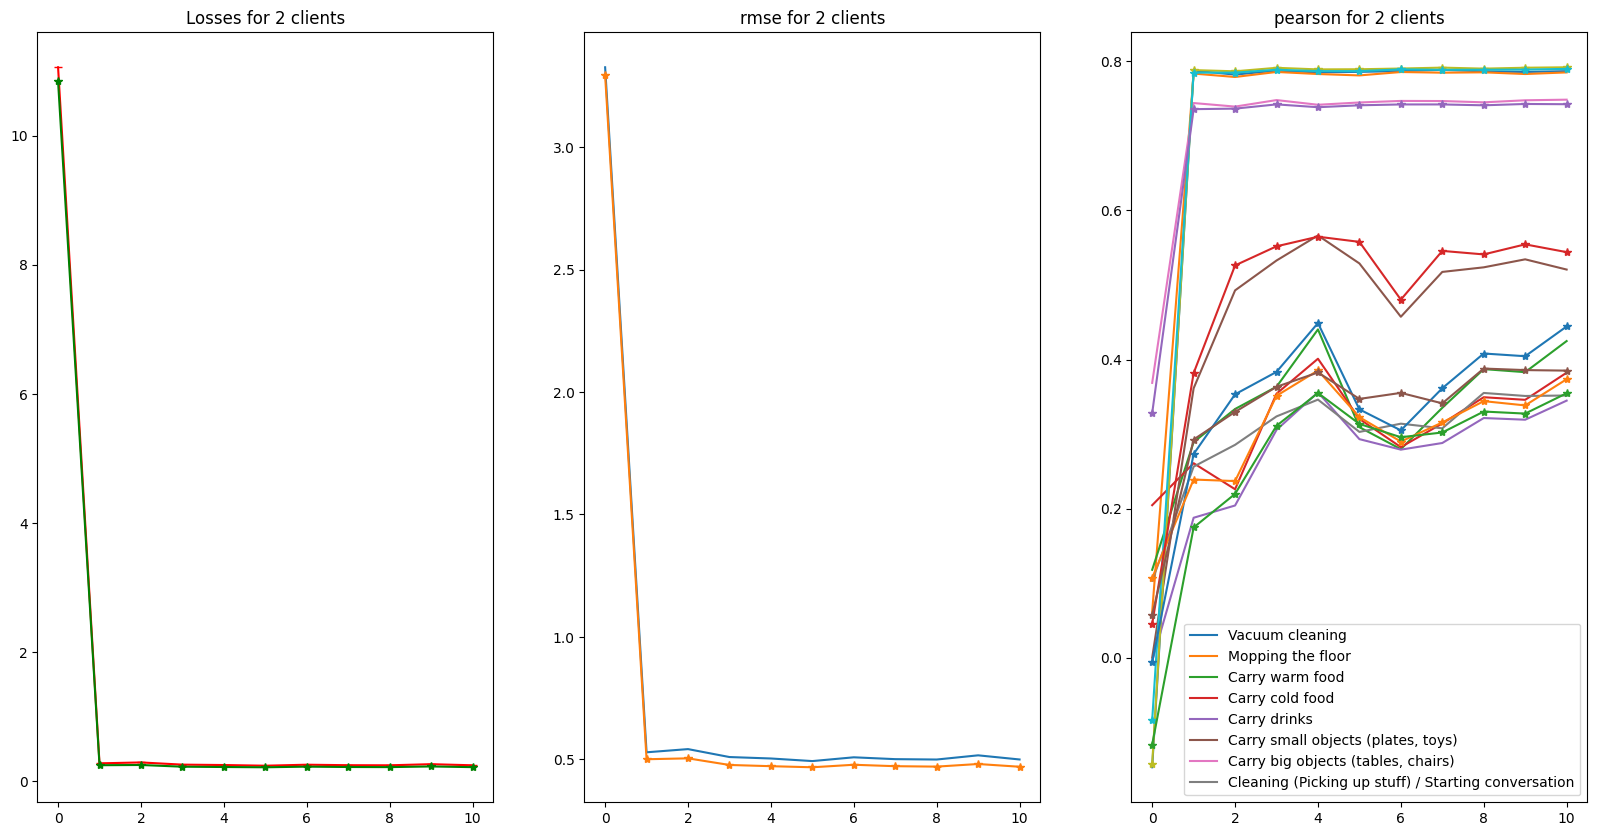

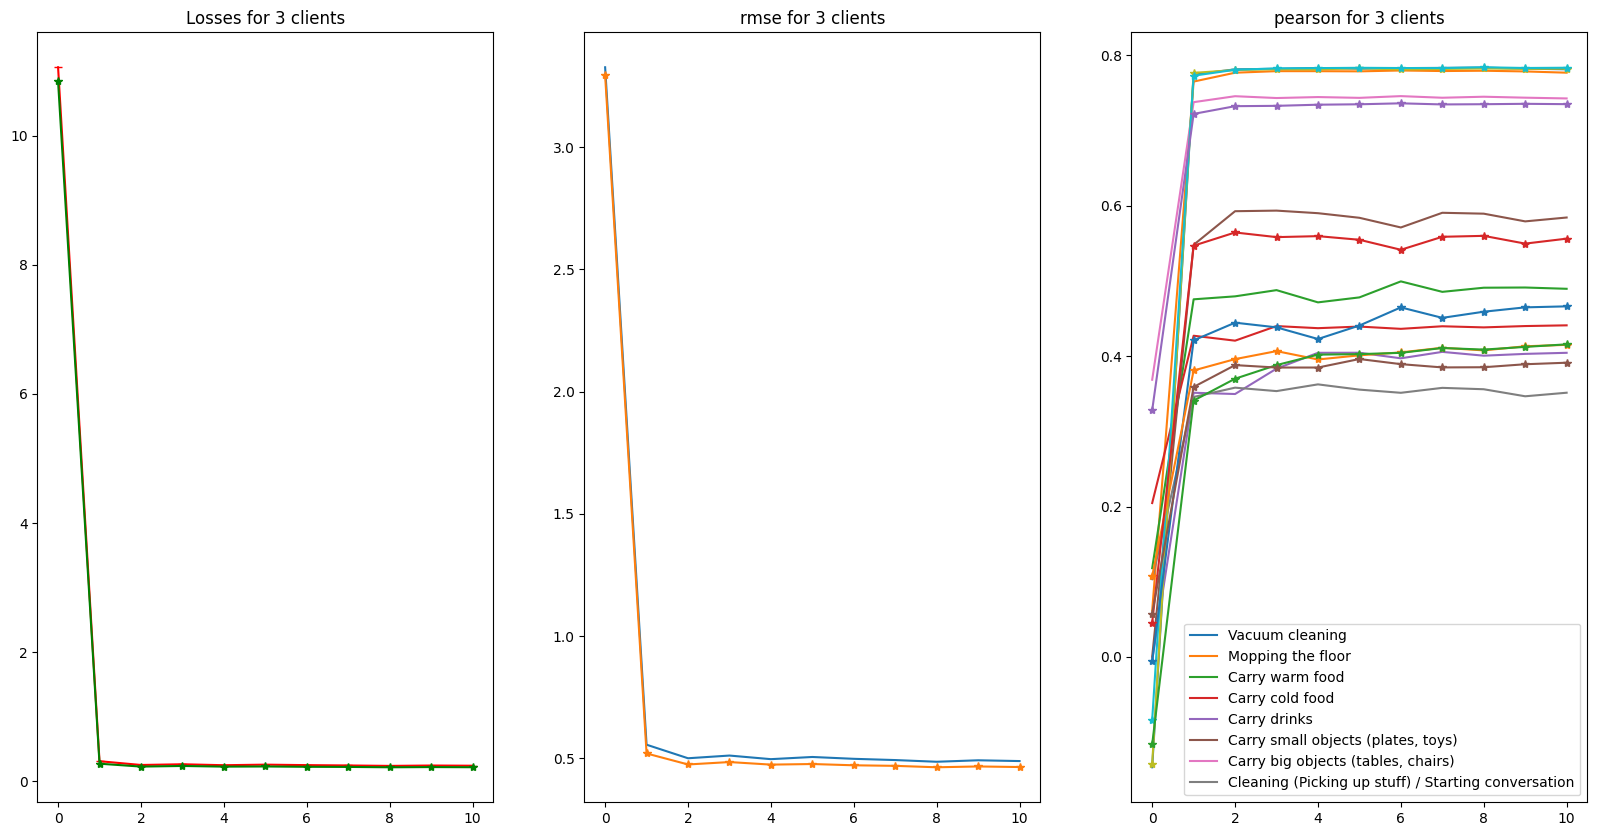

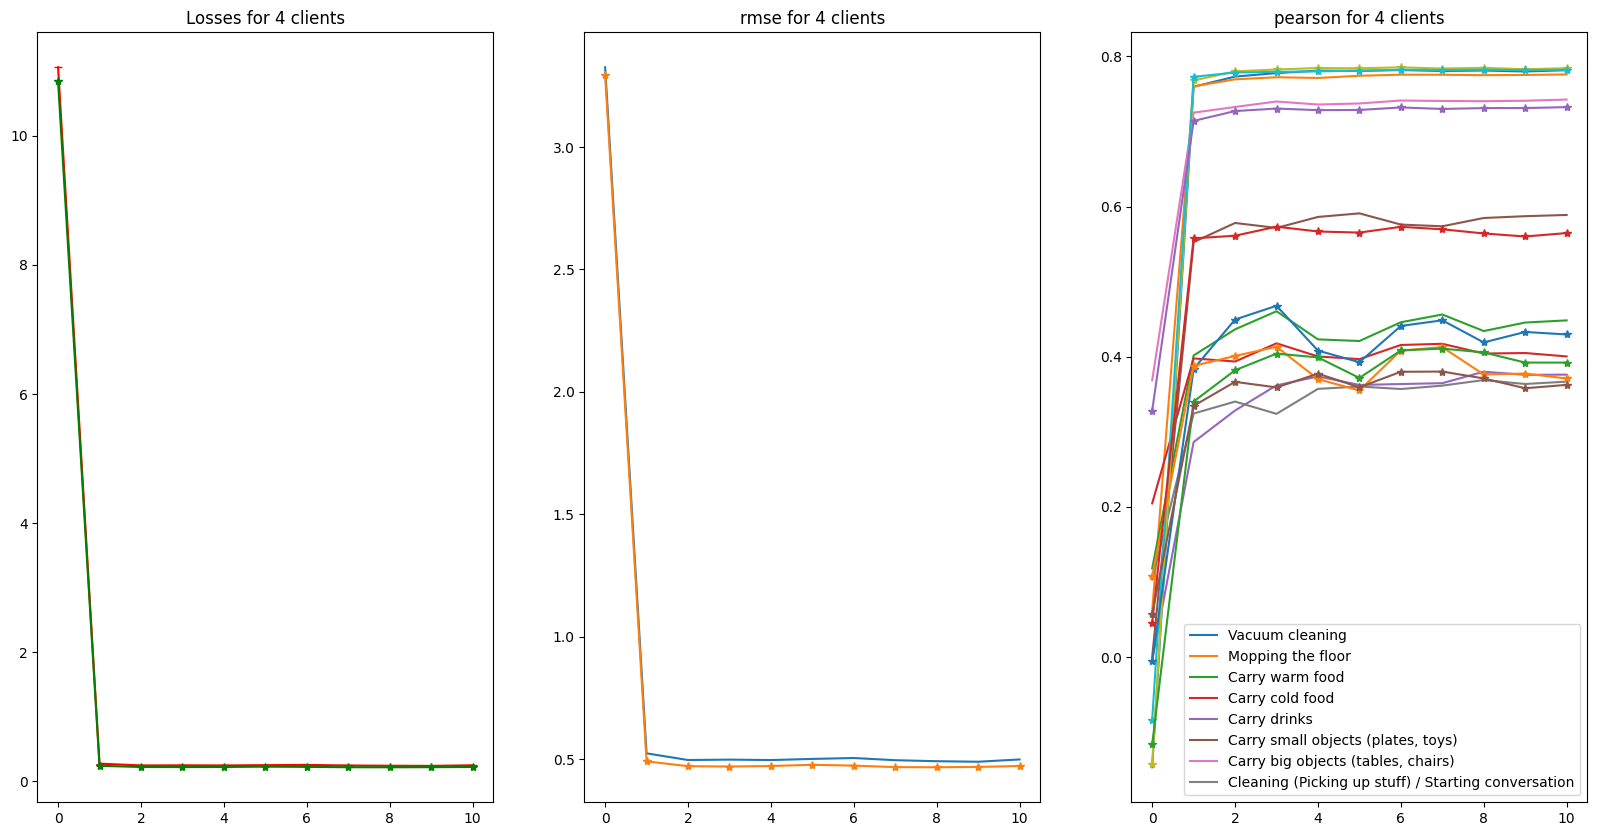

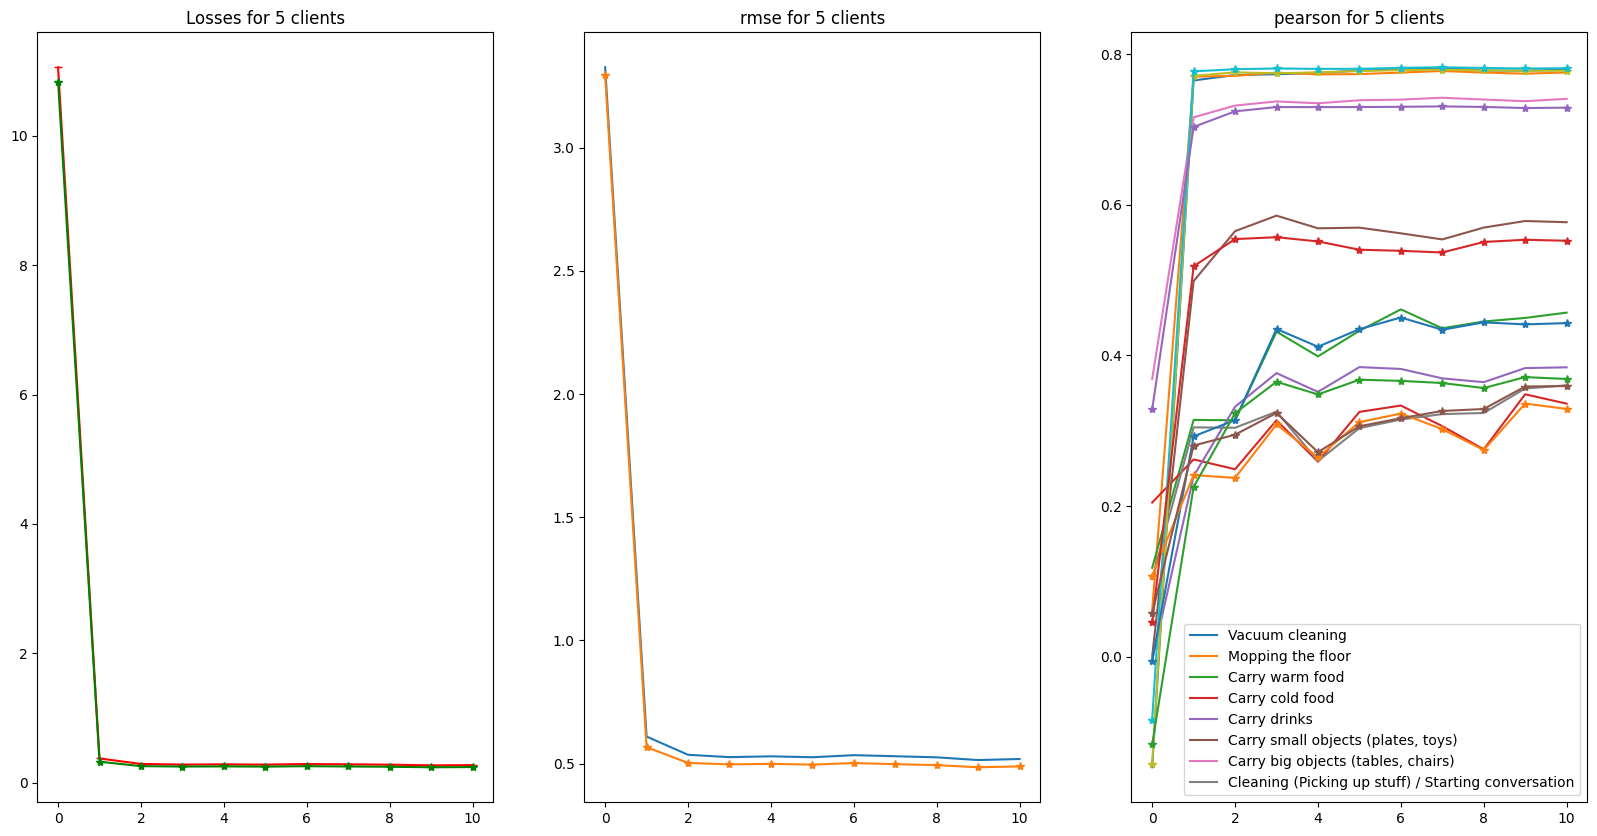

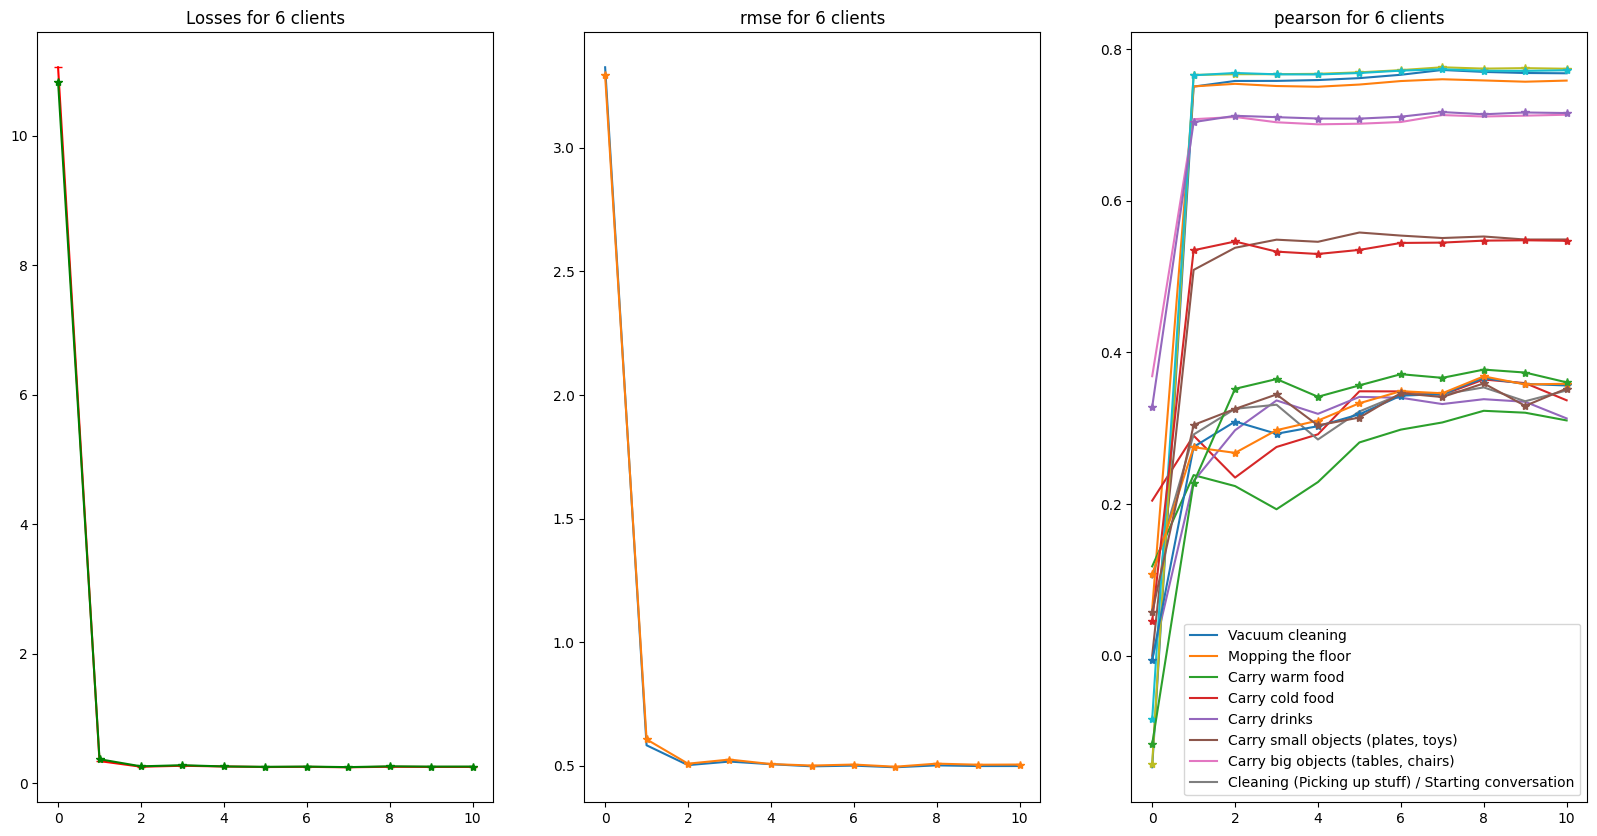

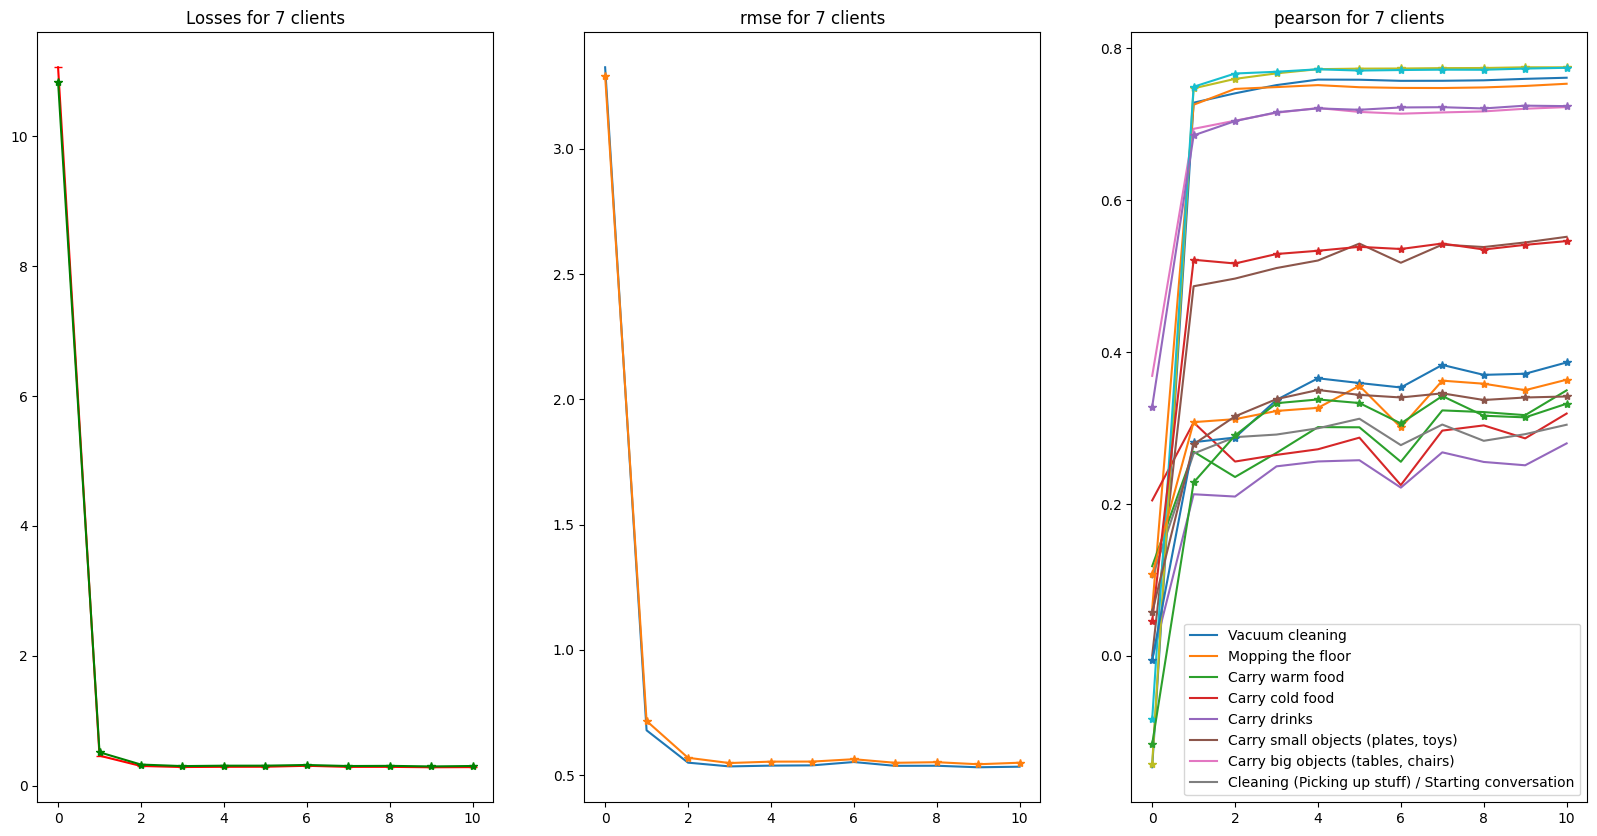

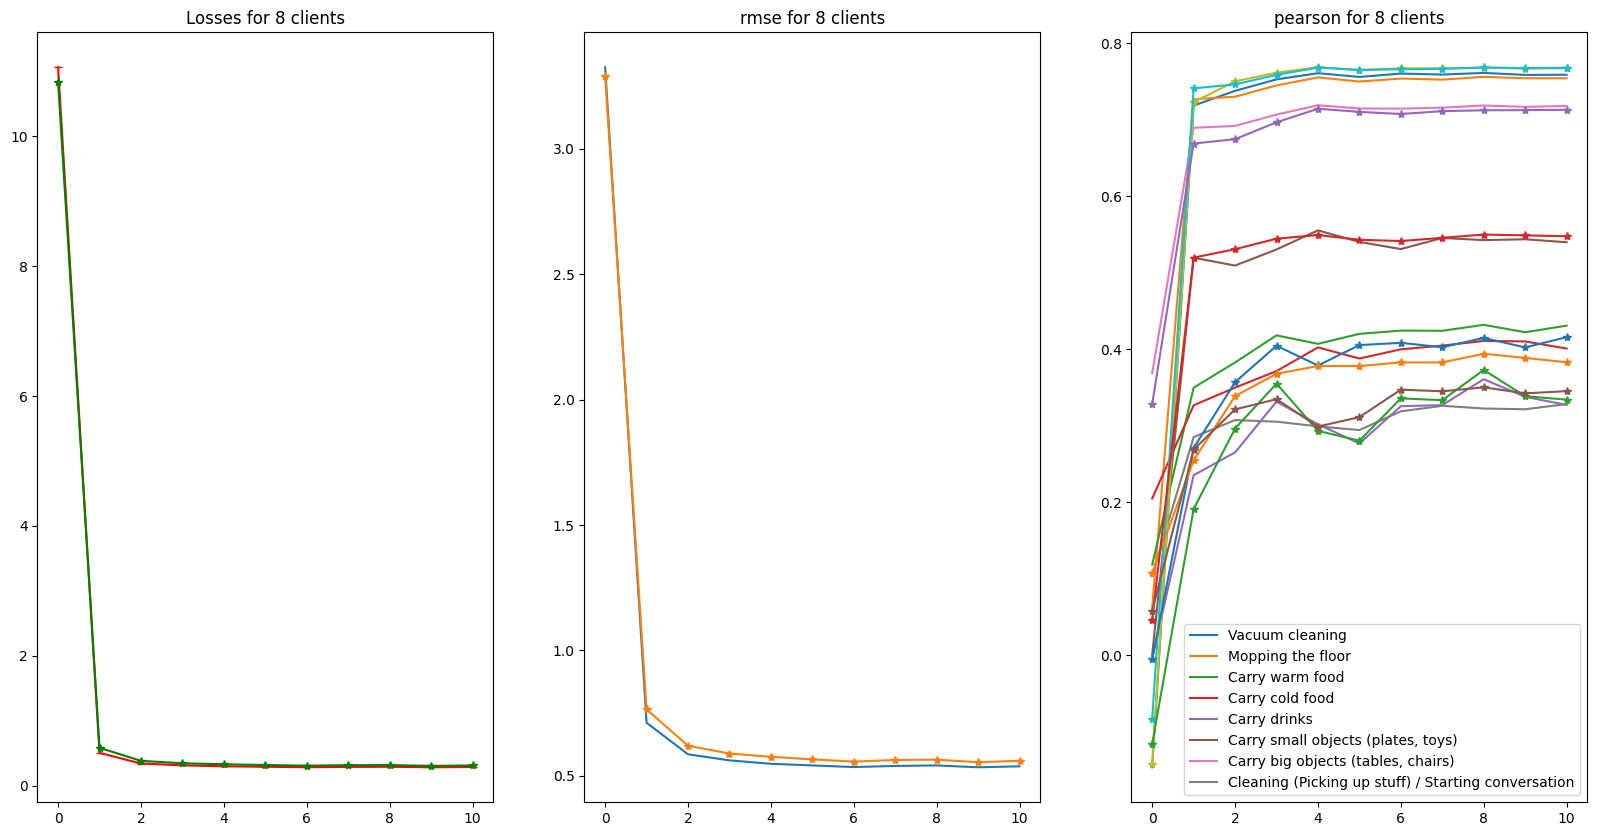

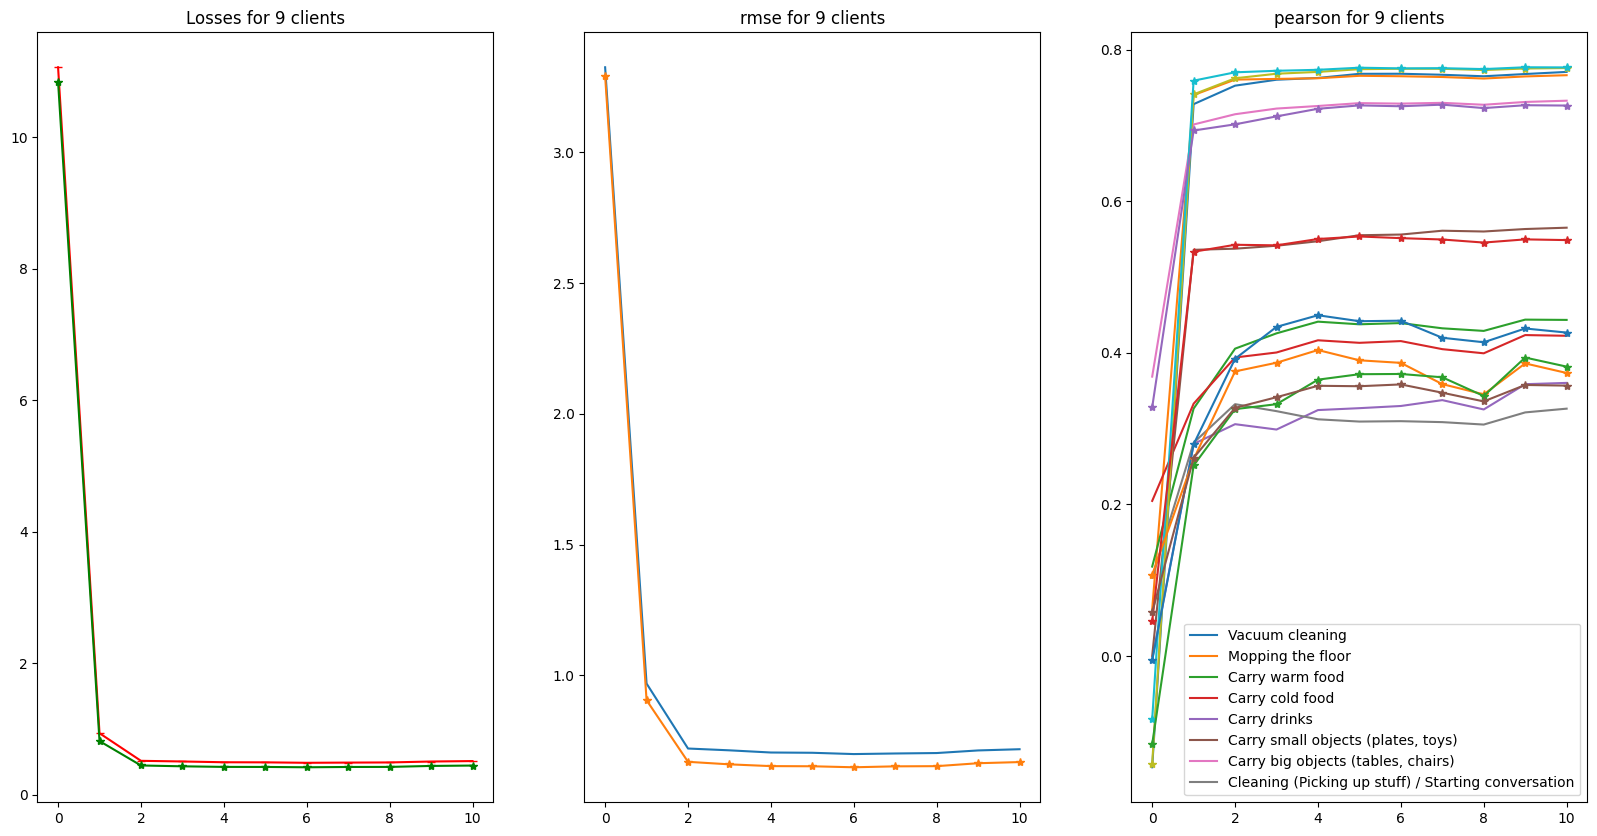

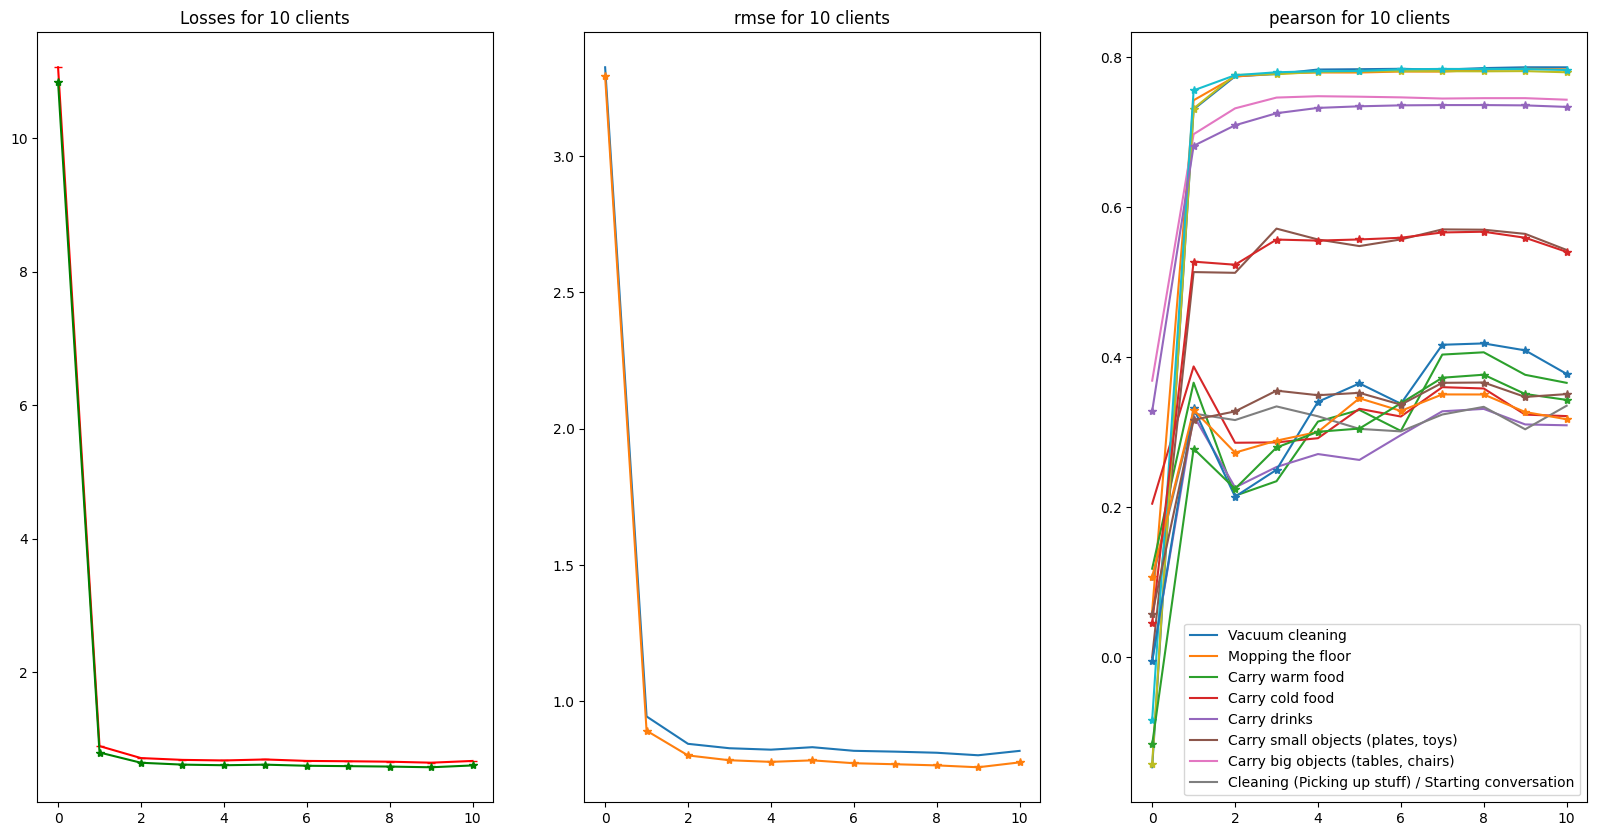

In [23]:
#for each client, plot losses, rmse in separate graphs and pearson of each label in a single graph with all labels marked in the legend
import matplotlib.pyplot as plt
for i in range(len(results)):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.plot(results[i]['Losses'], marker='_', color='red')
    plt.title("Losses for "+str(results[i]['clients'])+" clients")
    # plt.figure(figsize=(10,5))
    plt.plot(results_train[i]['Losses'],marker='*', color='green')
    plt.subplot(1,3,2)
    plt.plot(results[i]['rmse'])
    plt.plot(results_train[i]['rmse'], marker='*')

    plt.title("rmse for "+str(results[i]['clients'])+" clients")
    plt.subplot(1,3,3)
    for j in range(len(y_labels)):
        plt.plot(results[i]['pearson'][y_labels[j]])
    for j in range(len(y_labels)):
        plt.plot(results_train[i]['pearson'][y_labels[j]],marker='*')
    plt.title("pearson for "+str(results[i]['clients'])+" clients")
    plt.legend(y_labels)
    plt.savefig(f"{path}/{i+2}/{strat}.png")


In [24]:
import json
for i in range(len(results)):
    with open(f"{path}/{i+2}/{strat}/"+str(results[i]['clients'])+"clients.json", "w") as outfile:
        json.dump(results[i], outfile)


In [25]:
#load the results from the path "/results/fedAvgN" and create a dataframe with losses, rmse and average pearson of every label for each client
import json
import os
results=[]
for i in range(2,11):
    with open(f"{path}/{i}/{strat}/"+str(i)+"clients.json") as json_file:
        results.append(json.load(json_file))
import pandas as pd
df=pd.DataFrame(results)
df.head()

,clients,Losses,rmse,pearson
0,2,"[11.060606956481934, 0.2800142467021942, 0.293...","[3.325749158859253, 0.5291637778282166, 0.5421...","{'Vacuum cleaning': [-0.1468226751843182, 0.78..."
1,3,"[11.060606956481934, 0.30912721157073975, 0.25...","[3.325749158859253, 0.5559921264648438, 0.5006...","{'Vacuum cleaning': [-0.1468226751843182, 0.77..."
2,4,"[11.060606956481934, 0.2740802764892578, 0.246...","[3.325749158859253, 0.5235267877578735, 0.4961...","{'Vacuum cleaning': [-0.1468226751843182, 0.75..."
3,5,"[11.060606956481934, 0.372435063123703, 0.2876...","[3.325749158859253, 0.6102745532989502, 0.5363...","{'Vacuum cleaning': [-0.1468226751843182, 0.76..."
4,6,"[11.060606956481934, 0.3400351405143738, 0.252...","[3.325749158859253, 0.5831252932548523, 0.5028...","{'Vacuum cleaning': [-0.1468226751843182, 0.75..."


In [26]:
df=pd.DataFrame(results)


In [27]:
#add a new column named pearson_avg
df['pearson_avg']=[[] for i in range(len(df))]


In [28]:
df.head()

,clients,Losses,rmse,pearson,pearson_avg
0,2,"[11.060606956481934, 0.2800142467021942, 0.293...","[3.325749158859253, 0.5291637778282166, 0.5421...","{'Vacuum cleaning': [-0.1468226751843182, 0.78...",[]
1,3,"[11.060606956481934, 0.30912721157073975, 0.25...","[3.325749158859253, 0.5559921264648438, 0.5006...","{'Vacuum cleaning': [-0.1468226751843182, 0.77...",[]
2,4,"[11.060606956481934, 0.2740802764892578, 0.246...","[3.325749158859253, 0.5235267877578735, 0.4961...","{'Vacuum cleaning': [-0.1468226751843182, 0.75...",[]
3,5,"[11.060606956481934, 0.372435063123703, 0.2876...","[3.325749158859253, 0.6102745532989502, 0.5363...","{'Vacuum cleaning': [-0.1468226751843182, 0.76...",[]
4,6,"[11.060606956481934, 0.3400351405143738, 0.252...","[3.325749158859253, 0.5831252932548523, 0.5028...","{'Vacuum cleaning': [-0.1468226751843182, 0.75...",[]


In [29]:
y_labels=list(df['pearson'][0].keys())

for i in range(df.shape[0]):
    li=[]
    for k in range(10):
        sum=0
        for j in range(len(y_labels)):
            sum=sum+df['pearson'][i][y_labels[j]][k]
        sum=sum/10
        li.append(sum)
    df['pearson_avg'][i]=li



/tmp/ipykernel_263925/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_263925/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_263925/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_263925/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [30]:
for i in range(df.shape[0]):
  # mini=min(df['Losses'][i])
  # idx=df['Losses'][i].index(mini)
  # print(idx)
  idx=-1
  df['Losses'][i]=df['Losses'][i][idx]
  df['rmse'][i]=df['rmse'][i][idx]
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]


/tmp/ipykernel_263925/3851578825.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Losses'][i]=df['Losses'][i][idx]
/tmp/ipykernel_263925/3851578825.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rmse'][i]=df['rmse'][i][idx]
/tmp/ipykernel_263925/3851578825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]
/tmp/ipykernel_263925/3851578825.py:6: SettingWithCopyWarning: 
A v

In [31]:
df

,clients,Losses,rmse,pearson,pearson_avg
0,2,0.24986,0.49986,"{'Vacuum cleaning': [-0.1468226751843182, 0.78...",0.424964
1,3,0.23923,0.489112,"{'Vacuum cleaning': [-0.1468226751843182, 0.77...",0.456522
2,4,0.248522,0.498519,"{'Vacuum cleaning': [-0.1468226751843182, 0.75...",0.447277
3,5,0.269599,0.519229,"{'Vacuum cleaning': [-0.1468226751843182, 0.76...",0.440473
4,6,0.249168,0.499167,"{'Vacuum cleaning': [-0.1468226751843182, 0.75...",0.413665
5,7,0.285006,0.53386,"{'Vacuum cleaning': [-0.1468226751843182, 0.72...",0.392147
6,8,0.2887,0.537308,"{'Vacuum cleaning': [-0.1468226751843182, 0.71...",0.426396
7,9,0.514099,0.717007,"{'Vacuum cleaning': [-0.1468226751843182, 0.72...",0.437463
8,10,0.66959,0.818285,"{'Vacuum cleaning': [-0.1468226751843182, 0.73...",0.419476


In [32]:
df.drop(['pearson'], axis=1, inplace=True)

In [33]:
for i in range(df.shape[0]):
  try:
    data=pd.read_csv(f"{path}/clients{i+2}.csv")
    data.drop(["Unnamed: 0"], axis=1, inplace=True)
  except:
    data=pd.DataFrame(columns=["methods", "Loss", "RMSE", "PCC"])
  # data=data.append(pd.Series(["FedAvg_NoAug",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]]), ignore_index=True)
  data=pd.concat([data,pd.Series([f"{strat}",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]] , index=data.columns ).to_frame().T])
  data.to_csv(f"{path}/clients{i+2}.csv")

